In [5]:
library(ggplot2)        # plotting & data
library(dplyr)          # data manipulation
library(tidyr)          # data re-shaping
library(magrittr)       # pipe operator
library(gridExtra)      # provides side-by-side plotting
library(dplyr)          # dplyr for pipe operations
library(moments)        # bonett.test for normality
library(ggQC)           # to create xMR and iMR charts
library(repr)           # change plot size
library(nortest)        # anderson darling test
library(climtrends)     # FindOutliersTietjenMooreTest


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [660]:
install.packages('nortest_1.0-4.tar.gz', repos = NULL, type = "source")

In [6]:
# Change plot size to 12 x 6
parentdir <- "flowjo_data/8v8/"
options(repr.plot.width=15, repr.plot.height=10)

In [12]:
# generate well ids for x-axis 
wellIDs <- data.frame(sapply(LETTERS[1:8], function(x) {paste0(x,seq(2,8))}))
rows <- list(c("A", "E"), c("B", "F"), c("C", "G"), c("D", "H"))
head(wellIDs)

A  B  C  D  E  F  G  H 
1 A2 B2 C2 D2 E2 F2 G2 H2
2 A3 B3 C3 D3 E3 F3 G3 H3
3 A4 B4 C4 D4 E4 F4 G4 H4
4 A5 B5 C5 D5 E5 F5 G5 H5
5 A6 B6 C6 D6 E6 F6 G6 H6
6 A7 B7 C7 D7 E7 F7 G7 H7

### Cell count comparison of 8 old vs 8 new

In [6]:
dfcnt_new8 <- list()
dfcnt_old8 <- list()
new8_file <- list.files(parentdir, pattern = "*CELLCNT_NEW*")
old8_file <- list.files(parentdir, pattern = "*CELLCNT_OLD*")


cnt <- 1
dfn_ls <- list()
dfo_ls <- list()
dfn_sub_ls <- list()
dfo_sub_ls <- list()

for (i in seq(3)) {
    dfn_ls[[i]] <- read.csv(paste0(parentdir, new8_file[i]))
    dfo_ls[[i]] <- read.csv(paste0(parentdir, old8_file[i]))
    for (j in seq(4)) {
          dfn_sub_ls[[cnt]] <- dfn_ls[[i]] %>%
              na.omit() %>% 
              filter(X < 9 & X > 1) %>%
              filter(grepl(paste0("[", rows[[j]][1], "|", rows[[j]][2], "]"), Y))
          dfo_sub_ls[[cnt]] <- dfo_ls[[i]] %>%
              na.omit() %>% 
              filter(X < 9 & X > 1) %>%
              filter(grepl(paste0("[", rows[[j]][1], "|", rows[[j]][2], "]"), Y))
    cnt <- cnt + 1
    }
}

#### compare two groups at a time for the variance using F test
- The p values are higher than 0.05, meaning the variances do not change from plate 1 to 3
- Run F-test when you want to perform a two samples t-test to check the equality of the variances of the two samples

#### Shapiro test
- the shapiro.test, the null hypothesis assumes that the data is drawn from a normal distribution. Since the p-value > 0.05, we fail to reject the null hypothesis, meaning that it is likely that the data is drawn from a normal distribution

#### Anderson-Darling test for normality
- a given sample of data is drawn from a given probability distribution
- has to be greater than 7 points so cannot run this test

In [19]:
# 8 chl New vs Old (A/E)
idx = c(1,5,9)
j = 1
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df_stats <- setNames(data.frame(matrix(ncol = 3, nrow = 0)), c("F_TEST", "SHAPIRO_TEST_OLD", "SHAPIRO_TEST_NEW"))
df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    dff <- bind_rows(dfo[[i-1]], dfn[[i-1]])
    stat <- var.test(count ~ method, dff)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print("Old 8")
    stat <- shapiro.test(dfo[[i-1]]$count)
    df_stats[i-1, "SHAPIRO_TEST_OLD"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print("New 8")
    stat <- shapiro.test(dfn[[i-1]]$count)
    df_stats[i-1, "SHAPIRO_TEST_NEW"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats_", pat1, "_", pat2, ".csv"), row.names = FALSE)

[1] "A - E old vs. new"
[1] "A2 - E2"

	F test to compare two variances

data:  count by method
F = 0.023906, num df = 5, denom df = 5, p-value = 0.0008824
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.003345126 0.170838155
sample estimates:
ratio of variances 
        0.02390555 

[1] "Old 8"

	Shapiro-Wilk normality test

data:  dfo[[i - 1]]$count
W = 0.78179, p-value = 0.04006

[1] "New 8"

	Shapiro-Wilk normality test

data:  dfn[[i - 1]]$count
W = 0.95092, p-value = 0.7477

[1] "A3 - E3"

	F test to compare two variances

data:  count by method
F = 0.026845, num df = 5, denom df = 5, p-value = 0.001167
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.003756494 0.191847036
sample estimates:
ratio of variances 
        0.02684534 

[1] "Old 8"

	Shapiro-Wilk normality test

data:  dfo[[i - 1]]$count
W = 0.80447, p-value = 0.06446

[1] "New 8"

	Shapiro-Wilk normality test

data

In [20]:
# 8 chl New vs Old (B/F)
idx = c(2,6,10)
j = 2
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- setNames(data.frame(matrix(ncol = 3, nrow = 0)), c("F_TEST", "SHAPIRO_TEST_OLD", "SHAPIRO_TEST_NEW"))

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    dff <- bind_rows(dfo[[i-1]], dfn[[i-1]])
    stat <- var.test(count ~ method, dff)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print("Old 8")
    stat <- shapiro.test(dfo[[i-1]]$count)
    df_stats[i-1, "SHAPIRO_TEST_OLD"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print("New 8")
    stat <- shapiro.test(dfn[[i-1]]$count)
    df_stats[i-1, "SHAPIRO_TEST_NEW"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
}
write.csv(df_stats, paste0("8v8_stats_", pat1, "_", pat2, ".csv"), row.names = FALSE)

[1] "B - F old vs. new"
[1] "B2 - F2"

	F test to compare two variances

data:  count by method
F = 0.034344, num df = 5, denom df = 5, p-value = 0.002106
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.004805755 0.245433640
sample estimates:
ratio of variances 
        0.03434376 

[1] "Old 8"

	Shapiro-Wilk normality test

data:  dfo[[i - 1]]$count
W = 0.71278, p-value = 0.008405

[1] "New 8"

	Shapiro-Wilk normality test

data:  dfn[[i - 1]]$count
W = 0.87851, p-value = 0.2623

[1] "B3 - F3"

	F test to compare two variances

data:  count by method
F = 0.036988, num df = 5, denom df = 5, p-value = 0.002512
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.005175742 0.264329150
sample estimates:
ratio of variances 
        0.03698783 

[1] "Old 8"

	Shapiro-Wilk normality test

data:  dfo[[i - 1]]$count
W = 0.74087, p-value = 0.01619

[1] "New 8"

	Shapiro-Wilk normality test

data

In [21]:
# 8 chl New vs Old (C/G)
idx = c(3,7,11)
j = 3
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df_stats <- setNames(data.frame(matrix(ncol = 3, nrow = 0)), c("F_TEST", "SHAPIRO_TEST_OLD", "SHAPIRO_TEST_NEW"))

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    dff <- bind_rows(dfo[[i-1]], dfn[[i-1]])
    stat <- var.test(count ~ method, dff)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print("Old 8")
    stat <- shapiro.test(dfo[[i-1]]$count)
    df_stats[i-1, "SHAPIRO_TEST_OLD"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print("New 8")
    stat <- shapiro.test(dfn[[i-1]]$count)
    df_stats[i-1, "SHAPIRO_TEST_NEW"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
}
write.csv(df_stats, paste0("8v8_stats_", pat1, "_", pat2, ".csv"), row.names = FALSE)

[1] "C - G old vs. new"
[1] "C2 - G2"

	F test to compare two variances

data:  count by method
F = 0.095213, num df = 5, denom df = 5, p-value = 0.02199
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.01332319 0.68042549
sample estimates:
ratio of variances 
        0.09521259 

[1] "Old 8"

	Shapiro-Wilk normality test

data:  dfo[[i - 1]]$count
W = 0.73333, p-value = 0.01361

[1] "New 8"

	Shapiro-Wilk normality test

data:  dfn[[i - 1]]$count
W = 0.86054, p-value = 0.191

[1] "C3 - G3"

	F test to compare two variances

data:  count by method
F = 0.081175, num df = 5, denom df = 5, p-value = 0.01545
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.01135888 0.58010671
sample estimates:
ratio of variances 
        0.08117488 

[1] "Old 8"

	Shapiro-Wilk normality test

data:  dfo[[i - 1]]$count
W = 0.70405, p-value = 0.006817

[1] "New 8"

	Shapiro-Wilk normality test

data:  dfn[

In [22]:
# 8 chl New vs Old (D/H)
idx = c(4,8,12)
j = 4
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df_stats <- setNames(data.frame(matrix(ncol = 3, nrow = 0)), c("F_TEST", "SHAPIRO_TEST_OLD", "SHAPIRO_TEST_NEW"))

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    dff <- bind_rows(dfo[[i-1]], dfn[[i-1]])
    stat <- var.test(count ~ method, dff)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print("Old 8")
    stat <- shapiro.test(dfo[[i-1]]$count)
    df_stats[i-1, "SHAPIRO_TEST_OLD"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print("New 8")
    stat <- shapiro.test(dfn[[i-1]]$count)
    df_stats[i-1, "SHAPIRO_TEST_NEW"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
}
write.csv(df_stats, paste0("8v8_stats_", pat1, "_", pat2, ".csv"), row.names = FALSE)

[1] "D - H old vs. new"
[1] "D2 - H2"

	F test to compare two variances

data:  count by method
F = 0.099793, num df = 5, denom df = 5, p-value = 0.02437
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.01396417 0.71316084
sample estimates:
ratio of variances 
        0.09979327 

[1] "Old 8"

	Shapiro-Wilk normality test

data:  dfo[[i - 1]]$count
W = 0.78439, p-value = 0.04234

[1] "New 8"

	Shapiro-Wilk normality test

data:  dfn[[i - 1]]$count
W = 0.92312, p-value = 0.5281

[1] "D3 - H3"

	F test to compare two variances

data:  count by method
F = 0.024759, num df = 5, denom df = 5, p-value = 0.0009604
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.003464483 0.176933830
sample estimates:
ratio of variances 
        0.02475852 

[1] "Old 8"

	Shapiro-Wilk normality test

data:  dfo[[i - 1]]$count
W = 0.77984, p-value = 0.03842

[1] "New 8"

	Shapiro-Wilk normality test

data:  

### qq-plot
- Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that's roughly straight

### Histogram with density line plot
- We also see similar skewness within the sample distributions.

In [102]:
# A-E
# 8 chl New vs Old (A/E)
p_qq_new8_cnt_ls <- list()
p_hst_new8_cnt_ls <- list()
idx = c(1,5,9)
j = 1
colm = 2
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
p_qq_cnt_ls <- list()
p_hst_cnt_ls <- list()


df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
}

dfo <- do.call(rbind, dfo)
dfn <- do.call(rbind, dfn)
df.t <- rbind(dfo, dfn)

p_qq_cnt_ls[[j]] <- ggplot(df.t, aes(sample = count)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(column~ method) +
            ggtitle(paste("New 8 vs. Old 8 q-q plot for each titration point dataset:", pat1, "-", pat2))

p_hst_cnt_ls[[j]] <- ggplot(data = df.t, aes(x = count)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(column~ method) +
    ggtitle(paste("New 8 vs. Old 8 histogram/density plot for each titration point dataset:", pat1, "-", pat2))

[1] "A - E old vs. new"
[1] "A2 - E2"
[1] "A3 - E3"
[1] "A4 - E4"
[1] "A5 - E5"
[1] "A6 - E6"
[1] "A7 - E7"
[1] "A8 - E8"


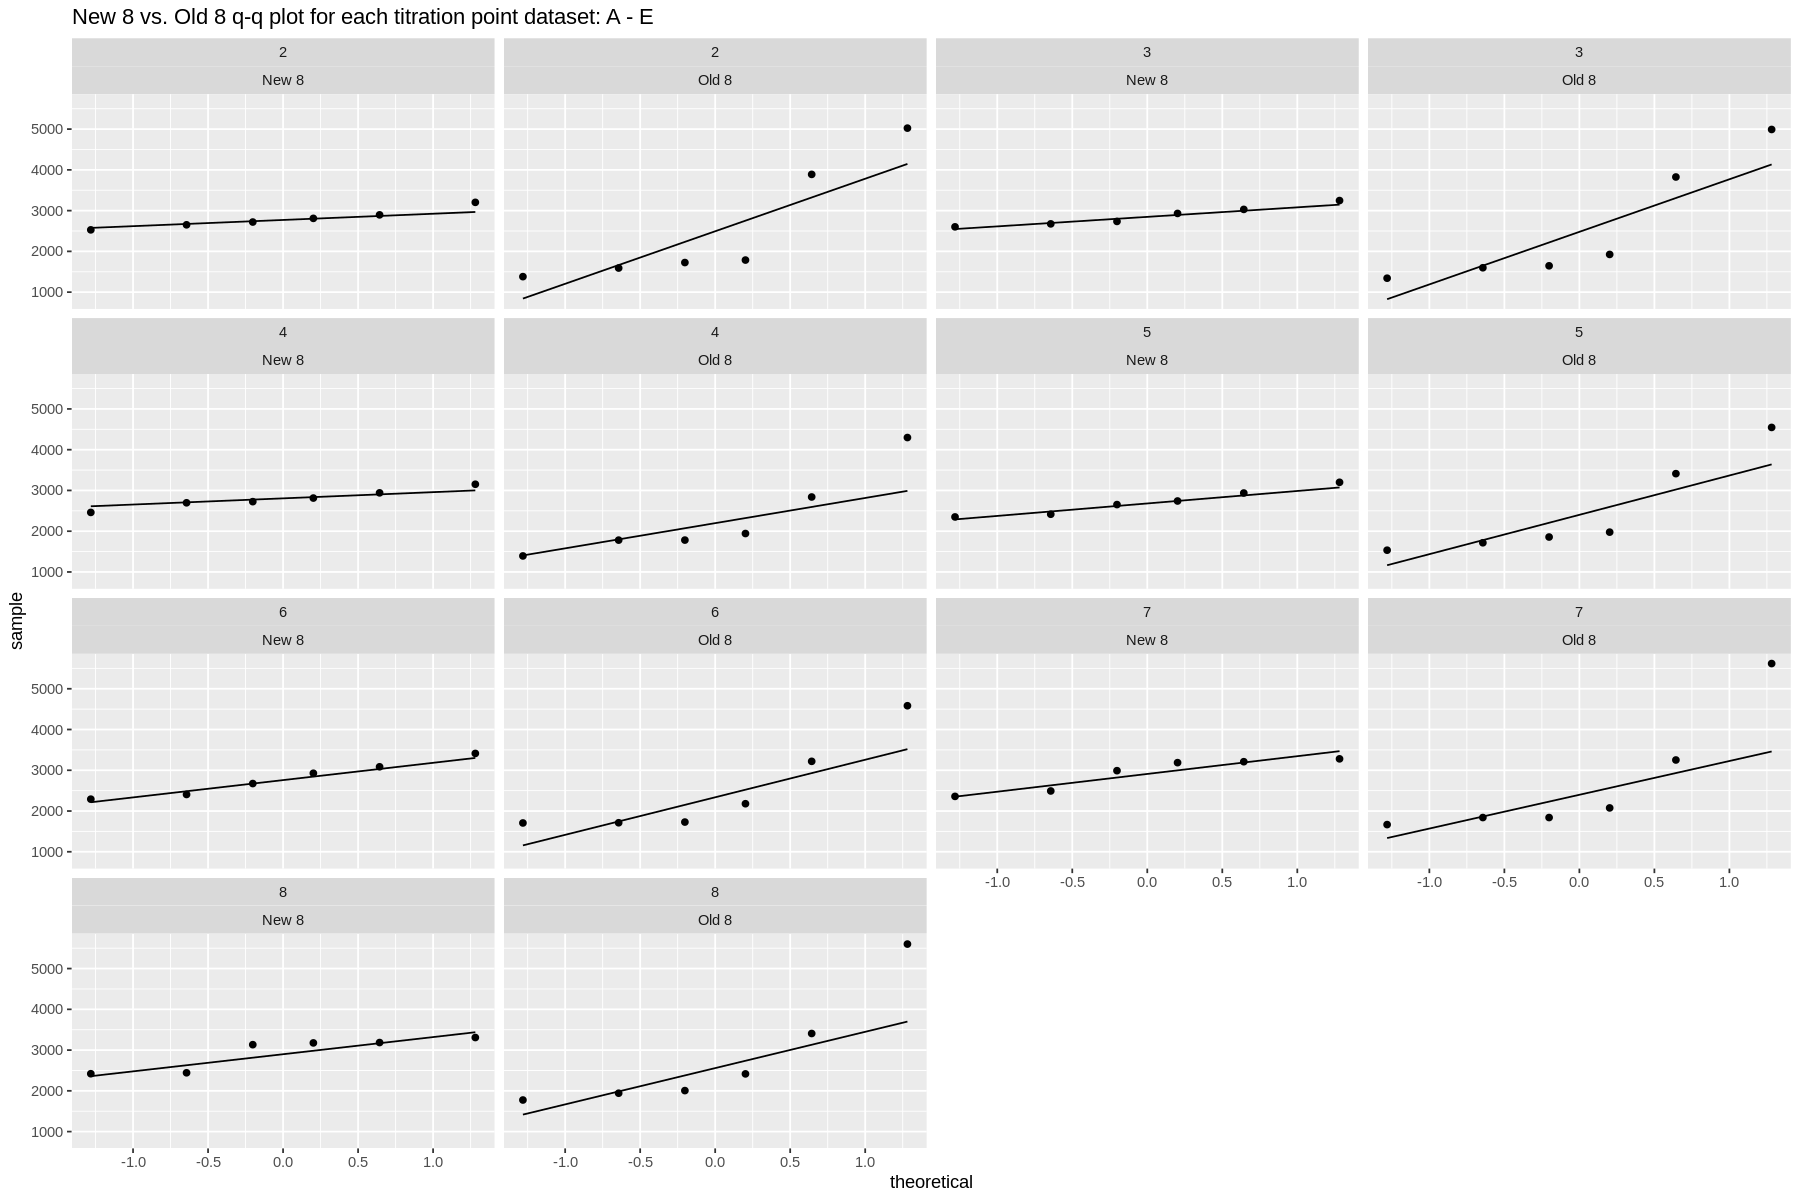

In [103]:
p_qq_cnt_ls[[1]]

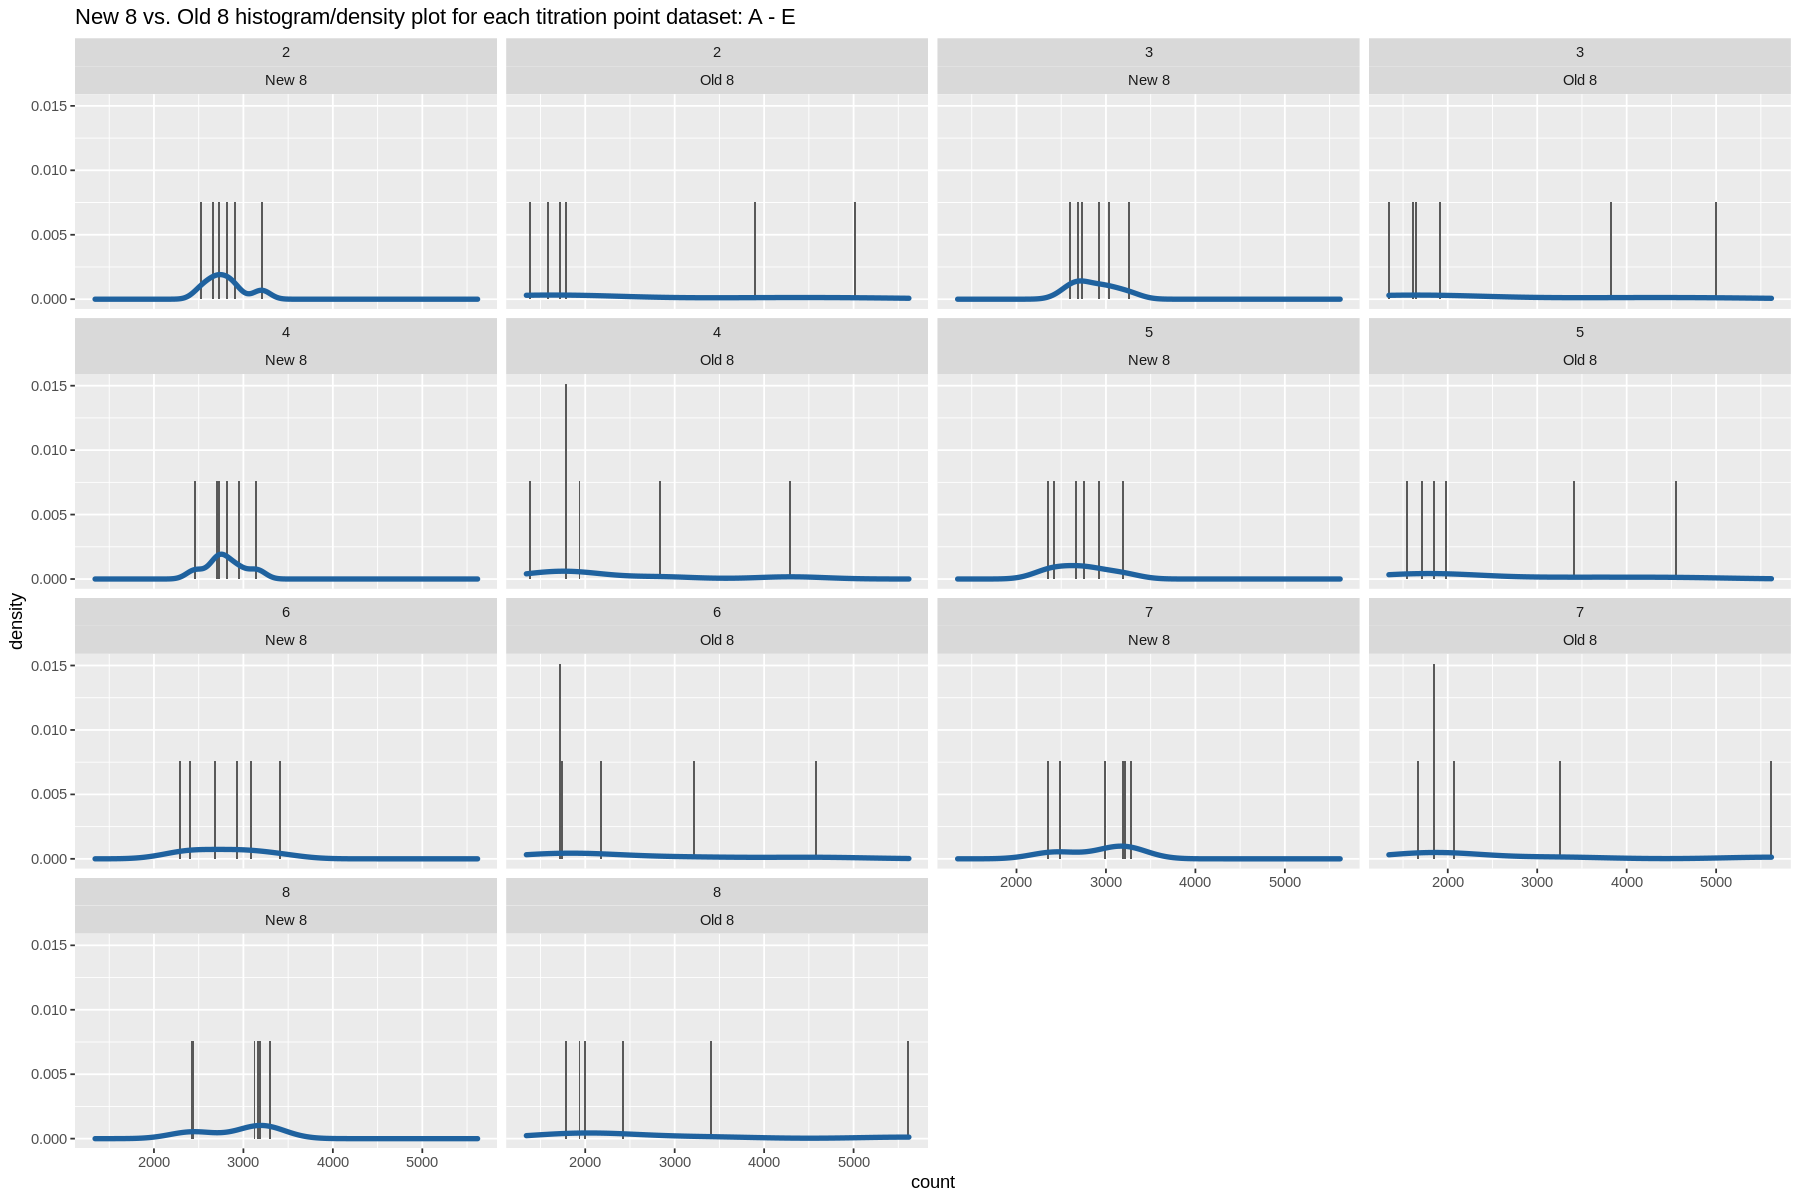

In [105]:
p_hst_cnt_ls[[1]]

In [98]:
# B-F
# 8 chl New vs Old 
idx = c(2,6,10)
j = 2
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
p_qq_cnt_ls <- list()
p_hst_cnt_ls <- list()

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
}

dfo <- do.call(rbind, dfo)
dfn <- do.call(rbind, dfn)
df.t <- rbind(dfo, dfn)

p_qq_cnt_ls[[j]] <- ggplot(df.t, aes(sample = count)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(column~ method) +
            ggtitle(paste("New 8 vs. Old 8 q-q plot for each titration point dataset:", pat1, "-", pat2))

p_hst_cnt_ls[[j]] <- ggplot(data = df.t, aes(x = count)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(column~ method) +
    ggtitle(paste("New 8 vs. Old 8 histogram/density plot for each titration point dataset:", pat1, "-", pat2))

[1] "B - F old vs. new"
[1] "B2 - F2"
[1] "B3 - F3"
[1] "B4 - F4"
[1] "B5 - F5"
[1] "B6 - F6"
[1] "B7 - F7"
[1] "B8 - F8"


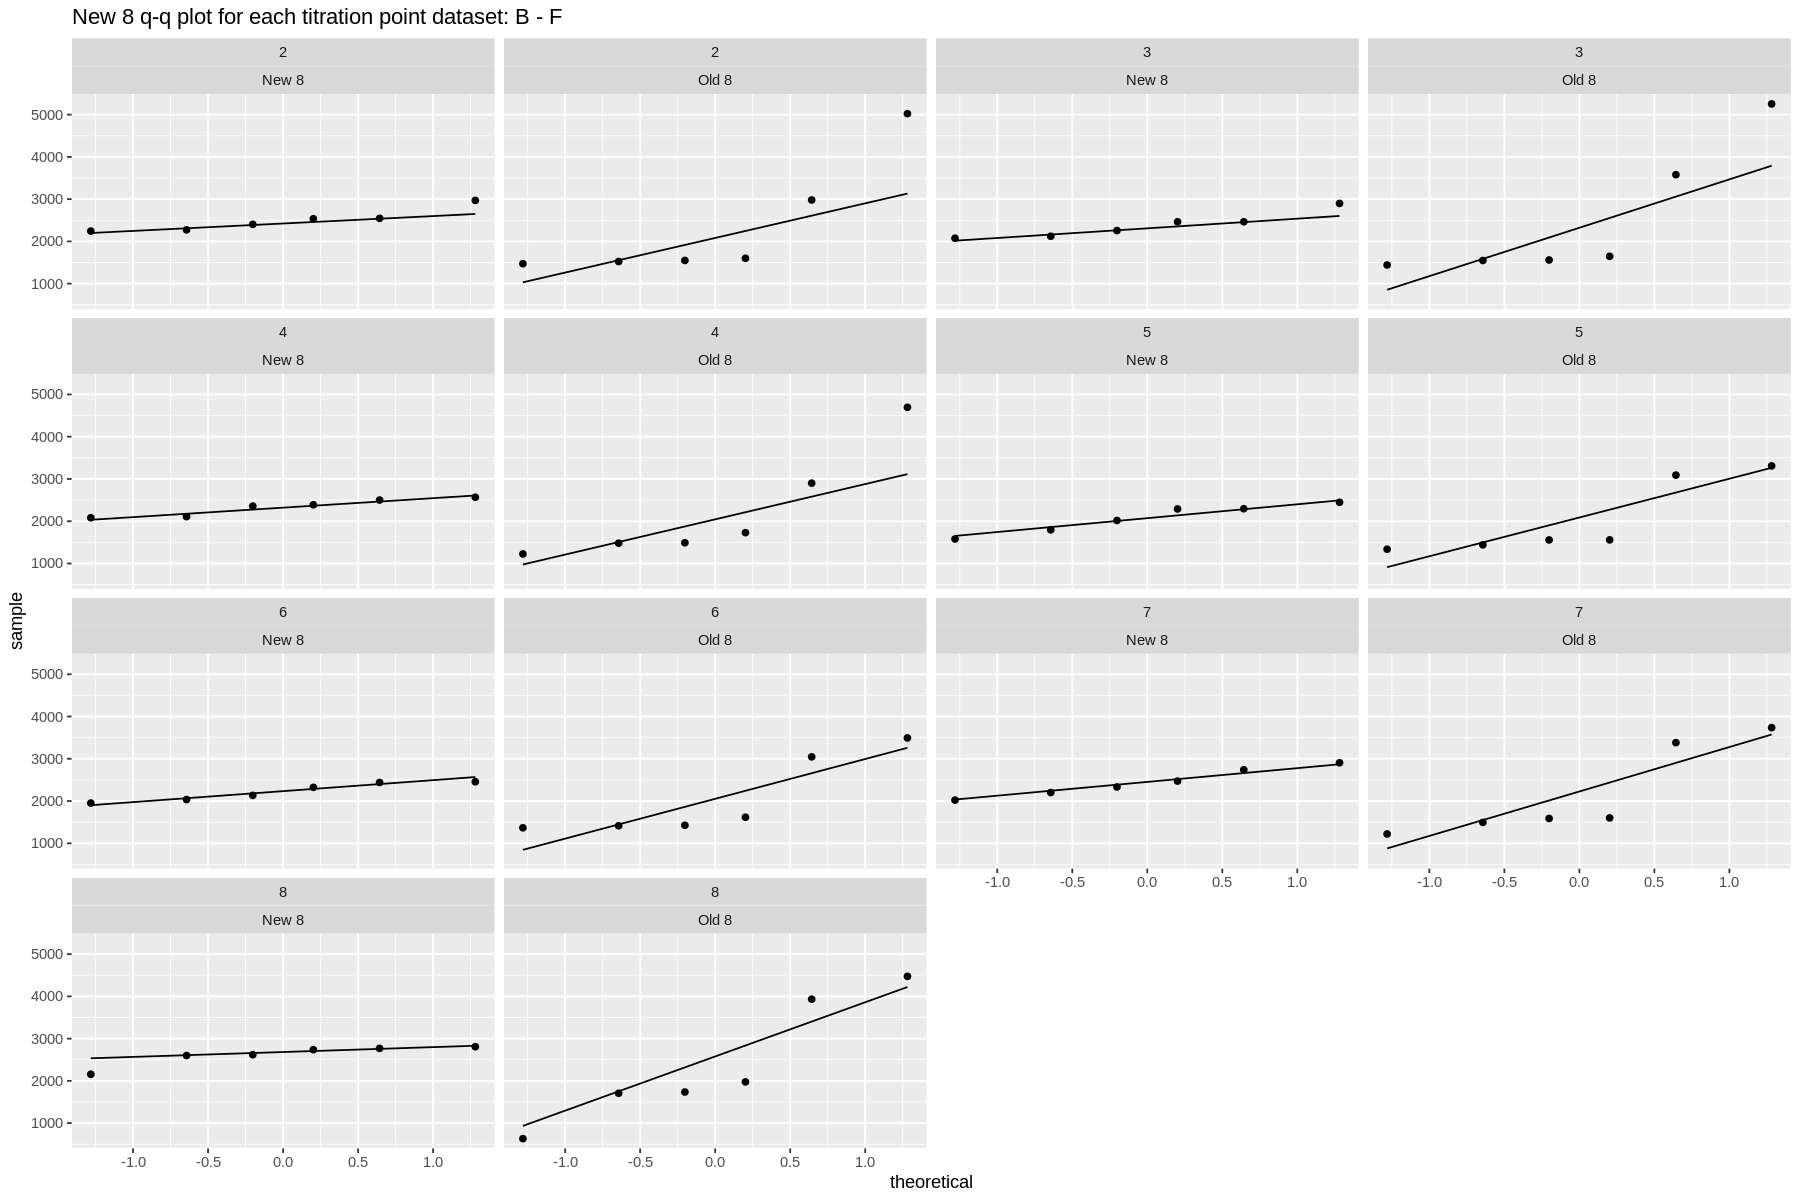

In [99]:
p_qq_cnt_ls[[2]]

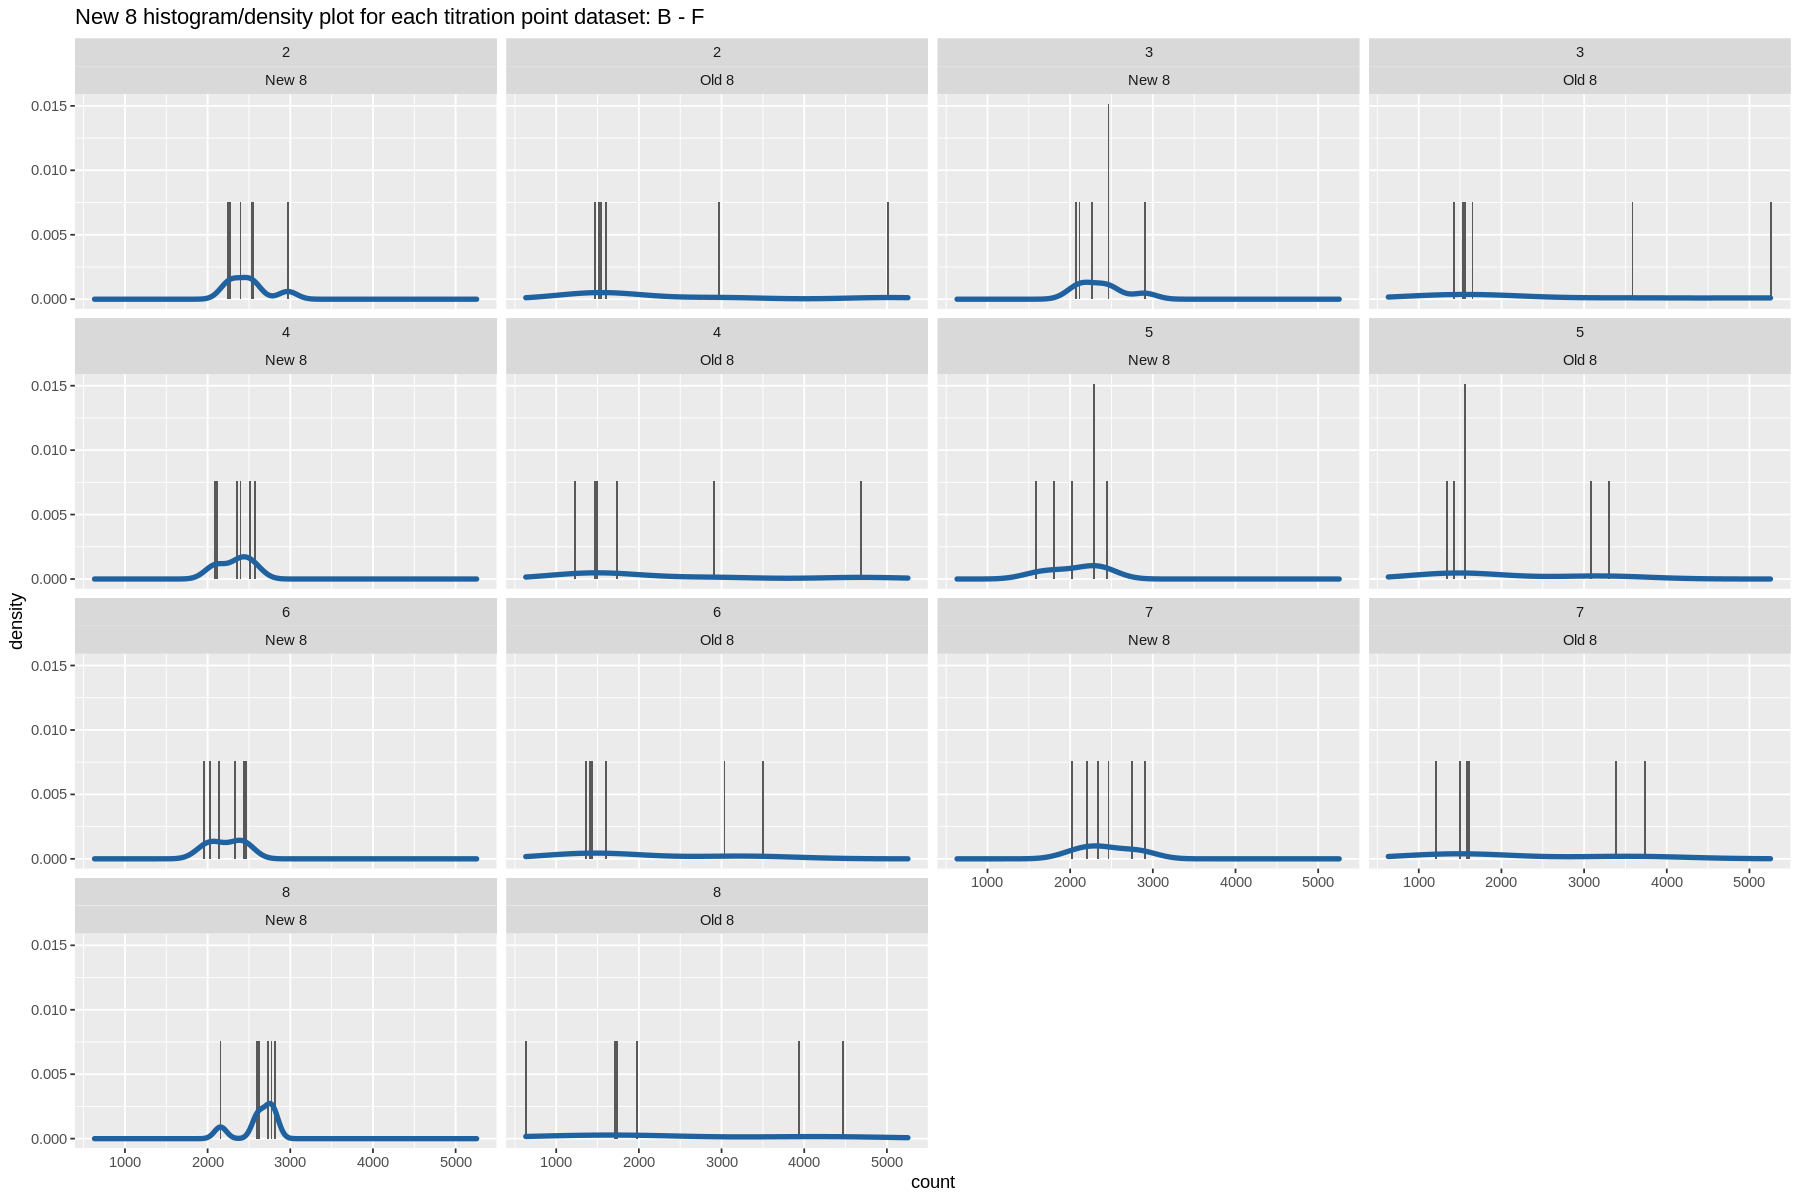

In [101]:
p_hst_cnt_ls[[2]]

In [106]:
# C-G
idx = c(3,7,11)
j = 3
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
p_qq_cnt_ls <- list()
p_hst_cnt_ls <- list()

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
}

dfo <- do.call(rbind, dfo)
dfn <- do.call(rbind, dfn)

df.t <- rbind(dfo, dfn)

p_qq_cnt_ls[[j]] <- ggplot(df.t, aes(sample = count)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(column~ method) +
            ggtitle(paste("New 8 vs. Old 8 q-q plot for each titration point dataset:", pat1, "-", pat2))

p_hst_cnt_ls[[j]] <- ggplot(data = df.t, aes(x = count)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(column~ method) +
    ggtitle(paste("New 8 vs. Old 8 histogram/density plot for each titration point dataset:", pat1, "-", pat2))

[1] "C - G old vs. new"
[1] "C2 - G2"
[1] "C3 - G3"
[1] "C4 - G4"
[1] "C5 - G5"
[1] "C6 - G6"
[1] "C7 - G7"
[1] "C8 - G8"


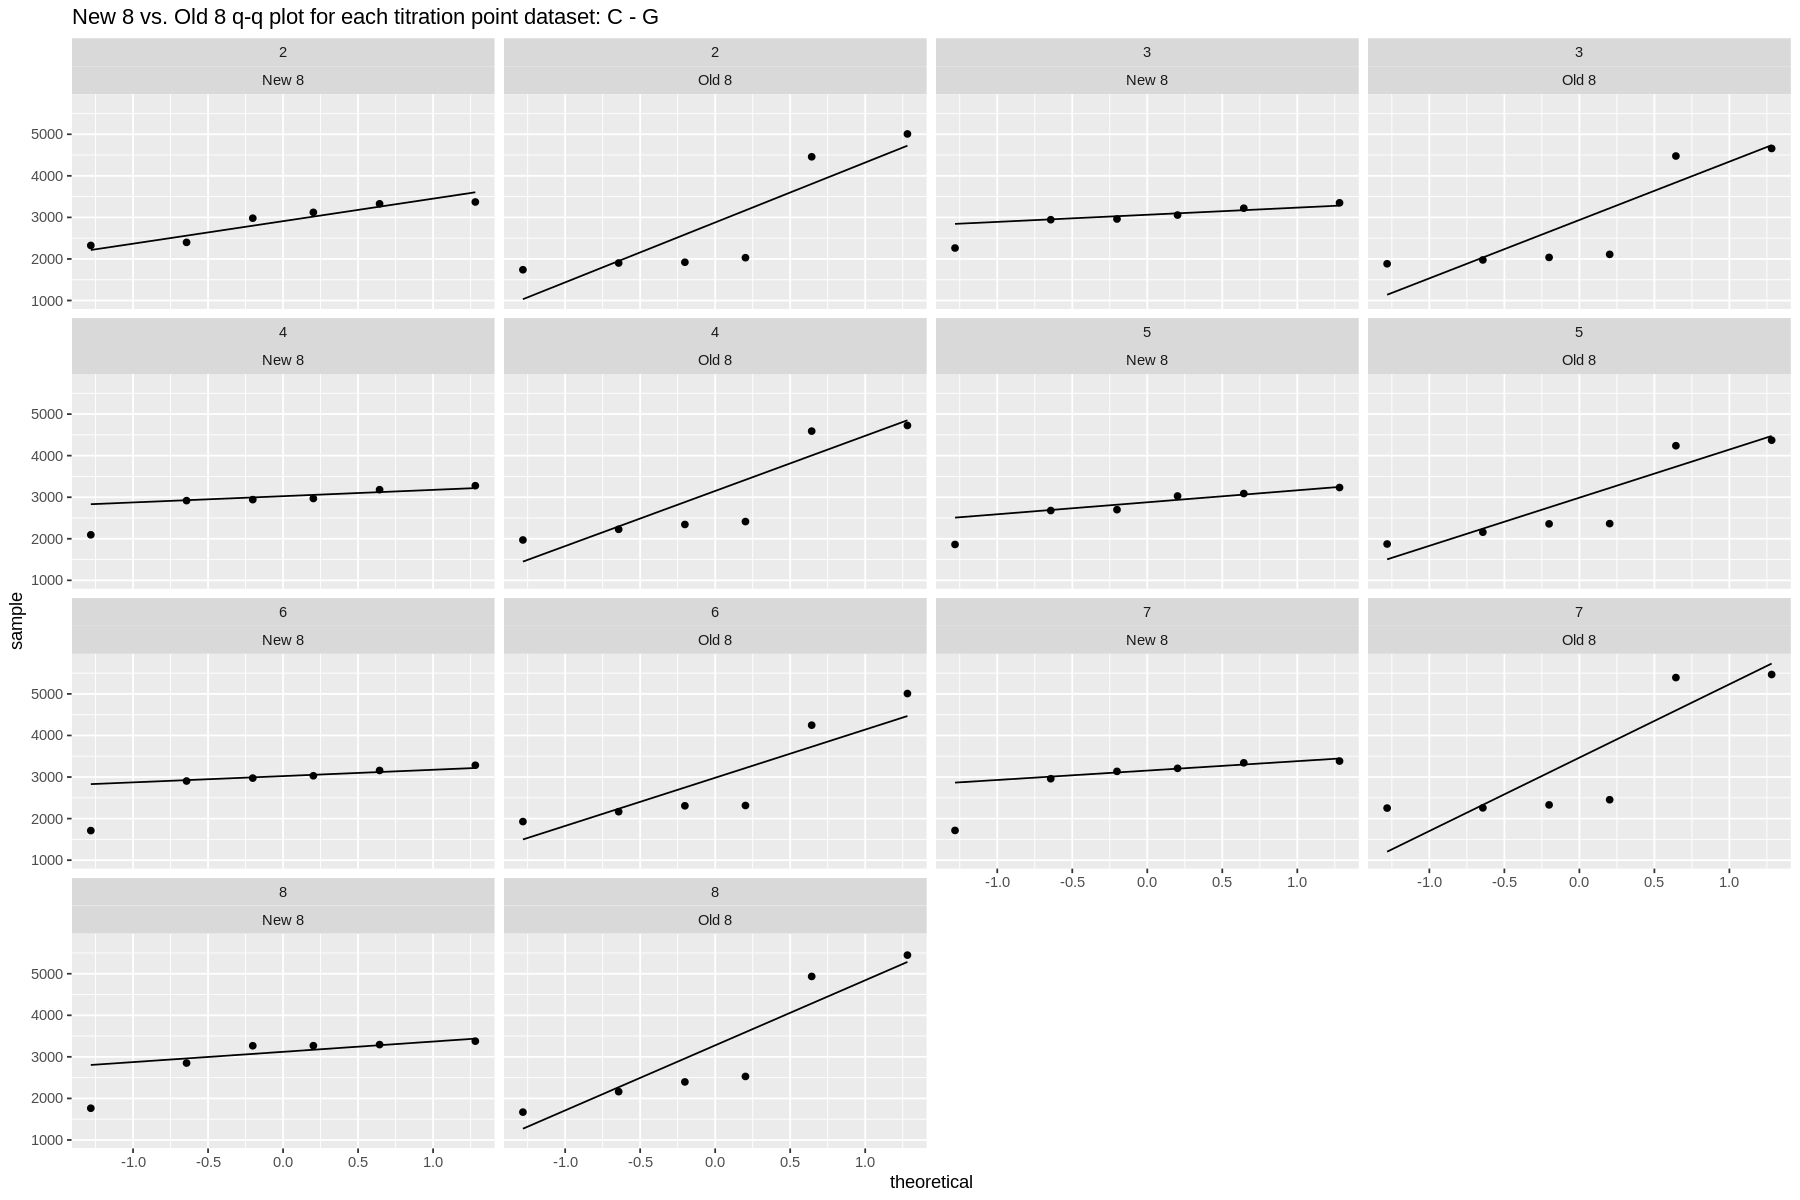

In [107]:
p_qq_cnt_ls[[3]]

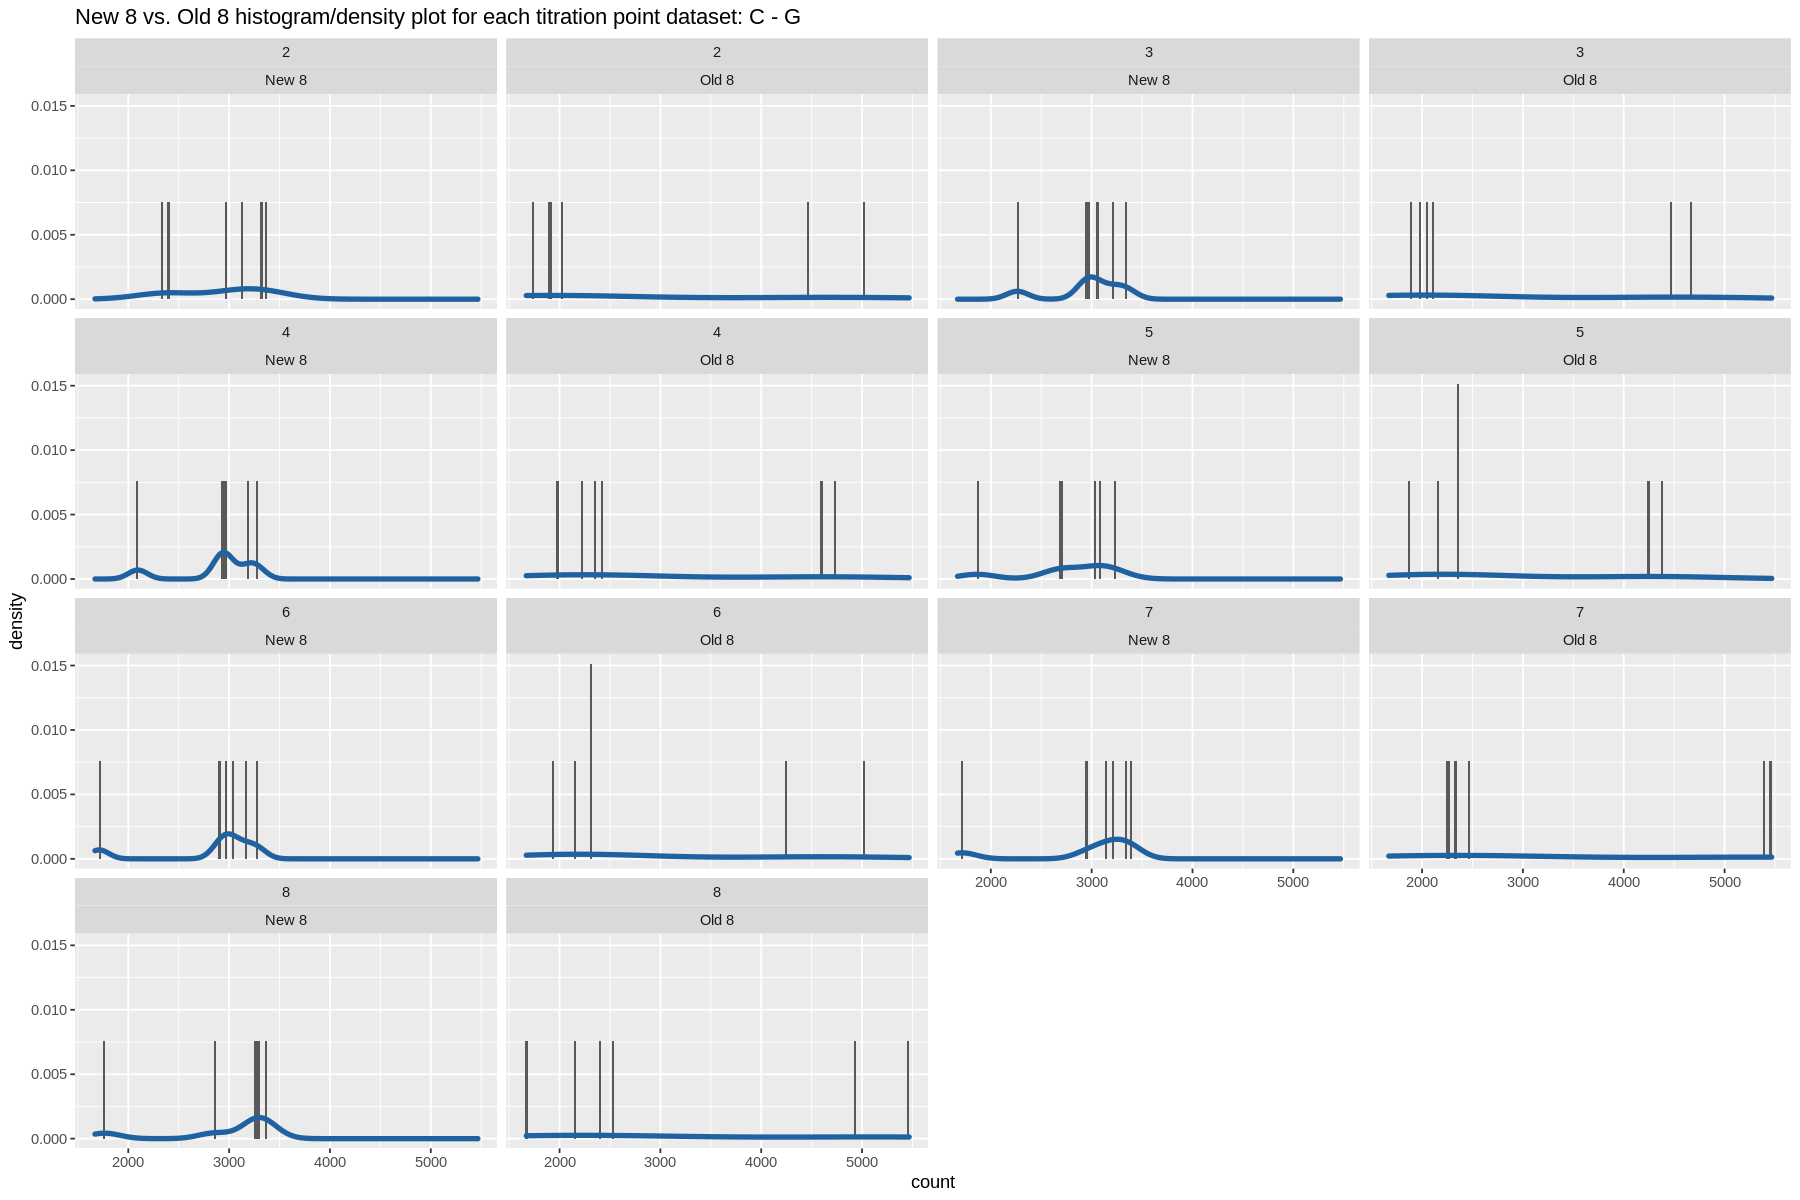

In [109]:
p_hst_cnt_ls[[3]]

In [110]:
# D-H
idx = c(4,8,12)
j = 4
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
p_qq_cnt_ls <- list()
p_hst_cnt_ls <- list()

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
}

dfo <- do.call(rbind, dfo)
dfn <- do.call(rbind, dfn)
df.t <- rbind(dfo, dfn)

p_qq_cnt_ls[[j]] <- ggplot(df.t, aes(sample = count)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(column~ method) +
            ggtitle(paste("New 8 vs. Old 8 q-q plot for each titration point dataset:", pat1, "-", pat2))

p_hst_cnt_ls[[j]] <- ggplot(data = df.t, aes(x = count)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(column~ method) +
    ggtitle(paste("New 8 vs. Old 8 histogram/density plot for each titration point dataset:", pat1, "-", pat2))

[1] "D - H old vs. new"
[1] "D2 - H2"
[1] "D3 - H3"
[1] "D4 - H4"
[1] "D5 - H5"
[1] "D6 - H6"
[1] "D7 - H7"
[1] "D8 - H8"


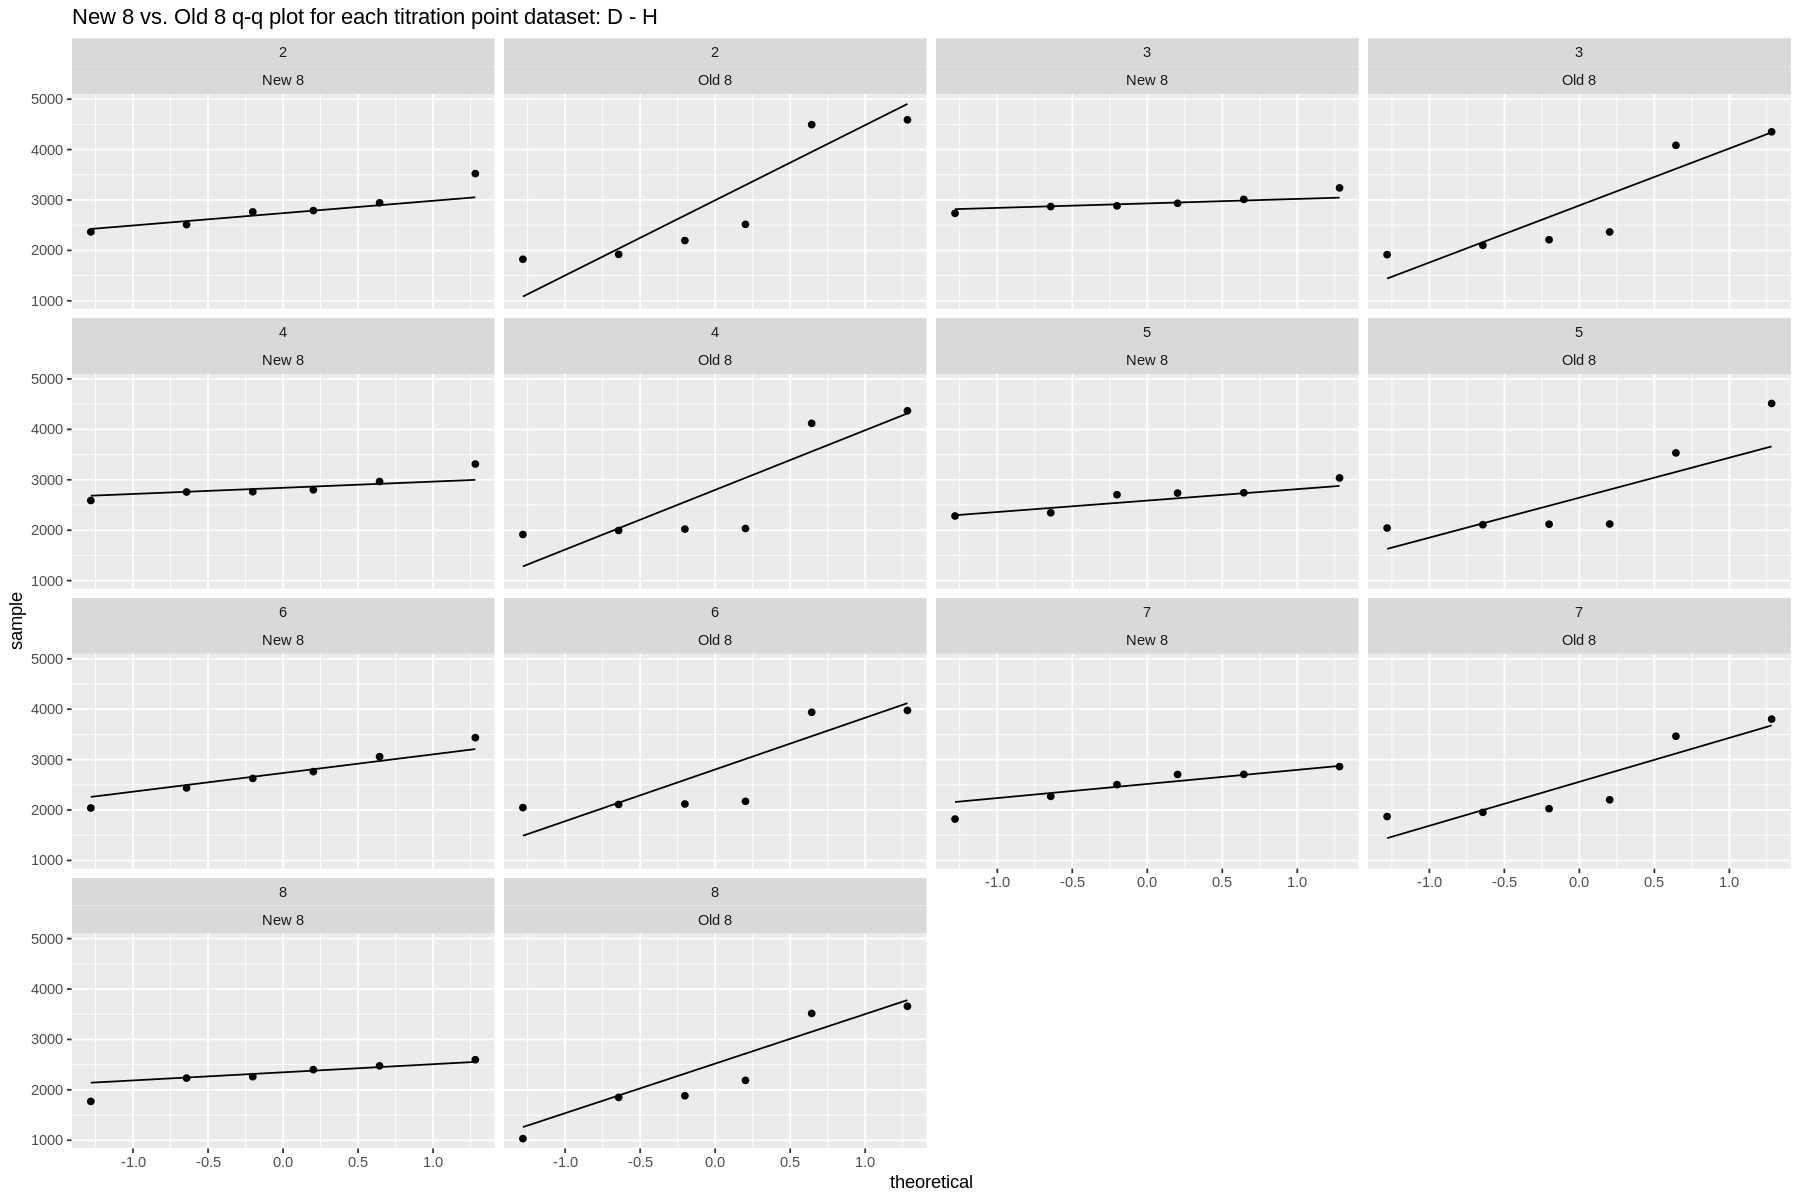

In [111]:
p_qq_cnt_ls[[4]]

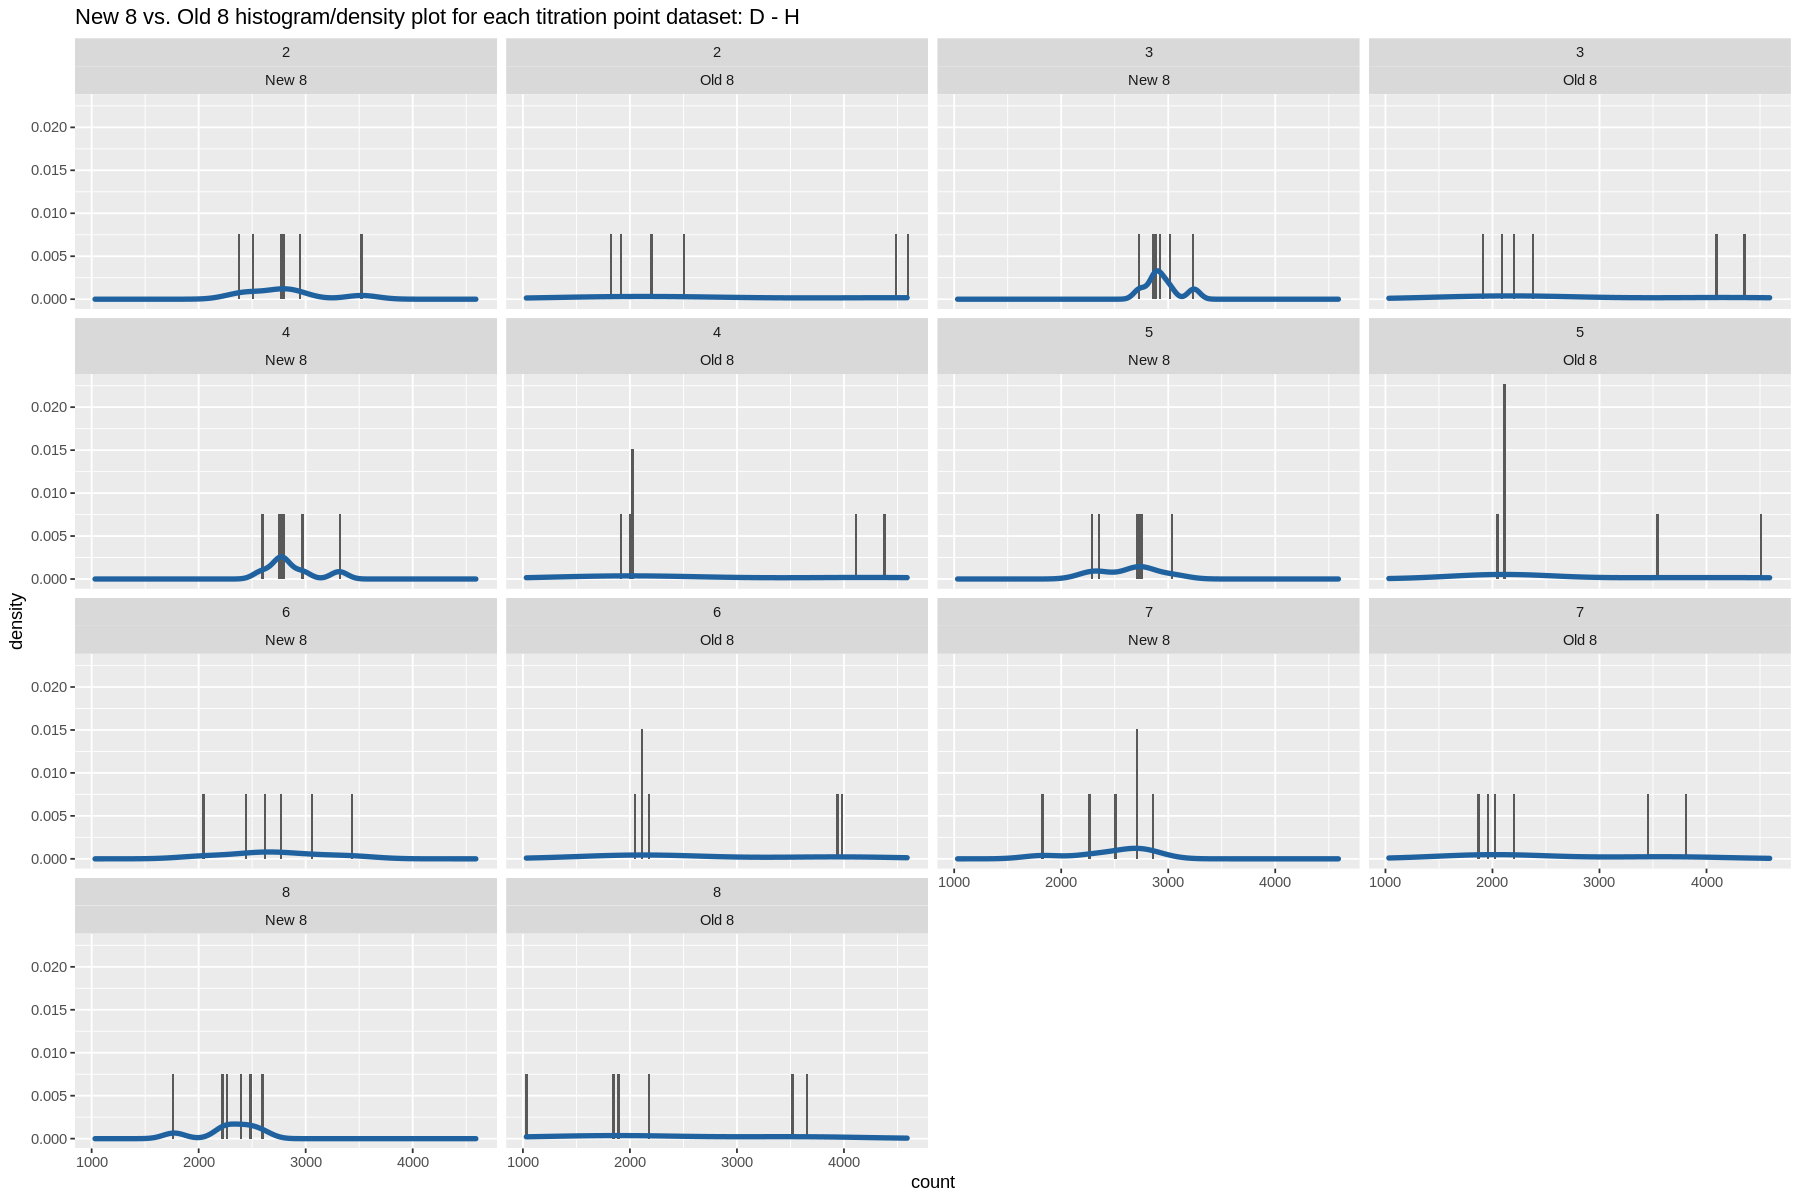

In [112]:
p_hst_cnt_ls[[4]]

In [91]:
p_qq_new8 <- list()
p_qq_old8 <- list()
p_hst_new8_cnt <- list()
p_hst_old8_cnt <- list()
df_pair_new8_cnt <- list()
df_pair_old8_cnt <- list()
start_seq <- seq(1,12,4)

for (i in seq(3)) {
    k = start_seq[i]
    df <- rbind(dfn_sub_ls[[k]],dfn_sub_ls[[k+1]],dfn_sub_ls[[k+2]],dfn_sub_ls[[k+3]]) %>% 
          mutate(grp = case_when(
                Y == "A" ~ "A-E",
                Y == "B" ~ "B-F",
                Y == "C" ~ "C-G",
                Y == "D" ~ "D-H",
                Y == "E" ~ "A-E",
                Y == "F" ~ "B-F",
                Y == "G" ~ "C-G",
                Y == "H" ~ "D-H"
            ))
    df_pair_new8_cnt[[i]] <- df
    p_qq_new8[[i]] <- ggplot(df, aes(sample = Z)) + 
                    stat_qq() + 
                    stat_qq_line() +
                    facet_wrap(~ grp)
    
    p_hst_new8_cnt[[i]] <- ggplot(data = df, aes(x = Z)) +
        geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
        geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
        facet_wrap(~ grp)
    
    df <- rbind(dfo_sub_ls[[k]],dfo_sub_ls[[k+1]],dfo_sub_ls[[k+2]],dfo_sub_ls[[k+3]]) %>% 
          mutate(grp = case_when(
                Y == "A" ~ "A-E",
                Y == "B" ~ "B-F",
                Y == "C" ~ "C-G",
                Y == "D" ~ "D-H",
                Y == "E" ~ "A-E",
                Y == "F" ~ "B-F",
                Y == "G" ~ "C-G",
                Y == "H" ~ "D-H"
            ))
    
    df_pair_old8_cnt[[i]] <- df
    p_qq_old8[[i]] <- ggplot(df, aes(sample = Z)) + 
                    stat_qq() + 
                    stat_qq_line() +
                    facet_wrap(~ grp)
    
    p_hst_old8_cnt[[i]] <- ggplot(data = df, aes(x = Z)) +
        geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
        geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
        facet_wrap(~ grp)
    }

### Wilcoxon rank test

- check that the median of pairwise differences is different 
- non-parametric statistical test to compare 2 related samples, matched samples or repeated measurements on single sample to assess whether their population mean ranks differ 
- an alternative to t-test; this is when we can't assume the two populatios are normally distributed; determine wheterh two dependent samples were selected from populations have the same distribution
- analysis below shows using both wilcox and t-test the sample mean for intra-plate is very different
- assume not normal distribution

#### t test for new vs old plate sets
- check mean sample difference between two datasets
- requires normal and linear data

###### info
- the data will output 8 wilcoxon and t-test results for each titration point across 3 plates totalling to 6 per group since there are 2 data points per plate 

In [14]:
# print helper function
prnt_wt_test <- function(dfo, dfn) {
    stat <- wilcox.test(x = dfo %>% 
                        select(count) %>%
                        pull(), 
                    y = dfn %>%
                        select(count) %>%
                        pull(), 
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 
    print(stat)
    stat2 <- t.test(x = dfo %>% 
                        select(count) %>%
                        pull(), 
                    y = dfn %>%
                        select(count) %>%
                        pull(), 
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 
    return(list(stat, stat2))
        }

In [76]:
# A-E old 8 vs new 8
idx = c(1,5,9)
j = 1
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df_stats <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("WILCOXON_TEST", "T_TEST"))

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    stat_ls <- prnt_wt_test(dfo[[i-1]], dfn[[i-1]])
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}

write.csv(df_stats, paste0("8v8_stats2_", pat1, pat2,".csv"), row.names = FALSE)

[1] "A - E old vs. new"
[1] "A2 - E2"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "A3 - E3"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "A4 - E4"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 10, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0

[1] "A5 - E5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "A6 - E6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 11, p

Warning message in wilcox.test.default(x = dfo %>% select(count) %>% pull(), y = dfn %>% :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 11, p-value = 0.2971
alternative hypothesis: true location shift is not equal to 0

[1] "A8 - E8"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



In [79]:
# B-F old 8 vs new 8

idx = c(2,6,10)
j = 2
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    stat_ls <- prnt_wt_test(dfo[[i-1]], dfn[[i-1]])
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_", pat1, pat2,".csv"), row.names = FALSE)

[1] "B - F old vs. new"
[1] "B2 - F2"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "B3 - F3"


Warning message in wilcox.test.default(x = dfo %>% select(count) %>% pull(), y = dfn %>% :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3776
alternative hypothesis: true location shift is not equal to 0

[1] "B4 - F4"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "B5 - F5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "B6 - F6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "B7 - F7"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
a

In [78]:
# C-G old 8 vs new 8
idx = c(3,7,11)
j = 3
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    stat_ls <- prnt_wt_test(dfo[[i-1]], dfn[[i-1]])
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_", pat1, pat2,".csv"), row.names = FALSE)

[1] "C - G old vs. new"
[1] "C2 - G2"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "C3 - G3"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "C4 - G4"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 15, p-value = 0.6991
alternative hypothesis: true location shift is not equal to 0

[1] "C5 - G5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 16, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0

[1] "C6 - G6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 16, p

In [77]:
# D-H old 8 vs new 8
idx = c(4,8,12)
j = 4
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    stat_ls <- prnt_wt_test(dfo[[i-1]], dfn[[i-1]])
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_", pat1, pat2,".csv"), row.names = FALSE)

[1] "D - H old vs. new"
[1] "D2 - H2"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0

[1] "D3 - H3"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "D4 - H4"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "D5 - H5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0

[1] "D6 - H6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 16, p

#### Box plots for n=3 plates

[1] "New 8 vs. Old 8 rows: D - H"


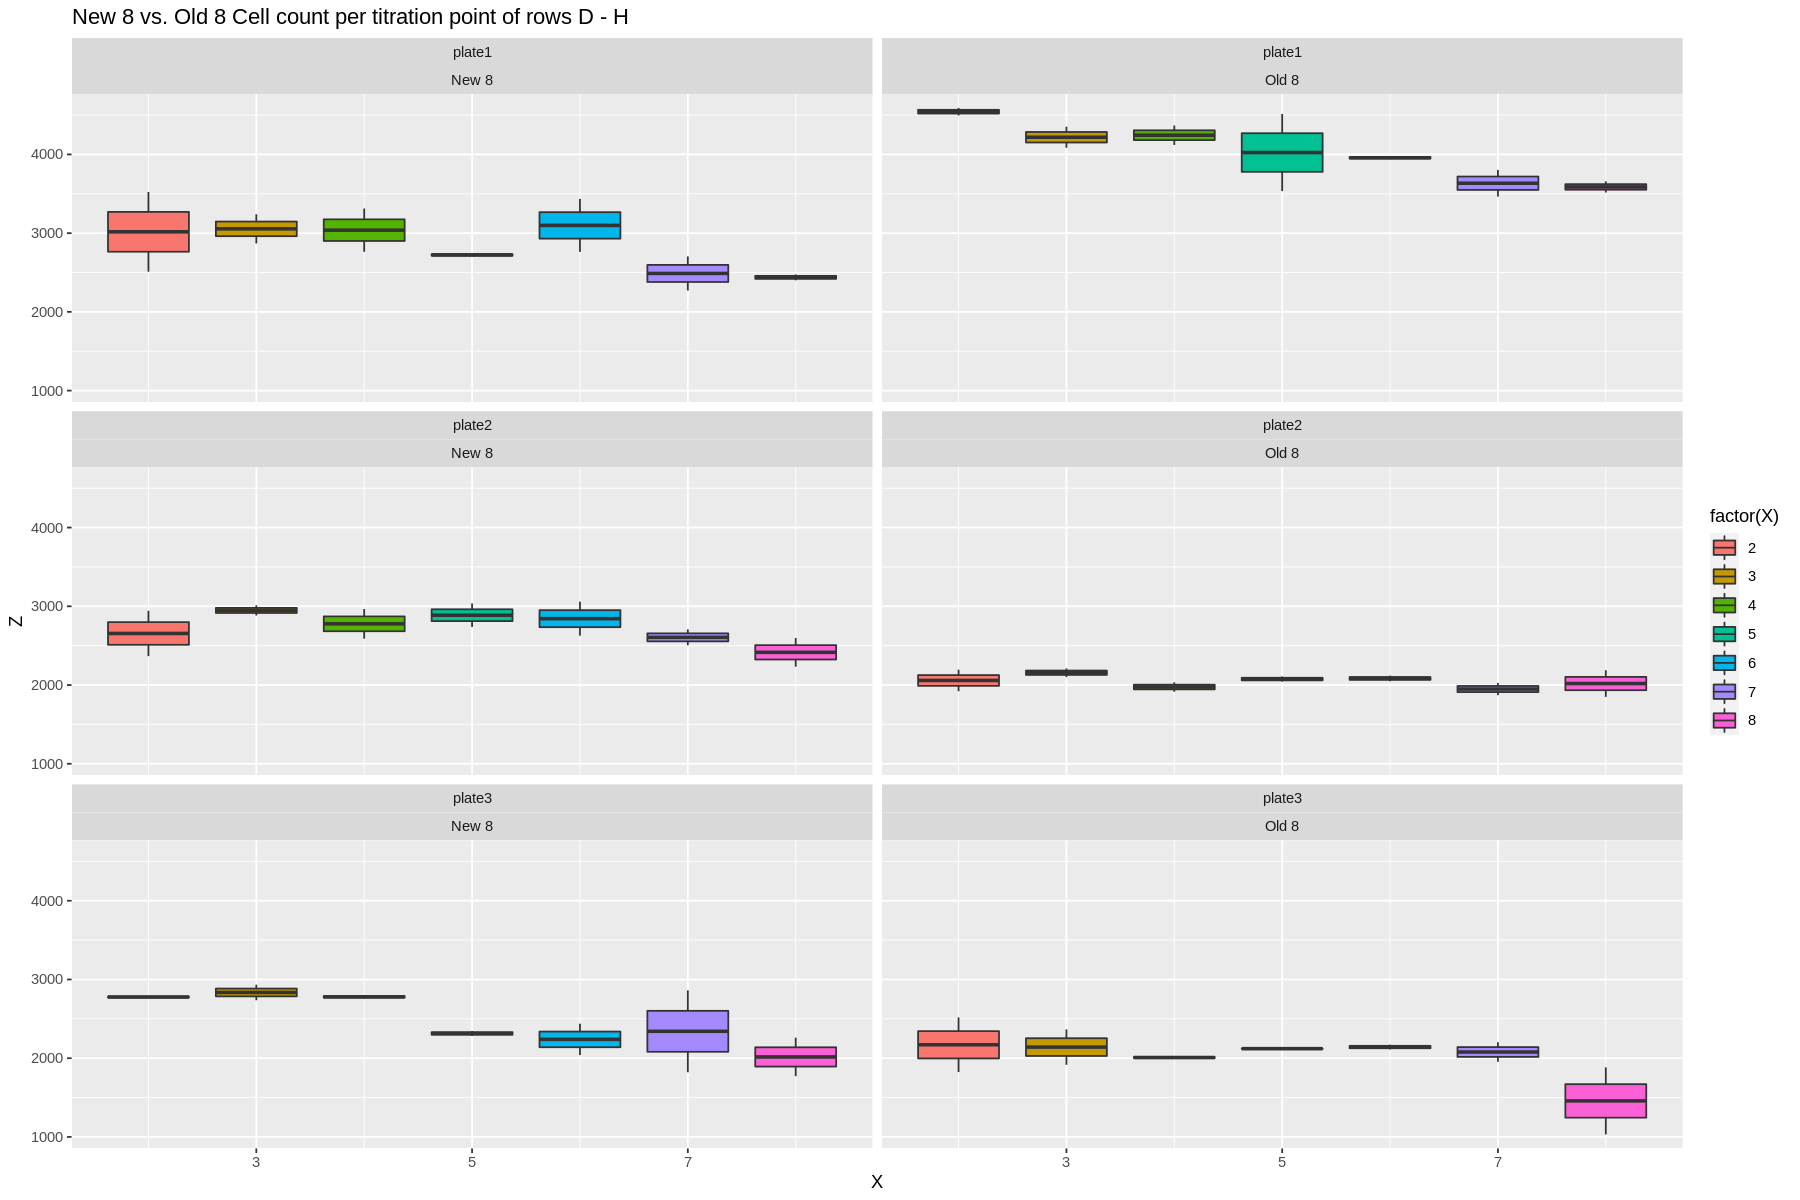

In [692]:
# D-H old 8 vs new 8
idx = c(4,8,12)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste("New 8 vs. Old 8 rows:", pat1, "-", pat2))

dff <- bind_rows(df.old, df.new)  %>% filter(Y == pat1 | Y == pat2)

ggplot(dff, aes(x=X,y=Z, group = X, fill = factor(X))) +
  geom_boxplot() + 
  labs(title=paste("New 8 vs. Old 8 Cell count per titration point of rows", pat1, "-", pat2)) +
  facet_wrap(plate~method, ncol = 2)

In [11]:
#df_boxp_new8_ls <- do.call(rbind, df_boxp_new8_ls) %>% 
#                    mutate(method = "New")
#
#df_boxp_old8_ls <- do.call(rbind, df_boxp_old8_ls) %>% 
#                    mutate(method = "Old")
#
#dff <- rbind(df_boxp_new8_ls, df_boxp_old8_ls)

[1] "New 8 vs. Old 8 rows: C - G"


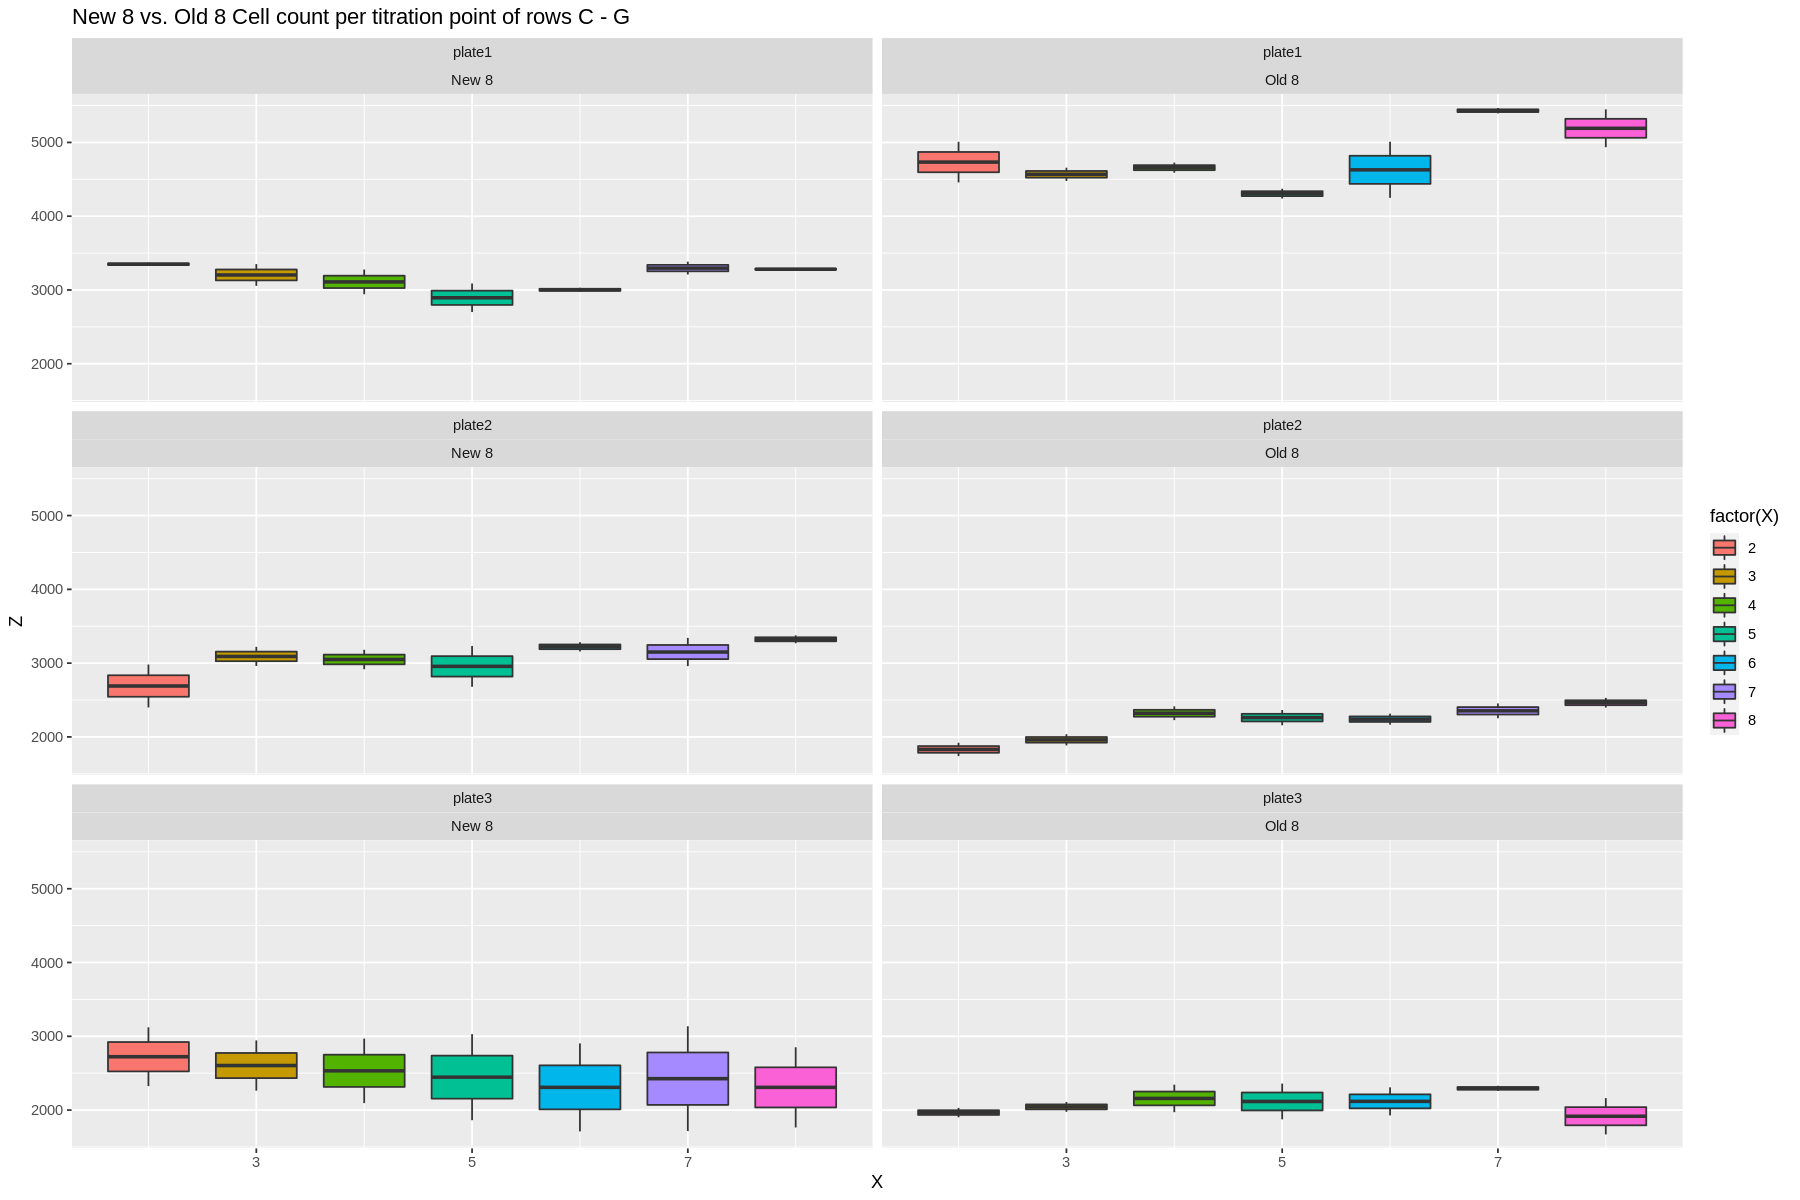

In [693]:
# C-G old 8 vs new 8
idx = c(3,7,11)
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste("New 8 vs. Old 8 rows:", pat1, "-", pat2))

dff <- bind_rows(df.old, df.new)  %>% filter(Y == pat1 | Y == pat2)

ggplot(dff, aes(x=X,y=Z, group = X, fill = factor(X))) +
  geom_boxplot() + 
  labs(title=paste("New 8 vs. Old 8 Cell count per titration point of rows", pat1, "-", pat2)) +
  facet_wrap(plate~method, ncol = 2)

[1] "New 8 vs. Old 8 rows: B - F"


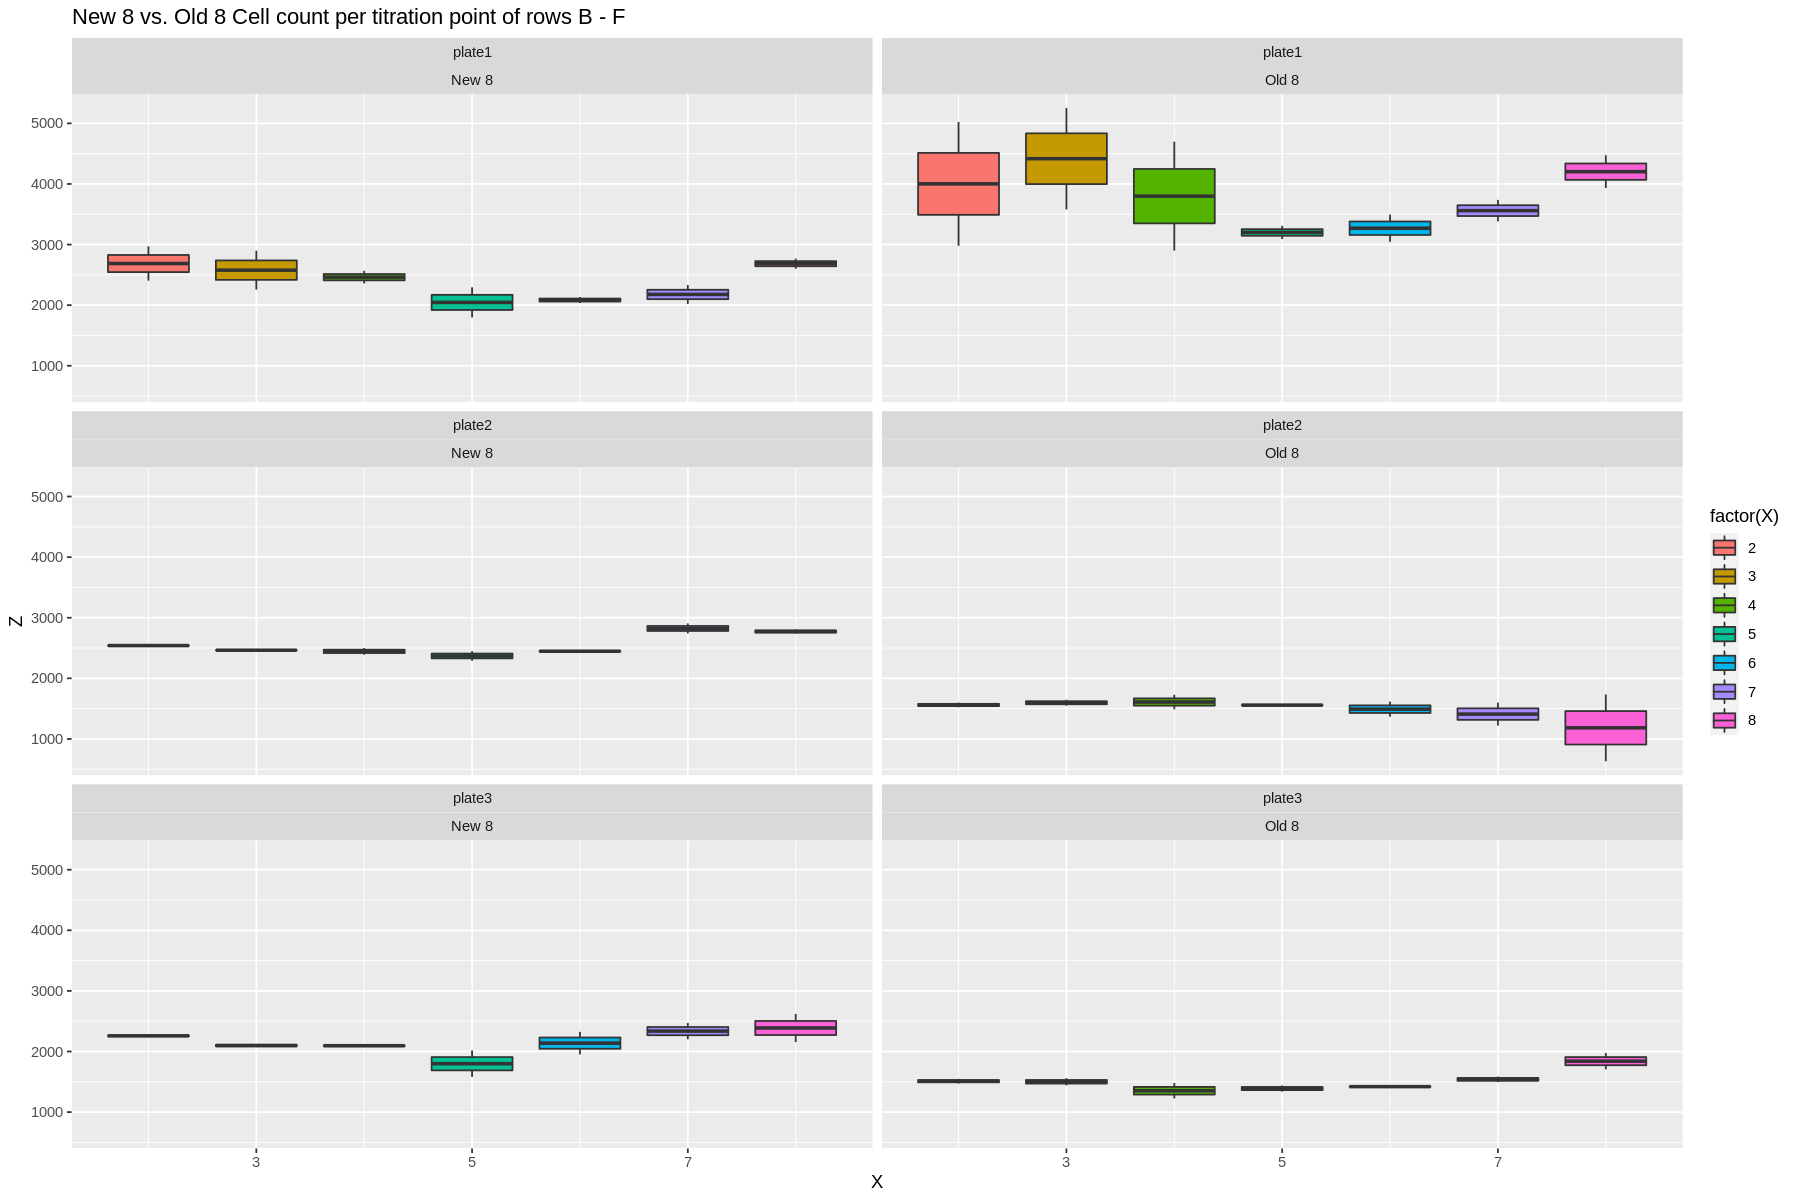

In [695]:
# B-F old 8 vs new 8
idx = c(2,6,10)
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste("New 8 vs. Old 8 rows:", pat1, "-", pat2))

dff <- bind_rows(df.old, df.new)  %>% filter(Y == pat1 | Y == pat2)

ggplot(dff, aes(x=X,y=Z, group = X, fill = factor(X))) +
  geom_boxplot() + 
  labs(title=paste("New 8 vs. Old 8 Cell count per titration point of rows", pat1, "-", pat2)) +
  facet_wrap(plate~method, ncol = 2)

[1] "New 8 vs. Old 8 rows: A - E"


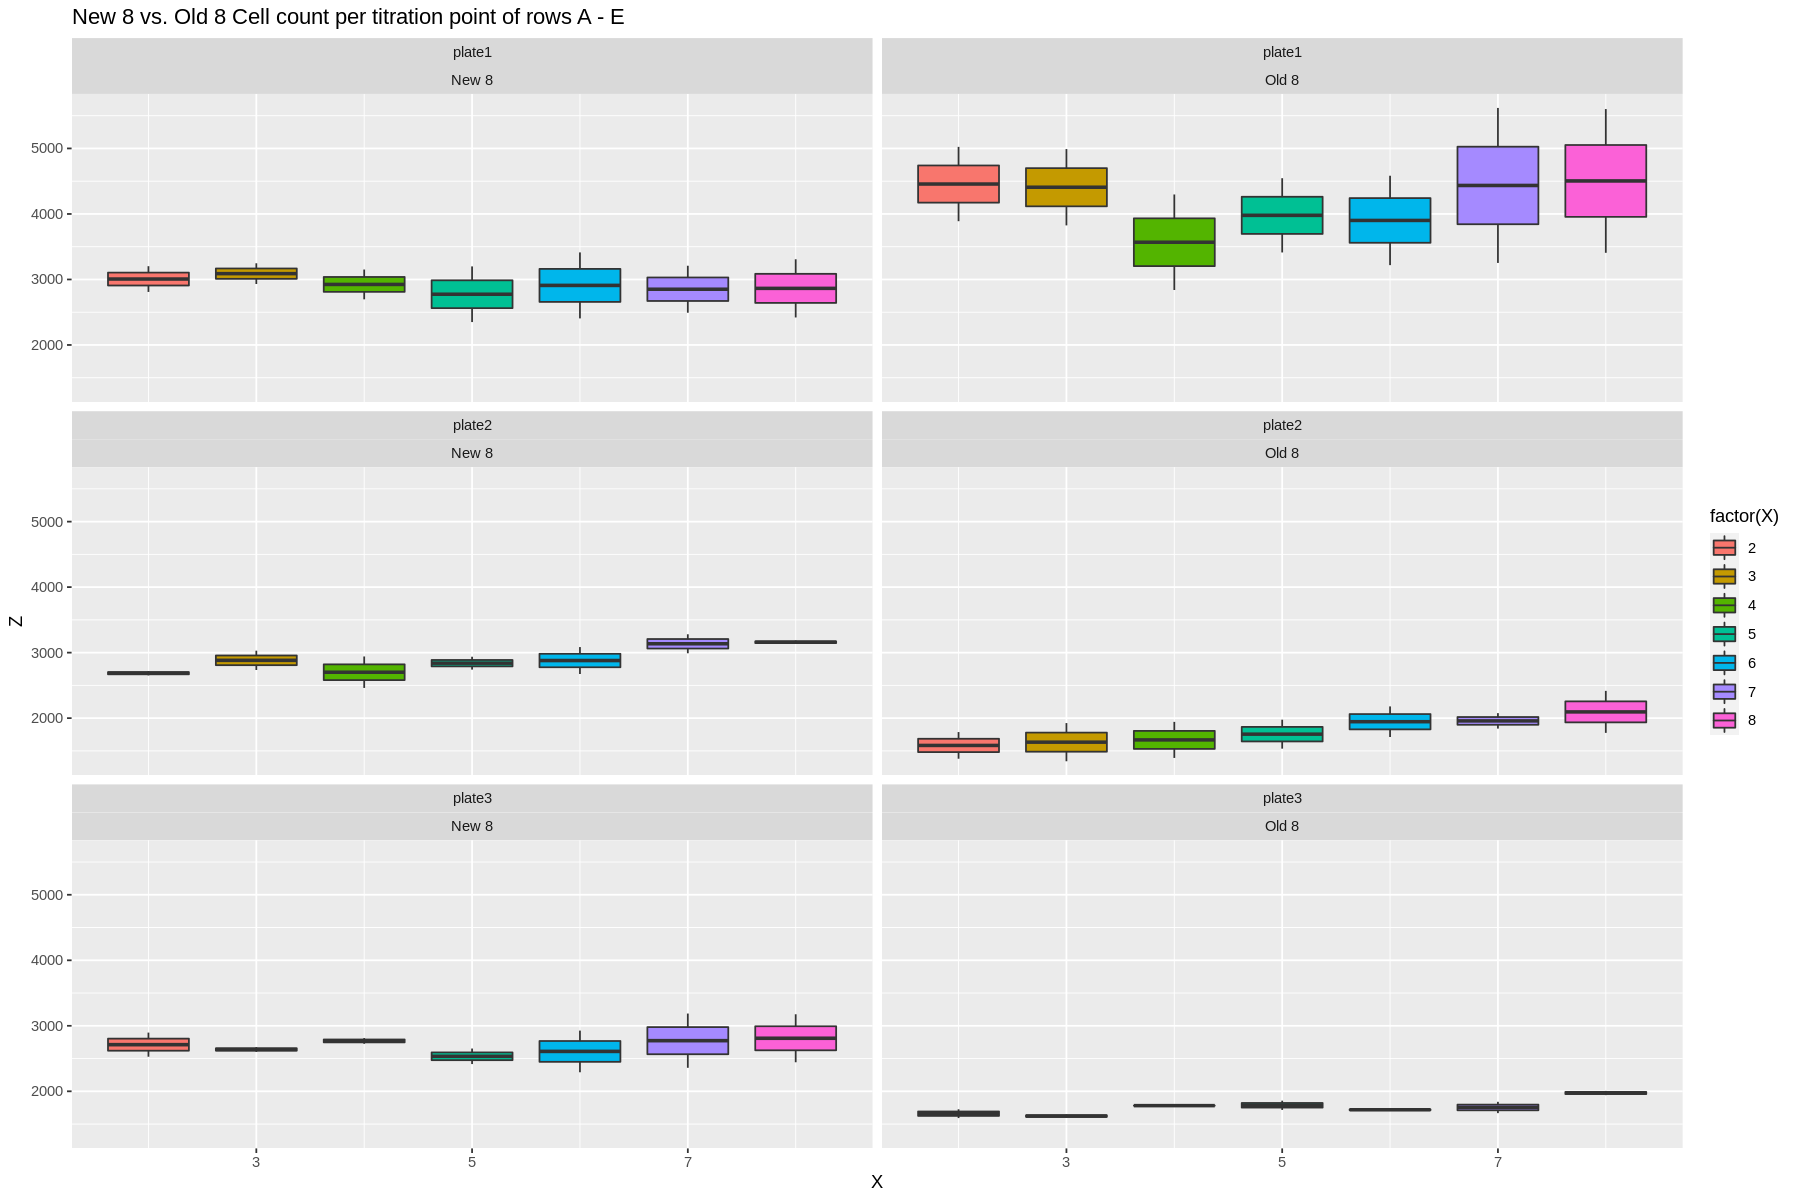

In [696]:
# A-E old 8 vs new 8
idx = c(1,5,9)
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste("New 8 vs. Old 8 rows:", pat1, "-", pat2))

dff <- bind_rows(df.old, df.new)  %>% filter(Y == pat1 | Y == pat2)

ggplot(dff, aes(x=X,y=Z, group = X, fill = factor(X))) +
  geom_boxplot() + 
  labs(title=paste("New 8 vs. Old 8 Cell count per titration point of rows", pat1, "-", pat2)) +
  facet_wrap(plate~method, ncol = 2)

#### Summary statistics for new 8 

In [713]:
# A-E new 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(1,5,9)
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

print(paste("New 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.new %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "New 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "New 8, 8 rows: A - E"
[1] "A / E : 2"
       Z       
 Min.   :2528  
 1st Qu.:2669  
 Median :2765  
 Mean   :2802  
 3rd Qu.:2874  
 Max.   :3203  
[1] "A / E : 3"
       Z       
 Min.   :2602  
 1st Qu.:2690  
 Median :2833  
 Mean   :2870  
 3rd Qu.:3005  
 Max.   :3247  
[1] "A / E : 4"
       Z       
 Min.   :2461  
 1st Qu.:2704  
 Median :2769  
 Mean   :2798  
 3rd Qu.:2909  
 Max.   :3152  
[1] "A / E : 5"
       Z       
 Min.   :2350  
 1st Qu.:2475  
 Median :2697  
 Mean   :2716  
 3rd Qu.:2888  
 Max.   :3200  
[1] "A / E : 6"
       Z       
 Min.   :2291  
 1st Qu.:2473  
 Median :2800  
 Mean   :2799  
 3rd Qu.:3046  
 Max.   :3413  
[1] "A / E : 7"
       Z       
 Min.   :2359  
 1st Qu.:2616  
 Median :3088  
 Mean   :2920  
 3rd Qu.:3204  
 Max.   :3280  
[1] "A / E : 8"
       Z       
 Min.   :2420  
 1st Qu.:2616  
 Median :3154  
 Mean   :2944  
 3rd Qu.:3183  
 Max.   :3308  


In [714]:
# A-E old 8
summary_ls <- list()
print('summary of each row pair data for old 8')
idx = c(1,5,9)
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste("Old 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.old %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "Old 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for old 8"
[1] "Old 8, 8 rows: A - E"
[1] "A / E : 2"
       Z       
 Min.   :1380  
 1st Qu.:1625  
 Median :1756  
 Mean   :2566  
 3rd Qu.:3364  
 Max.   :5024  
[1] "A / E : 3"
       Z       
 Min.   :1342  
 1st Qu.:1610  
 Median :1786  
 Mean   :2554  
 3rd Qu.:3350  
 Max.   :4991  
[1] "A / E : 4"
       Z       
 Min.   :1393  
 1st Qu.:1781  
 Median :1862  
 Mean   :2339  
 3rd Qu.:2615  
 Max.   :4298  
[1] "A / E : 5"
       Z       
 Min.   :1534  
 1st Qu.:1751  
 Median :1917  
 Mean   :2507  
 3rd Qu.:3053  
 Max.   :4546  
[1] "A / E : 6"
       Z       
 Min.   :1707  
 1st Qu.:1716  
 Median :1954  
 Mean   :2522  
 3rd Qu.:2959  
 Max.   :4583  
[1] "A / E : 7"
       Z       
 Min.   :1667  
 1st Qu.:1840  
 Median :1958  
 Mean   :2716  
 3rd Qu.:2958  
 Max.   :5618  
[1] "A / E : 8"
       Z       
 Min.   :1775  
 1st Qu.:1958  
 Median :2211  
 Mean   :2858  
 3rd Qu.:3159  
 Max.   :5601  


In [715]:
# B-F new 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(2,6,10)
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

print(paste("New 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.new %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "New 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "New 8, 8 rows: B - F"
[1] "B / F : 2"
       Z       
 Min.   :2244  
 1st Qu.:2306  
 Median :2470  
 Mean   :2495  
 3rd Qu.:2543  
 Max.   :2970  
[1] "B / F : 3"
       Z       
 Min.   :2075  
 1st Qu.:2156  
 Median :2360  
 Mean   :2380  
 3rd Qu.:2464  
 Max.   :2899  
[1] "B / F : 4"
       Z       
 Min.   :2082  
 1st Qu.:2170  
 Median :2373  
 Mean   :2334  
 3rd Qu.:2473  
 Max.   :2567  
[1] "B / F : 5"
       Z       
 Min.   :1579  
 1st Qu.:1852  
 Median :2154  
 Mean   :2071  
 3rd Qu.:2294  
 Max.   :2448  
[1] "B / F : 6"
       Z       
 Min.   :1952  
 1st Qu.:2060  
 Median :2229  
 Mean   :2223  
 3rd Qu.:2410  
 Max.   :2456  
[1] "B / F : 7"
       Z       
 Min.   :2022  
 1st Qu.:2234  
 Median :2402  
 Mean   :2446  
 3rd Qu.:2673  
 Max.   :2906  
[1] "B / F : 8"
       Z       
 Min.   :2156  
 1st Qu.:2605  
 Median :2679  
 Mean   :2615  
 3rd Qu.:2761  
 Max.   :2808  


In [716]:
# B-F old 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(2,6,10)
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste("Old 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.old %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "Old 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "Old 8, 8 rows: B - F"
[1] "B / F : 2"
       Z       
 Min.   :1472  
 1st Qu.:1530  
 Median :1574  
 Mean   :2358  
 3rd Qu.:2635  
 Max.   :5023  
[1] "B / F : 3"
       Z       
 Min.   :1441  
 1st Qu.:1551  
 Median :1604  
 Mean   :2505  
 3rd Qu.:3096  
 Max.   :5254  
[1] "B / F : 4"
       Z       
 Min.   :1225  
 1st Qu.:1482  
 Median :1610  
 Mean   :2254  
 3rd Qu.:2608  
 Max.   :4697  
[1] "B / F : 5"
       Z       
 Min.   :1337  
 1st Qu.:1470  
 Median :1558  
 Mean   :2049  
 3rd Qu.:2708  
 Max.   :3309  
[1] "B / F : 6"
       Z       
 Min.   :1366  
 1st Qu.:1418  
 Median :1522  
 Mean   :2060  
 3rd Qu.:2689  
 Max.   :3493  
[1] "B / F : 7"
       Z       
 Min.   :1220  
 1st Qu.:1517  
 Median :1594  
 Mean   :2170  
 3rd Qu.:2936  
 Max.   :3738  
[1] "B / F : 8"
       Z       
 Min.   : 632  
 1st Qu.:1713  
 Median :1855  
 Mean   :2409  
 3rd Qu.:3444  
 Max.   :4473  


In [718]:
# C-G new 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(3,7,11)
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

print(paste("New 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.new %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "New 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "New 8, 8 rows: C - G"
[1] "C / G : 2"
       Z       
 Min.   :2325  
 1st Qu.:2544  
 Median :3051  
 Mean   :2921  
 3rd Qu.:3276  
 Max.   :3371  
[1] "C / G : 3"
       Z       
 Min.   :2263  
 1st Qu.:2948  
 Median :3008  
 Mean   :2966  
 3rd Qu.:3180  
 Max.   :3351  
[1] "C / G : 4"
       Z       
 Min.   :2095  
 1st Qu.:2924  
 Median :2956  
 Mean   :2897  
 3rd Qu.:3128  
 Max.   :3277  
[1] "C / G : 5"
       Z       
 Min.   :1863  
 1st Qu.:2684  
 Median :2864  
 Mean   :2765  
 3rd Qu.:3073  
 Max.   :3233  
[1] "C / G : 6"
       Z       
 Min.   :1711  
 1st Qu.:2922  
 Median :3002  
 Mean   :2844  
 3rd Qu.:3126  
 Max.   :3284  
[1] "C / G : 7"
       Z       
 Min.   :1715  
 1st Qu.:3003  
 Median :3172  
 Mean   :2958  
 3rd Qu.:3309  
 Max.   :3384  
[1] "C / G : 8"
       Z       
 Min.   :1764  
 1st Qu.:2955  
 Median :3268  
 Mean   :2970  
 3rd Qu.:3288  
 Max.   :3377  


In [717]:
# C-G old 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(3,7,11)
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste("Old 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.old %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "Old 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "Old 8, 8 rows: C - G"
[1] "C / G : 2"
       Z       
 Min.   :1740  
 1st Qu.:1907  
 Median :1976  
 Mean   :2843  
 3rd Qu.:3851  
 Max.   :5008  
[1] "C / G : 3"
       Z       
 Min.   :1884  
 1st Qu.:1991  
 Median :2074  
 Mean   :2857  
 3rd Qu.:3885  
 Max.   :4658  
[1] "C / G : 4"
       Z       
 Min.   :1971  
 1st Qu.:2256  
 Median :2379  
 Mean   :3045  
 3rd Qu.:4046  
 Max.   :4726  
[1] "C / G : 5"
       Z       
 Min.   :1874  
 1st Qu.:2208  
 Median :2362  
 Mean   :2894  
 3rd Qu.:3770  
 Max.   :4372  
[1] "C / G : 6"
       Z       
 Min.   :1928  
 1st Qu.:2202  
 Median :2312  
 Mean   :2996  
 3rd Qu.:3765  
 Max.   :5009  
[1] "C / G : 7"
       Z       
 Min.   :2253  
 1st Qu.:2276  
 Median :2392  
 Mean   :3359  
 3rd Qu.:4658  
 Max.   :5467  
[1] "C / G : 8"
       Z       
 Min.   :1670  
 1st Qu.:2222  
 Median :2463  
 Mean   :3190  
 3rd Qu.:4334  
 Max.   :5448  


In [719]:
# D-H new 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(4,8,12)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

print(paste("New 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.new %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "New 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "New 8, 8 rows: D - H"
[1] "D / H : 2"
       Z       
 Min.   :2367  
 1st Qu.:2574  
 Median :2777  
 Mean   :2816  
 3rd Qu.:2905  
 Max.   :3523  
[1] "D / H : 3"
       Z       
 Min.   :2736  
 1st Qu.:2872  
 Median :2908  
 Mean   :2946  
 3rd Qu.:2992  
 Max.   :3240  
[1] "D / H : 4"
       Z       
 Min.   :2589  
 1st Qu.:2759  
 Median :2782  
 Mean   :2865  
 3rd Qu.:2925  
 Max.   :3313  
[1] "D / H : 5"
       Z       
 Min.   :2282  
 1st Qu.:2436  
 Median :2720  
 Mean   :2642  
 3rd Qu.:2742  
 Max.   :3037  
[1] "D / H : 6"
       Z       
 Min.   :2040  
 1st Qu.:2485  
 Median :2694  
 Mean   :2727  
 3rd Qu.:2985  
 Max.   :3435  
[1] "D / H : 7"
       Z       
 Min.   :1821  
 1st Qu.:2329  
 Median :2604  
 Mean   :2478  
 3rd Qu.:2706  
 Max.   :2862  
[1] "D / H : 8"
       Z       
 Min.   :1771  
 1st Qu.:2240  
 Median :2331  
 Mean   :2290  
 3rd Qu.:2457  
 Max.   :2598  


In [720]:
# D-H old 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(4,8,12)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8")

print(paste("Old 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.old %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "Old 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "Old 8, 8 rows: D - H"
[1] "D / H : 2"
       Z       
 Min.   :1824  
 1st Qu.:1990  
 Median :2356  
 Mean   :2924  
 3rd Qu.:4000  
 Max.   :4590  
[1] "D / H : 3"
       Z       
 Min.   :1916  
 1st Qu.:2128  
 Median :2288  
 Mean   :2838  
 3rd Qu.:3654  
 Max.   :4352  
[1] "D / H : 4"
       Z       
 Min.   :1915  
 1st Qu.:2002  
 Median :2028  
 Mean   :2742  
 3rd Qu.:3598  
 Max.   :4368  
[1] "D / H : 5"
       Z       
 Min.   :2043  
 1st Qu.:2112  
 Median :2121  
 Mean   :2740  
 3rd Qu.:3181  
 Max.   :4514  
[1] "D / H : 6"
       Z       
 Min.   :2048  
 1st Qu.:2113  
 Median :2146  
 Mean   :2728  
 3rd Qu.:3497  
 Max.   :3976  
[1] "D / H : 7"
       Z       
 Min.   :1871  
 1st Qu.:1972  
 Median :2115  
 Mean   :2554  
 3rd Qu.:3149  
 Max.   :3804  
[1] "D / H : 8"
       Z       
 Min.   :1032  
 1st Qu.:1858  
 Median :2036  
 Mean   :2354  
 3rd Qu.:3184  
 Max.   :3658  


In [104]:
# compare all plates for new and old 8 with true equal variance on each row pair
# combining all pairs (6 groups each parametere/fluorochrome) 3*2
ttest_ls <- list()
print("ALL PLATS new vs old")

idx = c(4,8,12)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8")

print(paste("New 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.new %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "New 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }
gen_vtr <- function(pat) {
    vn <- df_pair_new8_cnt[[3]] %>% 
        filter(grp == pat) %>% 
        select(Z) %>% 
        bind_rows(
            df_pair_new8_cnt[[2]] %>%
            filter(grp== pat) %>%
            select(Z)
        ) %>%
        bind_rows(
            df_pair_new8_cnt[[1]] %>%
            filter(grp== pat) %>%
            select(Z)
        ) %>% 
        pull()

    vo <- df_pair_old8_cnt[[3]] %>% 
        filter(grp == pat) %>% 
        select(Z) %>% 
        bind_rows(
            df_pair_old8_cnt[[2]] %>%
            filter(grp== pat) %>%
            select(Z)
        ) %>%
        bind_rows(
            df_pair_old8_cnt[[1]] %>%
            filter(grp== pat) %>%
            select(Z) 
        ) %>% 
        pull()
    
        return(list(vn,vo))
}

for (i in seq(4)) {
    pat = paste0(rows[[i]][1], '-', rows[[i]][2])
    v_ls <- gen_vtr(pat)
    print(pat)
    ttest_ls[[i]] <- t.test(x = v_ls[[1]], # new 
                            y = v_ls[[2]], # old
                            alternative = "two.sided",
                            paired = FALSE, var.equal = TRUE,
                            conf.level = 0.95) 
    print(ttest_ls[[i]])
    }

[1] "ALL PLATS new vs old"
[1] "A-E"

	Two Sample t-test

data:  v_ls[[1]] and v_ls[[2]]
t = 1.2662, df = 82, p-value = 0.209
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -145.8037  656.4227
sample estimates:
mean of x mean of y 
 2835.571  2580.262 

[1] "B-F"

	Two Sample t-test

data:  v_ls[[1]] and v_ls[[2]]
t = 0.57308, df = 82, p-value = 0.5682
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -268.2504  485.3457
sample estimates:
mean of x mean of y 
 2366.381  2257.833 

[1] "C-G"

	Two Sample t-test

data:  v_ls[[1]] and v_ls[[2]]
t = -0.57841, df = 82, p-value = 0.5646
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -548.3577  301.3101
sample estimates:
mean of x mean of y 
 2902.929  3026.452 

[1] "D-H"

	Two Sample t-test

data:  v_ls[[1]] and v_ls[[2]]
t = -0.10128, df = 82, p-value = 0.9196
alternative hypothesis: tr

#### ANOVA test for each set of three plates
- Compute the analysis of variance for new 8 channel rows A-E
- Summary of the analysis
- As the p-value is less than the significance level 0.05, 
- we can conclude that there are significant differences between the 
- groups highlighted with “*" in the model summary
- In one-way ANOVA test, a significant p-value indicates that some of the group means are different, but we don’t know which pairs of groups are different.
- It’s possible to perform multiple pairwise-comparison, to determine if the mean difference between specific pairs of group are statistically significant.
- Use the Tukey to conduct this
- anova shows high p-value meaning all 12 rows in total are similar
- pairewise.t.test() can be also used to calculate pairwise comparisons 
- between group levels with corrections for multiple testing
- The result is a table of p-values for the pairwise comparisons. 
- Here, the p-values have been adjusted by the Benjamini-Hochberg method.

In [66]:
stat$p.value[[1]]

[1] 0.2244903

In [68]:
# A-E
idx = c(1,5,9)
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame() 

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8", anova = paste0(Y,X))

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8", anova = paste0(Y,X))

print(paste("ANOVA 8 rows:", pat1, "-", pat2))

dff <- rbind(df.old, df.new)

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% filter(X == i & (Y == pat1 | Y == pat2))
    res.aov <- aov(Z ~ anova, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$anova[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$Z, df.t$anova,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: A - E"
[1] "A / E : 2"
            Df   Sum Sq Mean Sq F value Pr(>F)
anova        1   143883  143883   0.122  0.734
Residuals   10 11758017 1175802               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
      diff       lwr      upr     p adj
E2-A2 -219 -1613.918 1175.918 0.7337333

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$Z and df.t$anova 

   A2  
E2 0.73

P value adjustment method: BH 
[1] "A / E : 3"
            Df   Sum Sq Mean Sq F value Pr(>F)
anova        1   417760  417760   0.368  0.557
Residuals   10 11337778 1133778               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
           diff      lwr      upr    p adj
E3-A3 -373.166

In [80]:
# B-F
idx = c(2,6,10)
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8", anova = paste0(Y,X))
df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8", anova = paste0(Y,X))
print(paste("ANOVA 8 rows:", pat1, "-", pat2))
dff <- rbind(df.old, df.new)
for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% filter(X == i & (Y == pat1 | Y == pat2))
    res.aov <- aov(Z ~ anova, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$anova[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$Z, df.t$anova,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: B - F"
[1] "B / F : 2"
            Df   Sum Sq Mean Sq F value Pr(>F)
anova        1   494508  494508   0.489    0.5
Residuals   10 10114611 1011461               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
      diff       lwr      upr    p adj
F2-B2 -406 -1699.767 887.7674 0.500356

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$Z and df.t$anova 

   B2 
F2 0.5

P value adjustment method: BH 
[1] "B / F : 3"
            Df   Sum Sq Mean Sq F value Pr(>F)
anova        1   473621  473621   0.381  0.551
Residuals   10 12418806 1241881               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
           diff       lwr      upr     p adj
F3-B3 -397.3333 

In [81]:
# C-G
idx = c(3,7,11)
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8", anova = paste0(Y,X))
df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8", anova = paste0(Y,X))
print(paste("ANOVA 8 rows:", pat1, "-", pat2))
dff <- rbind(df.old, df.new)
for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% filter(X == i & (Y == pat1 | Y == pat2))
    res.aov <- aov(Z ~ anova, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$anova[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$Z, df.t$anova,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: C - G"
[1] "C / G : 2"
            Df   Sum Sq Mean Sq F value Pr(>F)
anova        1    55897   55897   0.047  0.833
Residuals   10 11909350 1190935               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
       diff       lwr      upr     p adj
G2-C2 136.5 -1267.366 1540.366 0.8328406

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$Z and df.t$anova 

   C2  
G2 0.83

P value adjustment method: BH 
[1] "C / G : 3"
            Df  Sum Sq Mean Sq F value Pr(>F)
anova        1   47125   47125   0.049  0.828
Residuals   10 9525886  952589               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
          diff       lwr      upr     p adj
G3-C3 125.3333

In [82]:
# D-H
idx = c(4,8,12)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfn_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfn_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "New 8", anova = paste0(Y,X))
df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    bind_rows(
        dfo_sub_ls[[idx[2]]] %>% mutate(plate = paste0("plate", jj[2])) 
        ) %>%
    bind_rows(
        dfo_sub_ls[[idx[3]]] %>% mutate(plate = paste0("plate", jj[3]))
        ) %>%
    mutate(method = "Old 8", anova = paste0(Y,X))
print(paste("ANOVA 8 rows:", pat1, "-", pat2))
dff <- rbind(df.old, df.new)
for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% filter(X == i & (Y == pat1 | Y == pat2))
    res.aov <- aov(Z ~ anova, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$anova[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$Z, df.t$anova,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: D - H"
[1] "D / H : 2"
            Df  Sum Sq Mean Sq F value Pr(>F)
anova        1   17787   17787    0.02  0.891
Residuals   10 8987453  898745               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
      diff       lwr      upr    p adj
H2-D2   77 -1142.551 1296.551 0.890916

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$Z and df.t$anova 

   D2  
H2 0.89

P value adjustment method: BH 
[1] "D / H : 3"
            Df  Sum Sq Mean Sq F value Pr(>F)
anova        1   13736   13736   0.023  0.883
Residuals   10 6019636  601964               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
           diff      lwr      upr    p adj
H3-D3 -67.66667 -1065.

### "residuals versus fits plot" is the most frequently created plot. It is a scatter plot of residuals on the y axis and fitted values (estimated responses) on the x axis. The plot is used to detect non-linearity, unequal error variances, and outliers.

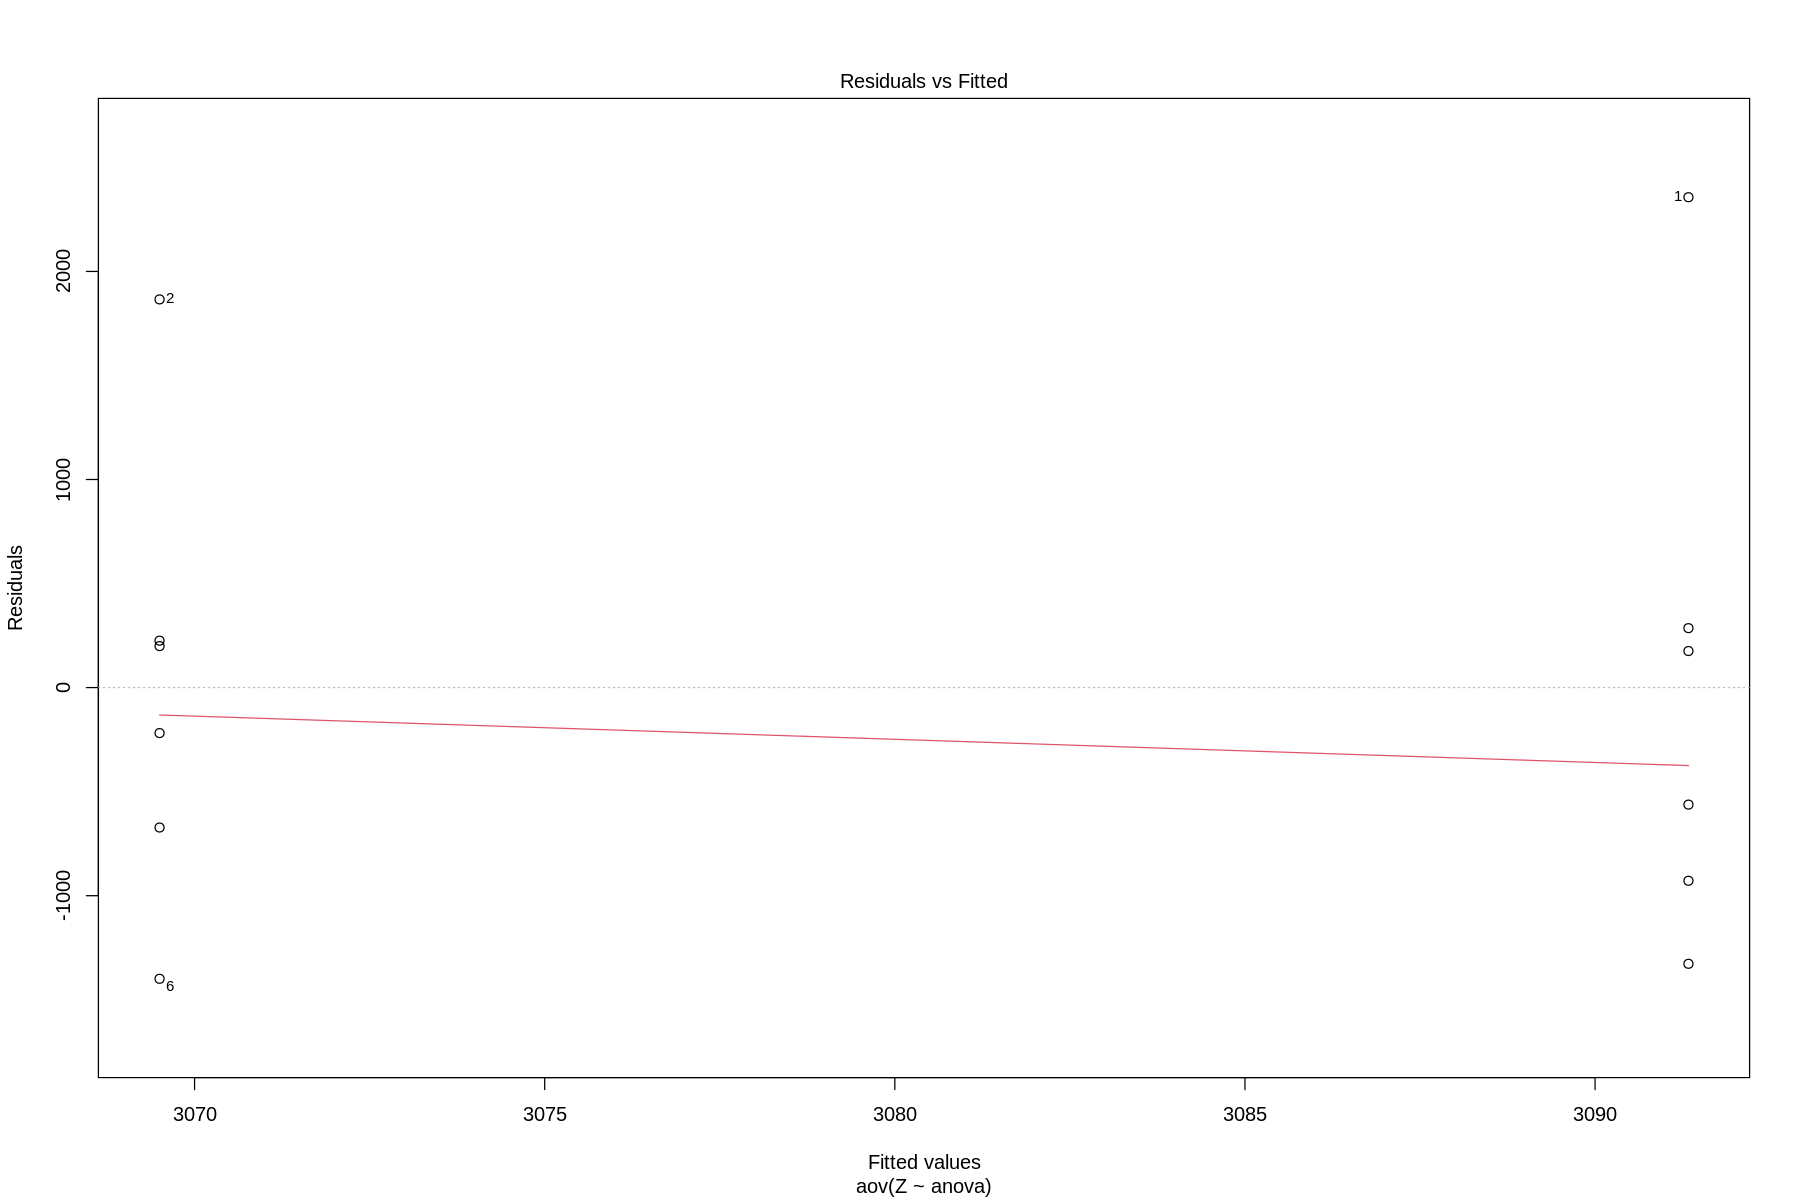

In [761]:
plot(res.aov, 1)

#### USE SI AS SAMPLE DATA

In [1]:
prm1<-"YG"
prm2<-"582"
title_hdrYG <- paste0("Lymphocytes.", prm1, ".", prm2, ".A....Median..", prm1, ".", prm2, ".A....null." )
prm1<-"V"
prm2<-"450"
title_hdrV <- paste0("Lymphocytes.", prm1, ".", prm2, ".A....Median..", prm1, ".", prm2, ".A....null." )

In [7]:
dfsi_new8 <- list()
dfsi_old8 <- list()
new8_file <- list.files(parentdir, pattern = "New 8*")
old8_file <- list.files(parentdir, pattern = "Old 8*")
for (i in seq(3)) {
    dfsi_new8[[i]] <- read.csv(paste0(parentdir, new8_file[i])) %>% 
                        na.omit() %>% select(Sample., 
                            Lymphocytes.V.450.A....Freq..of.Parent,
                            Lymphocytes.V.450.A....Median..V.450.A....null.,
                            Lymphocytes.V.450.A....Median..V.450.A....null..1,
                            Lymphocytes.V.450.A....Robust.SD..V.450.A....null.,
                            Stain.Index,
                            Signal.to.Noise) %>%
                        filter(grepl("[A-H]0[2-9]|1[0-1]", Sample.)) %>%
                        mutate_at(vars(Lymphocytes.V.450.A....Median..V.450.A....null., Stain.Index, Signal.to.Noise), funs(as.numeric))
    dfsi_old8[[i]] <- read.csv(paste0(parentdir, old8_file[i])) %>% 
                        na.omit() %>% 
                        filter(grepl("[A-H]0[2-9]|1[0-1]", Sample.)) %>%
                        mutate_at(vars(ifelse(i>1, !!title_hdrV, !!title_hdrYG), Stain.Index, Signal.to.Noise), funs(as.numeric))
    }

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [8]:
si.pos.new8 <- list()
si.pos.old8 <- list()

for (i in seq(3)) {
    si.pos.new8[[i]] <- dfsi_new8[[i]] %>% select(Stain.Index, Sample. ) %>% mutate(wellid = substr(Sample., 17,19), plate = paste("plate", i), method = "New 8")
    si.pos.old8[[i]] <- dfsi_old8[[i]] %>% select(Stain.Index, Sample. ) %>% mutate(wellid = substr(Sample., 17,19), plate = paste("plate", i), method = "Old 8")
    }

dfm <- do.call(rbind, si.pos.new8) %>% bind_rows(
        do.call(rbind, si.pos.old8)
        )

#### F test for normality
- The p values are big, meaning the variances do not change more from plate 1 to 3

#### Anderson-Darling test
- goodness of fit test that measures how well your data fit a specified distribution.
- H_0: The data follow a specified distribution

#### Shapiro test, bonett test, qq plot to show normality
- shapiro-wilk test - tell if a random sample comes from a normal distribution
- bonett test - measure of kurtosis for normally distributed data
- under the hypothesis of normality, data should have Geary's kurtosis equal to sqrt(2/pi) (0.7979)
- the kurtosis is near .7979, with p-value barely above 0.05, indicating it is slightly normal

In [86]:
# A-E new 8 vs old 8
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame()

for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dfm %>% filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i))
    print(paste0(rep("-", 25),collapse=""))
    stat <- var.test(Stain.Index ~ method, df.t)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- ad.test(df.t$Stain.Index)
    df_stats[i-1, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- shapiro.test(df.t$Stain.Index)
    df_stats[i-1, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- bonett.test(df.t$Stain.Index)
    df_stats[i-1, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    print("geary result:")
    stat <- geary(df.t$Stain.Index)
    df_stats[i-1, "GEARY"] = formatC(stat, format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "A / E : 2"
[1] "-------------------------"

	F test to compare two variances

data:  Stain.Index by method
F = 1.5362, num df = 5, denom df = 5, p-value = 0.6491
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
  0.2149604 10.9781937
sample estimates:
ratio of variances 
          1.536189 

[1] "-------------------------"

	Anderson-Darling normality test

data:  df.t$Stain.Index
A = 0.18652, p-value = 0.8818

[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.t$Stain.Index
W = 0.96471, p-value = 0.8484

[1] "-------------------------"

	Bonett-Seier test for Geary kurtosis

data:  df.t$Stain.Index
tau = 28.48611, z = -0.98273, p-value = 0.3257
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "-------------------------"
[1] "geary result:"
[1] 0.8557528
[1] "A / E : 3"
[1] "-------------------------"

	F test to compare two variances

data:  Stain.Index by method
F = 1.4692, num df = 5, denom d

In [87]:
# B-F new 8 vs old 8
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame()

for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dfm %>% filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i))
    print(paste0(rep("-", 25),collapse=""))
    stat <- var.test(Stain.Index ~ method, df.t)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- ad.test(df.t$Stain.Index)
    df_stats[i-1, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- shapiro.test(df.t$Stain.Index)
    df_stats[i-1, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- bonett.test(df.t$Stain.Index)
    df_stats[i-1, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    print("geary result:")
    stat <- geary(df.t$Stain.Index)
    df_stats[i-1, "GEARY"] = formatC(stat, format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "B / F : 2"
[1] "-------------------------"

	F test to compare two variances

data:  Stain.Index by method
F = 0.97858, num df = 5, denom df = 5, p-value = 0.9816
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.1369338 6.9933134
sample estimates:
ratio of variances 
          0.978581 

[1] "-------------------------"

	Anderson-Darling normality test

data:  df.t$Stain.Index
A = 0.3792, p-value = 0.3457

[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.t$Stain.Index
W = 0.94159, p-value = 0.5189

[1] "-------------------------"

	Bonett-Seier test for Geary kurtosis

data:  df.t$Stain.Index
tau = 7.27778, z = 0.14205, p-value = 0.887
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "-------------------------"
[1] "geary result:"
[1] 0.7899023
[1] "B / F : 3"
[1] "-------------------------"

	F test to compare two variances

data:  Stain.Index by method
F = 2.6397, num df = 5, denom df = 5

In [89]:
# C-G new 8 vs old 8
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame()

for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dfm %>% filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i))
    print(paste0(rep("-", 25),collapse=""))
    stat <- var.test(Stain.Index ~ method, df.t)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- ad.test(df.t$Stain.Index)
    df_stats[i-1, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- shapiro.test(df.t$Stain.Index)
    df_stats[i-1, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- bonett.test(df.t$Stain.Index)
    df_stats[i-1, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    print("geary result:")
    stat <- geary(df.t$Stain.Index)
    df_stats[i-1, "GEARY"] = formatC(stat, format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "C / G : 2"
[1] "-------------------------"

	F test to compare two variances

data:  Stain.Index by method
F = 0.16343, num df = 5, denom df = 5, p-value = 0.06859
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.02286835 1.16790407
sample estimates:
ratio of variances 
         0.1634259 

[1] "-------------------------"

	Anderson-Darling normality test

data:  df.t$Stain.Index
A = 0.48863, p-value = 0.1792

[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.t$Stain.Index
W = 0.90582, p-value = 0.1885

[1] "-------------------------"

	Bonett-Seier test for Geary kurtosis

data:  df.t$Stain.Index
tau = 7.88889, z = -0.97507, p-value = 0.3295
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "-------------------------"
[1] "geary result:"
[1] 0.8552859
[1] "C / G : 3"
[1] "-------------------------"

	F test to compare two variances

data:  Stain.Index by method
F = 0.1248, num df = 5, denom 

In [88]:
# D-H new 8 vs old 8
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame()

for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dfm %>% filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i))
    print(paste0(rep("-", 25),collapse=""))
    stat <- var.test(Stain.Index ~ method, df.t)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- ad.test(df.t$Stain.Index)
    df_stats[i-1, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- shapiro.test(df.t$Stain.Index)
    df_stats[i-1, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- bonett.test(df.t$Stain.Index)
    df_stats[i-1, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    print("geary result:")
    stat <- geary(df.t$Stain.Index)
    df_stats[i-1, "GEARY"] = formatC(stat, format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "D / H : 2"
[1] "-------------------------"

	F test to compare two variances

data:  Stain.Index by method
F = 0.31072, num df = 5, denom df = 5, p-value = 0.2254
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.04347951 2.22053217
sample estimates:
ratio of variances 
         0.3107212 

[1] "-------------------------"

	Anderson-Darling normality test

data:  df.t$Stain.Index
A = 0.38114, p-value = 0.3418

[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.t$Stain.Index
W = 0.92259, p-value = 0.3081

[1] "-------------------------"

	Bonett-Seier test for Geary kurtosis

data:  df.t$Stain.Index
tau = 48.3472, z = -1.6255, p-value = 0.1041
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "-------------------------"
[1] "geary result:"
[1] 0.8958193
[1] "D / H : 3"
[1] "-------------------------"

	F test to compare two variances

data:  Stain.Index by method
F = 0.74819, num df = 5, denom d

In [936]:
# A-E
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
dft <- list()
for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    dft[[i-1]] <- dfm %>% 
                    filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i)) %>%
                    mutate(group = case_when(
                        as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
                        as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
                        as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
                        as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
                        as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
                        as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
                        as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
                        )
                      )
}

df.t <- do.call(rbind, dft)

p_qq_si <- ggplot(df.t, aes(sample = Stain.Index, group = group)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(group~ method) +
                ggtitle(paste("new 8 vs. old 8 q-q plot", pat1, "-", pat2))

p_hst_si <- ggplot(data = df.t, aes(group = group, x = Stain.Index)) +
    geom_histogram(aes(y = ..density..), binwidth = 12, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(group~ method) +
    ggtitle(paste("new 8 vs. old 8 histogram", pat1, "-", pat2))

p_violin_si <- ggplot(df.t, aes(wellid, Stain.Index)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 violing plot rows:", pat1, "-", pat2, "column:", i) ) +
    facet_wrap(group~ method)

[1] "A / E : 2"
[1] "A / E : 3"
[1] "A / E : 4"
[1] "A / E : 5"
[1] "A / E : 6"
[1] "A / E : 7"
[1] "A / E : 8"


In [9]:
head(dfm)

Stain.Index Sample.                 wellid plate   method
1 167         Specimen_001_A2_A02.fcs A02    plate 1 New 8 
2 141         Specimen_001_A3_A03.fcs A03    plate 1 New 8 
3 105         Specimen_001_A4_A04.fcs A04    plate 1 New 8 
4 102         Specimen_001_A5_A05.fcs A05    plate 1 New 8 
5 100         Specimen_001_A6_A06.fcs A06    plate 1 New 8 
6  73         Specimen_001_A7_A07.fcs A07    plate 1 New 8

In [16]:
prnt_wt_test <- function(dfo, dfn) {
    stat <- wilcox.test(x = dfo %>% 
                        select(Stain.Index) %>%
                        pull(), 
                    y = dfn %>%
                        select(Stain.Index) %>%
                        pull(), 
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 
    print(stat)
    stat2 <- t.test(x = dfo %>% 
                        select(Stain.Index) %>%
                        pull(), 
                    y = dfn %>%
                        select(Stain.Index) %>%
                        pull(), 
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 
    return(list(stat, stat2))
        }

In [19]:
dfo

Stain.Index Sample.                 wellid plate   method
1 109         Specimen_001_A8_A08.fcs A08    plate 1 Old 8 
2 108         Specimen_001_E8_E08.fcs E08    plate 1 Old 8 
3 124         Specimen_001_A8_A08.fcs A08    plate 2 Old 8 
4 122         Specimen_001_E8_E08.fcs E08    plate 2 Old 8 
5 116         Specimen_001_A8_A08.fcs A08    plate 3 Old 8 
6 105         Specimen_001_E8_E08.fcs E08    plate 3 Old 8

In [29]:
# old 8 vs new 8 (change j from 1-4)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- setNames(data.frame(matrix(ncol = 8, nrow = 0)), c("MEAN.O", "SD.O", "MIN.O", "MAX.O", "MEAN.N", "SD.N", "MIN.N", "MAX.N"))

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    dfn<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "New 8")
    dfo<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "Old 8")
    df_stats[i-1, "MEAN.O"] = formatC(mean(dfo$Stain.Index), format = "e", digits = 2)
    df_stats[i-1, "MEAN.N"] = formatC(mean(dfn$Stain.Index), format = "e", digits = 2)
    df_stats[i-1, "MIN.O"] = formatC(min(dfn$Stain.Index), format = "e", digits = 2)
    df_stats[i-1, "MIN.N"] = formatC(min(dfn$Stain.Index), format = "e", digits = 2)
    df_stats[i-1, "MAX.O"] = formatC(max(dfn$Stain.Index), format = "e", digits = 2)
    df_stats[i-1, "MAX.N"] = formatC(max(dfn$Stain.Index), format = "e", digits = 2)
    df_stats[i-1, "SD.O"] = formatC(sd(dfn$Stain.Index), format = "e", digits = 2)
    df_stats[i-1, "SD.N"] = formatC(sd(dfn$Stain.Index), format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats3_si_", pat1, pat2,".csv"), row.names = FALSE)

[1] "D - H old vs. new"
[1] "D2 - H2"
[1] "D3 - H3"
[1] "D4 - H4"
[1] "D5 - H5"
[1] "D6 - H6"
[1] "D7 - H7"
[1] "D8 - H8"


In [18]:
# A-E old 8 vs new 8
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("WILCOXON_TEST", "T_TEST"))

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    dfn<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "New 8")
    dfo<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "Old 8")
    stat_ls <- prnt_wt_test(dfo, dfn)
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_si_", pat1, pat2,".csv"), row.names = FALSE)

[1] "A - E old vs. new"
[1] "A2 - E2"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.004998
alternative hypothesis: true location shift is not equal to 0

[1] "A3 - E3"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0

[1] "A4 - E4"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.004998
alternative hypothesis: true location shift is not equal to 0

[1] "A5 - E5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0

[1] "A6 - E6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0

[1] "A7 - E7"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 35, p-value = 0.008127
alternative hypothesis: true location shift is not equal to 0

[1] "A8 - E8"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



In [20]:
# B-F old 8 vs new 8
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("WILCOXON_TEST", "T_TEST"))

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    dfn<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "New 8")
    dfo<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "Old 8")
    stat_ls <- prnt_wt_test(dfo, dfn)
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_si_", pat1, pat2,".csv"), row.names = FALSE)

[1] "B - F old vs. new"
[1] "B2 - F2"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 23, p-value = 0.4704
alternative hypothesis: true location shift is not equal to 0

[1] "B3 - F3"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 28.5, p-value = 0.1062
alternative hypothesis: true location shift is not equal to 0

[1] "B4 - F4"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.004998
alternative hypothesis: true location shift is not equal to 0

[1] "B5 - F5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0

[1] "B6 - F6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 30, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0

[1] "B7 - F7"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.004998
alternative hypothesis: true location shift is not equal to 0

[1] "B8 - F8"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.004998
alternative hypothesis: true location shift is not equal to 0



In [22]:
# C-G old 8 vs new 8
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("WILCOXON_TEST", "T_TEST"))

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    dfn<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "New 8")
    dfo<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "Old 8")
    stat_ls <- prnt_wt_test(dfo, dfn)
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_si_", pat1, pat2,".csv"), row.names = FALSE)

[1] "C - G old vs. new"
[1] "C2 - G2"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 34.5, p-value = 0.01027
alternative hypothesis: true location shift is not equal to 0

[1] "C3 - G3"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.004998
alternative hypothesis: true location shift is not equal to 0

[1] "C4 - G4"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0

[1] "C5 - G5"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 35, p-value = 0.008127
alternative hypothesis: true location shift is not equal to 0

[1] "C6 - G6"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 34.5, p-value = 0.01001
alternative hypothesis: true location shift is not equal to 0

[1] "C7 - G7"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 34, p-value = 0.01228
alternative hypothesis: true location shift is not equal to 0

[1] "C8 - G8"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 34, p-value = 0.01291
alternative hypothesis: true location shift is not equal to 0



In [23]:
# D-H old 8 vs new 8
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("WILCOXON_TEST", "T_TEST"))

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    dfn<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "New 8")
    dfo<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "Old 8")
    stat_ls <- prnt_wt_test(dfo, dfn)
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_si_", pat1, pat2,".csv"), row.names = FALSE)

[1] "D - H old vs. new"
[1] "D2 - H2"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 32, p-value = 0.03035
alternative hypothesis: true location shift is not equal to 0

[1] "D3 - H3"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 34, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0

[1] "D4 - H4"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 35, p-value = 0.008127
alternative hypothesis: true location shift is not equal to 0

[1] "D5 - H5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 33, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0

[1] "D6 - H6"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 32.5, p-value = 0.02472
alternative hypothesis: true location shift is not equal to 0

[1] "D7 - H7"


Warning message in wilcox.test.default(x = dfo %>% select(Stain.Index) %>% pull(), :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.004998
alternative hypothesis: true location shift is not equal to 0

[1] "D8 - H8"

	Wilcoxon rank sum exact test

data:  dfo %>% select(Stain.Index) %>% pull() and dfn %>% select(Stain.Index) %>% pull()
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



In [30]:
dfm %>%
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i))) 

Stain.Index Sample.                 wellid plate   method
1   54         Specimen_001_D8_D08.fcs D08    plate 1 New 8 
2   59         Specimen_001_H8_H08.fcs H08    plate 1 New 8 
3   32         Specimen_001_D8_D08.fcs D08    plate 2 New 8 
4   70         Specimen_001_H8_H08.fcs H08    plate 2 New 8 
5   62         Specimen_001_D8_D08.fcs D08    plate 3 New 8 
6   50         Specimen_001_H8_H08.fcs H08    plate 3 New 8 
7  138         Specimen_001_D8_D08.fcs D08    plate 1 Old 8 
8  149         Specimen_001_H8_H08.fcs H08    plate 1 Old 8 
9  111         Specimen_001_D8_D08.fcs D08    plate 2 Old 8 
10 135         Specimen_001_H8_H08.fcs H08    plate 2 Old 8 
11  73         Specimen_001_D8_D08.fcs D08    plate 3 Old 8 
12  94         Specimen_001_H8_H08.fcs H08    plate 3 Old 8

In [59]:
head(df.t)

Stain.Index Sample.                 wellid plate   method anova   
1 54          Specimen_001_D8_D08.fcs D08    plate 1 New 8  New 8D08
2 59          Specimen_001_H8_H08.fcs H08    plate 1 New 8  New 8H08
3 32          Specimen_001_D8_D08.fcs D08    plate 2 New 8  New 8D08
4 70          Specimen_001_H8_H08.fcs H08    plate 2 New 8  New 8H08
5 62          Specimen_001_D8_D08.fcs D08    plate 3 New 8  New 8D08
6 50          Specimen_001_H8_H08.fcs H08    plate 3 New 8  New 8H08

In [57]:
# change j to (1-4) 
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame() 

print(paste("ANOVA 8 rows:", pat1, "-", pat2))


for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dfm %>%
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i))) %>%
        mutate(anova = paste0(method,wellid))
    res.aov <- aov(Stain.Index ~ anova, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$anova[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$Stain.Index, df.t$anova,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats3_anova_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: D - H"
[1] "D / H : 2"
            Df Sum Sq Mean Sq F value Pr(>F)  
anova        3  22572    7524   4.861 0.0328 *
Residuals    8  12381    1548                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Stain.Index ~ anova, data = df.t)

$anova
                       diff        lwr      upr     p adj
New 8H02-New 8D02  37.33333 -65.530369 140.1970 0.6647772
Old 8D02-New 8D02  86.00000 -16.863703 188.8637 0.1048712
Old 8H02-New 8D02 112.33333   9.469631 215.1970 0.0331038
Old 8D02-New 8H02  48.66667 -54.197036 151.5304 0.4723000
Old 8H02-New 8H02  75.00000 -27.863703 177.8637 0.1688481
Old 8H02-Old 8D02  26.33333 -76.530369 129.1970 0.8436887

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$Stain.Index and df.t$anova 

         New 8D02 Ne

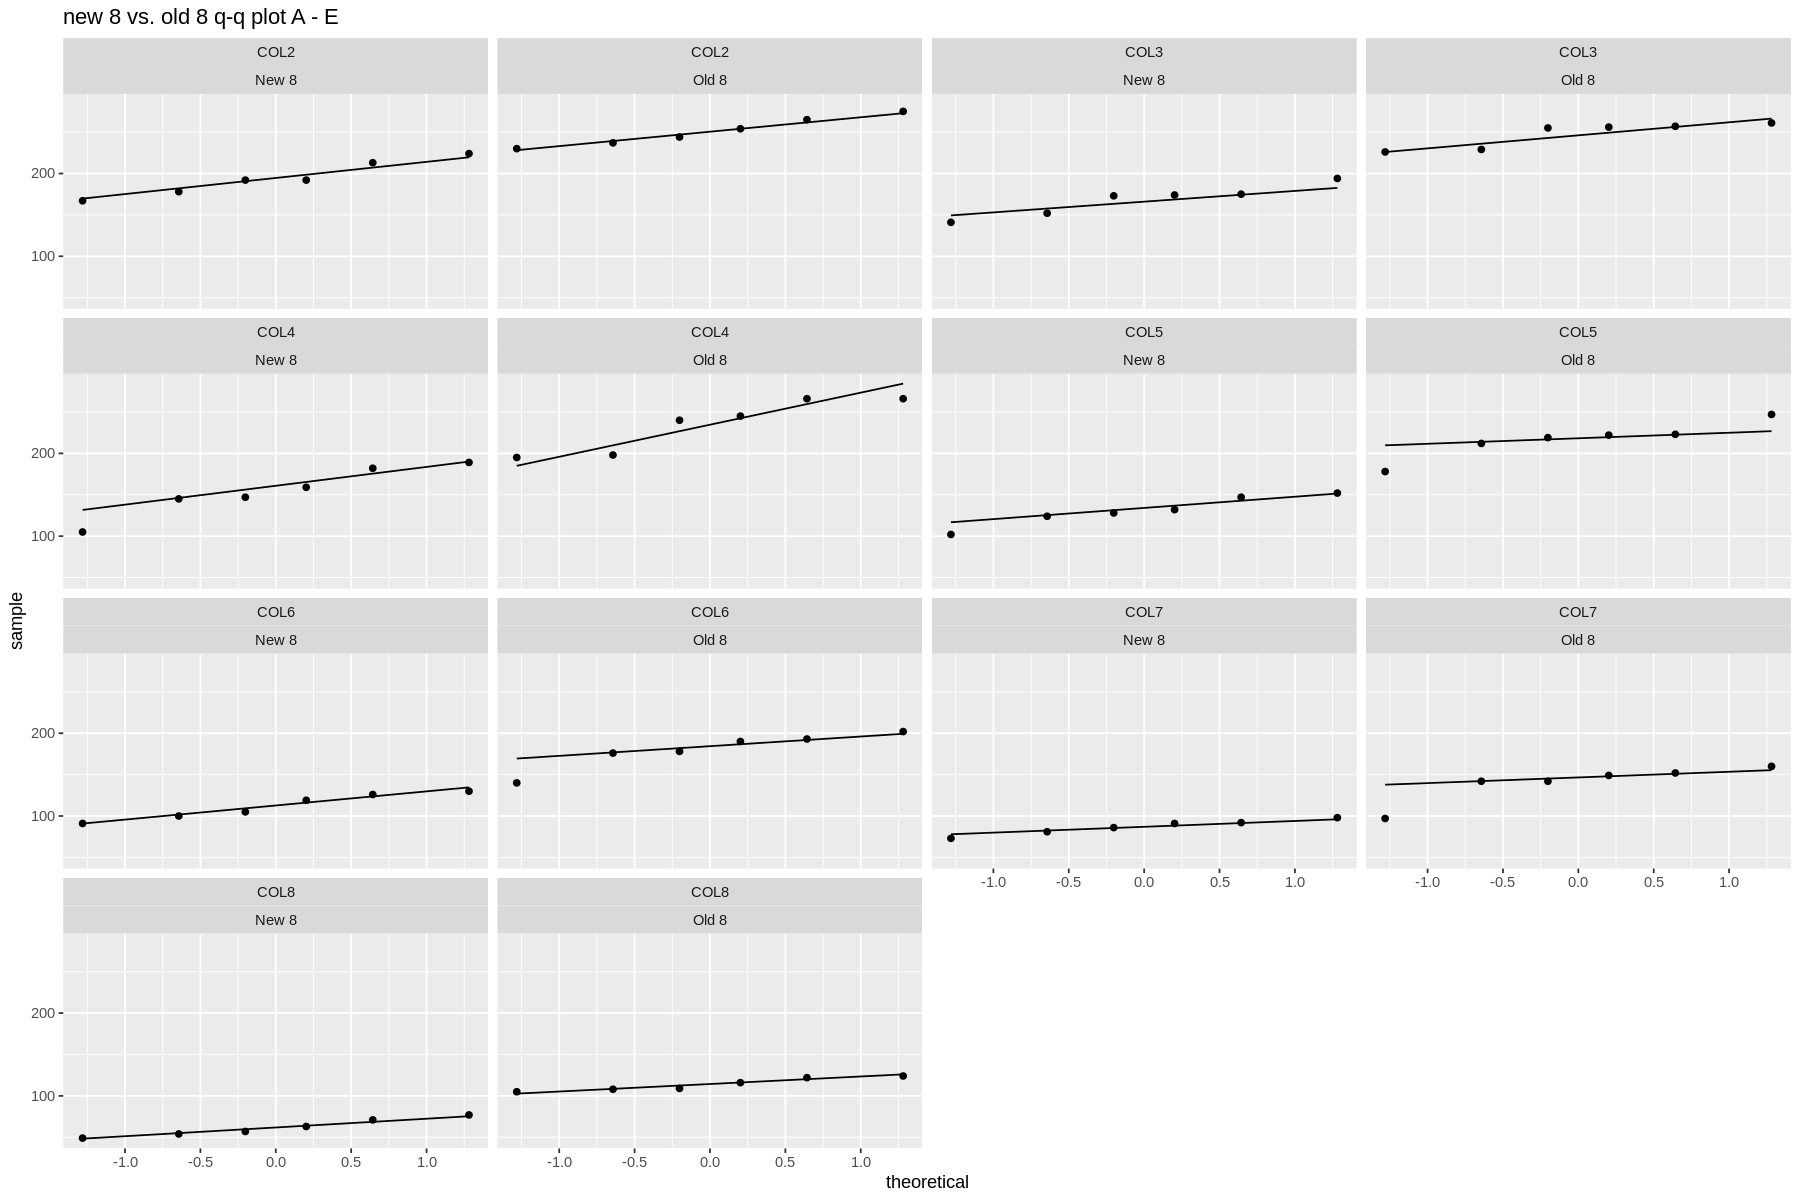

In [921]:
p_qq_si

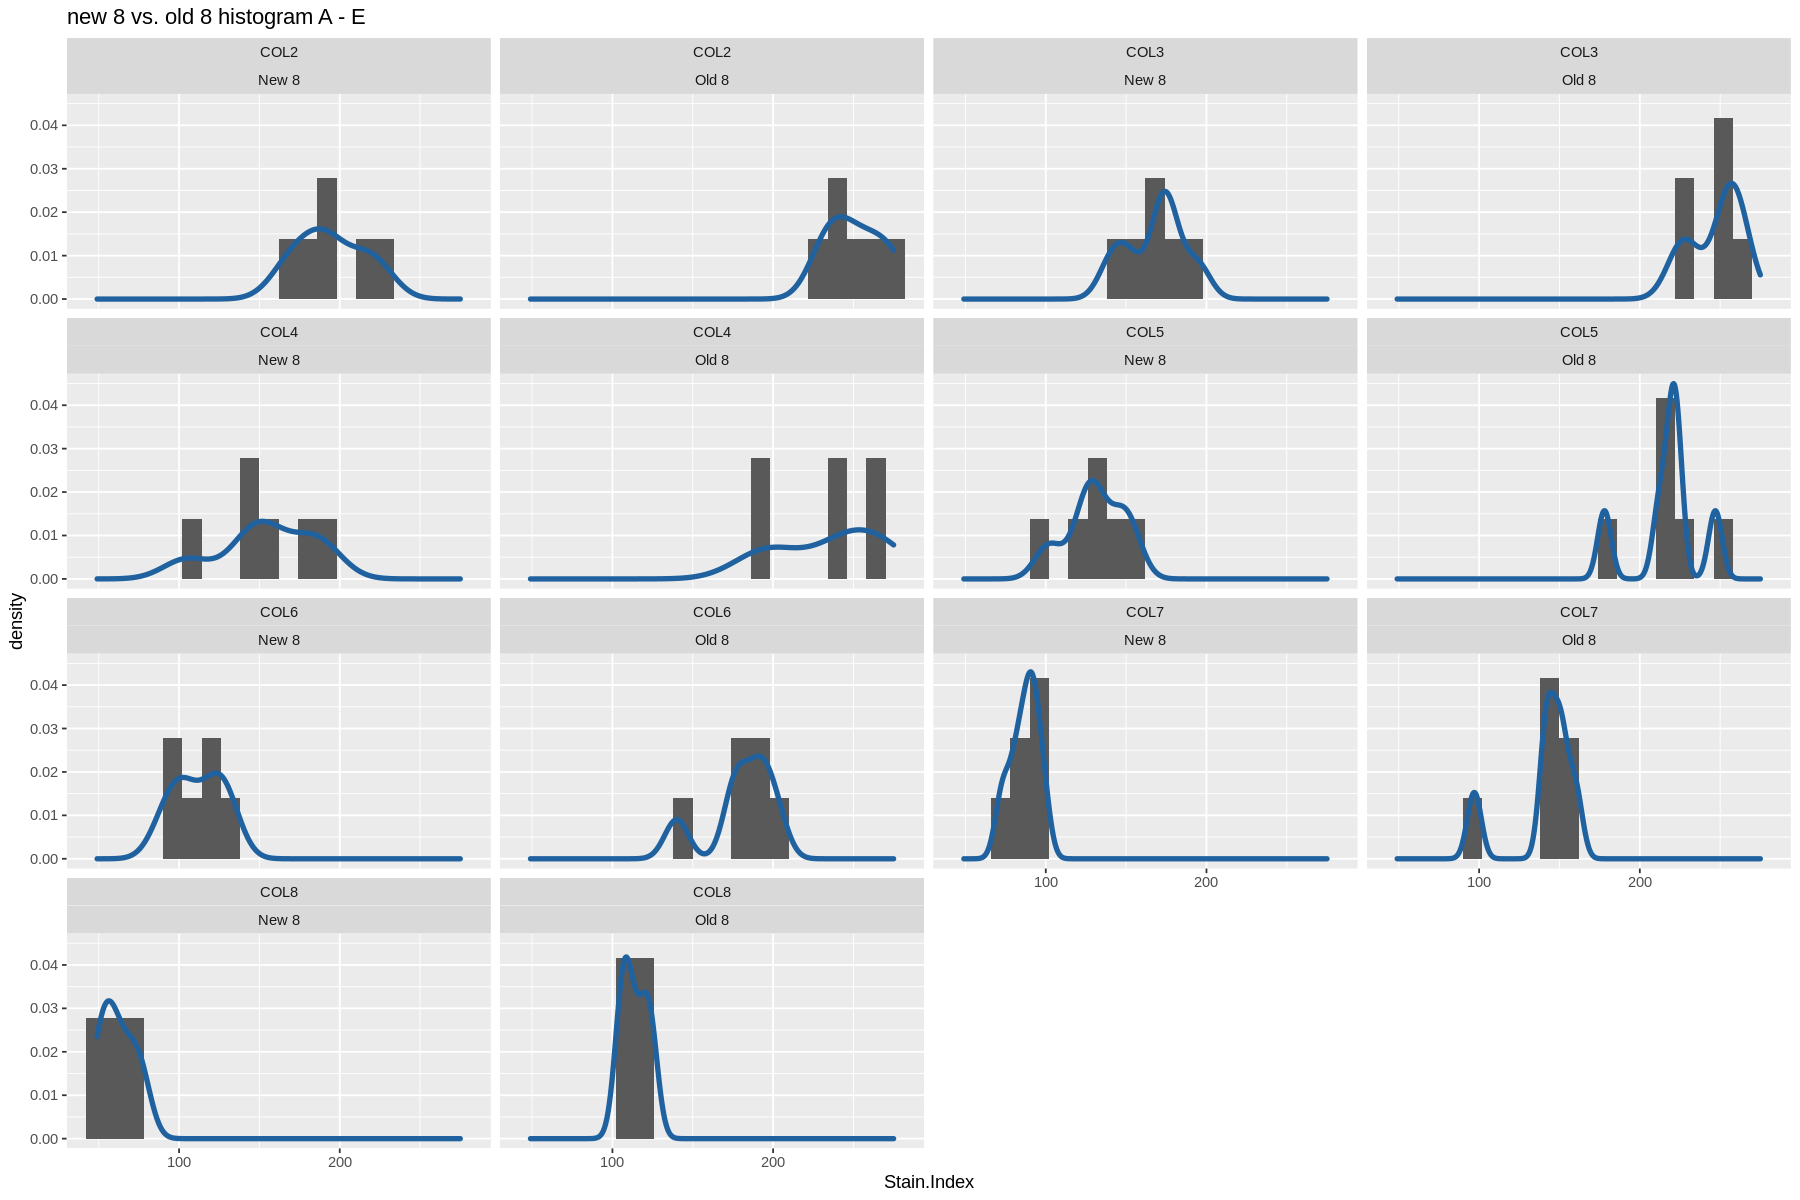

In [922]:
p_hst_si

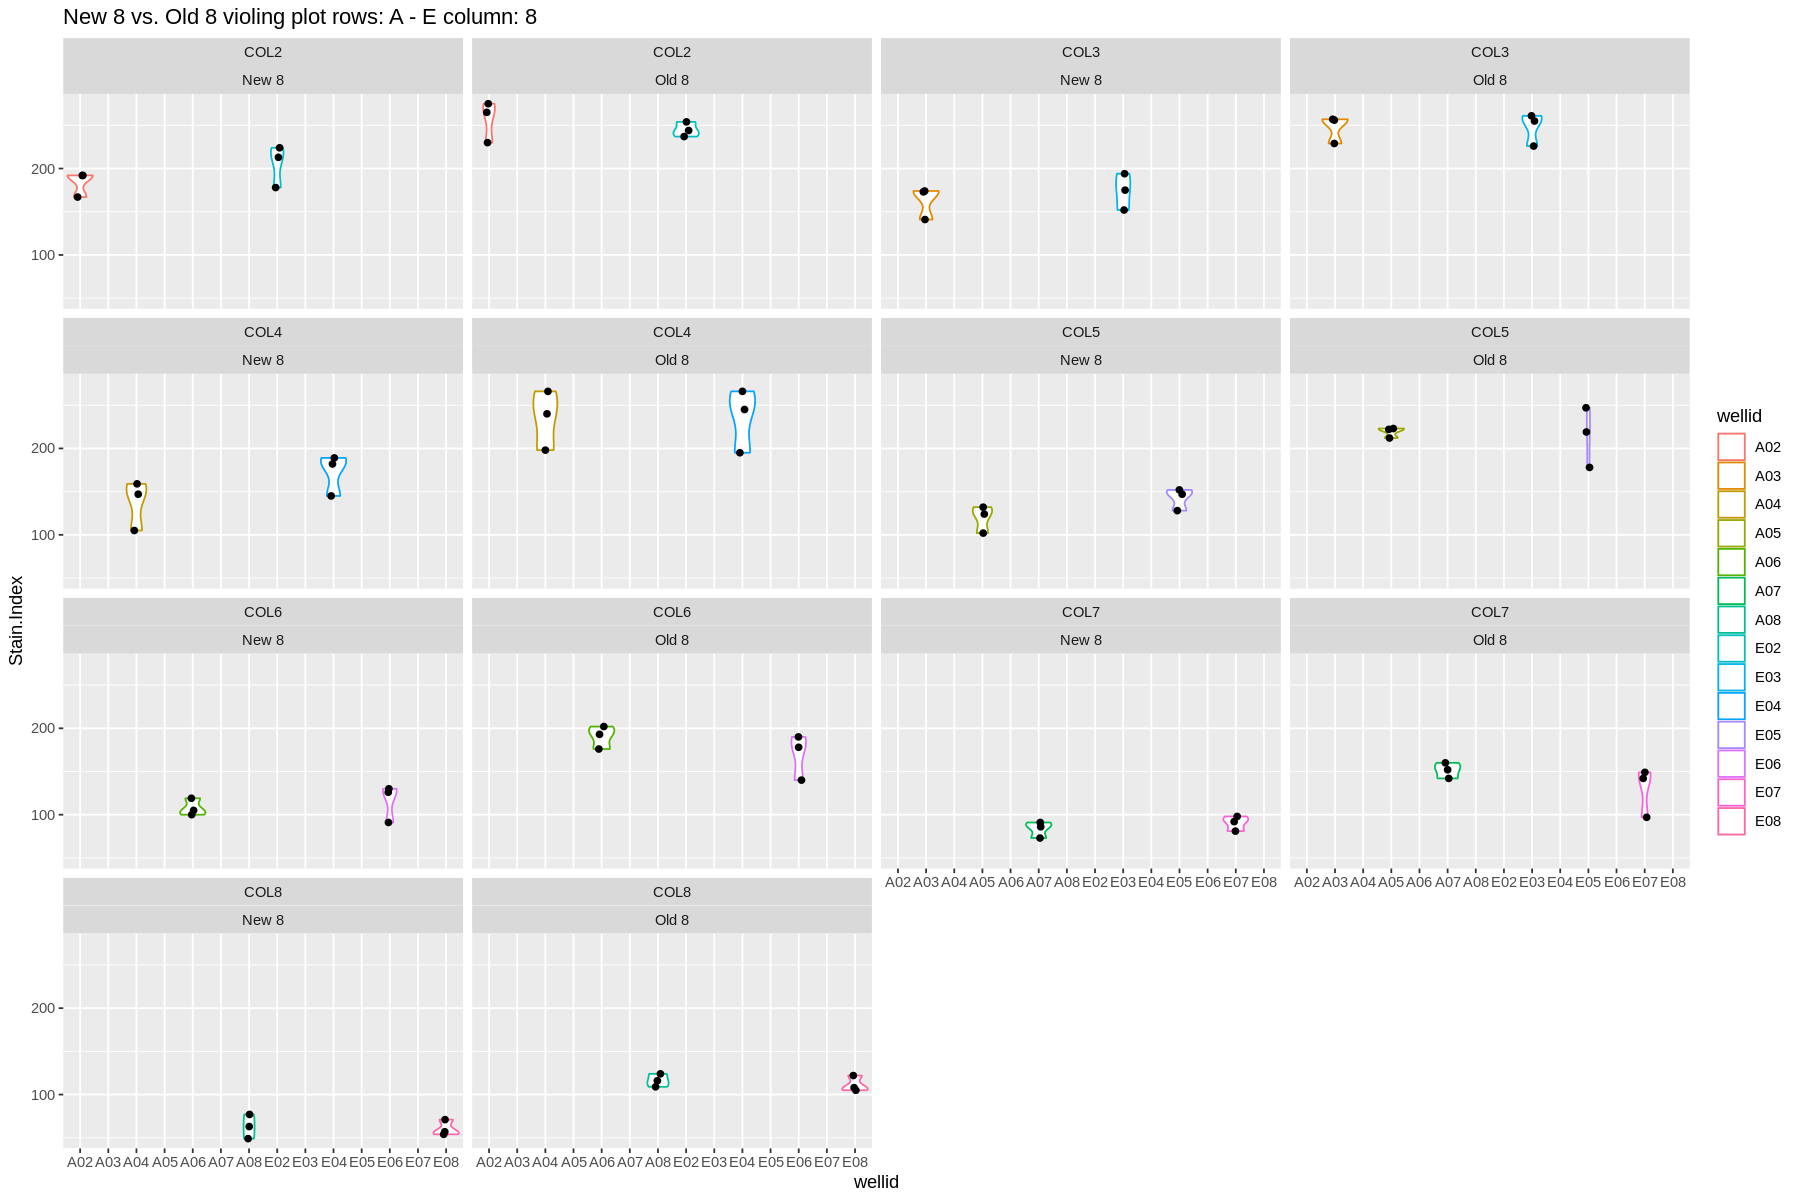

In [937]:
p_violin_si

In [938]:
# B-F
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
dft <- list()
for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    dft[[i-1]] <- dfm %>% 
                    filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i)) %>%
                    mutate(group = case_when(
                        as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
                        as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
                        as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
                        as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
                        as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
                        as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
                        as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
                        )
                      )
}

df.t <- do.call(rbind, dft)

p_qq_si <- ggplot(df.t, aes(sample = Stain.Index, group = group)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(group~ method) +
                ggtitle(paste("new 8 vs. old 8 q-q plot", pat1, "-", pat2))

p_hst_si <- ggplot(data = df.t, aes(group = group, x = Stain.Index)) +
    geom_histogram(aes(y = ..density..), binwidth = 12, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(group~ method) +
    ggtitle(paste("new 8 vs. old 8 histogram", pat1, "-", pat2))

p_violin_si <- ggplot(df.t, aes(wellid, Stain.Index)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 violing plot rows:", pat1, "-", pat2, "column:", i) ) +
    facet_wrap(group~ method)

[1] "B / F : 2"
[1] "B / F : 3"
[1] "B / F : 4"
[1] "B / F : 5"
[1] "B / F : 6"
[1] "B / F : 7"
[1] "B / F : 8"


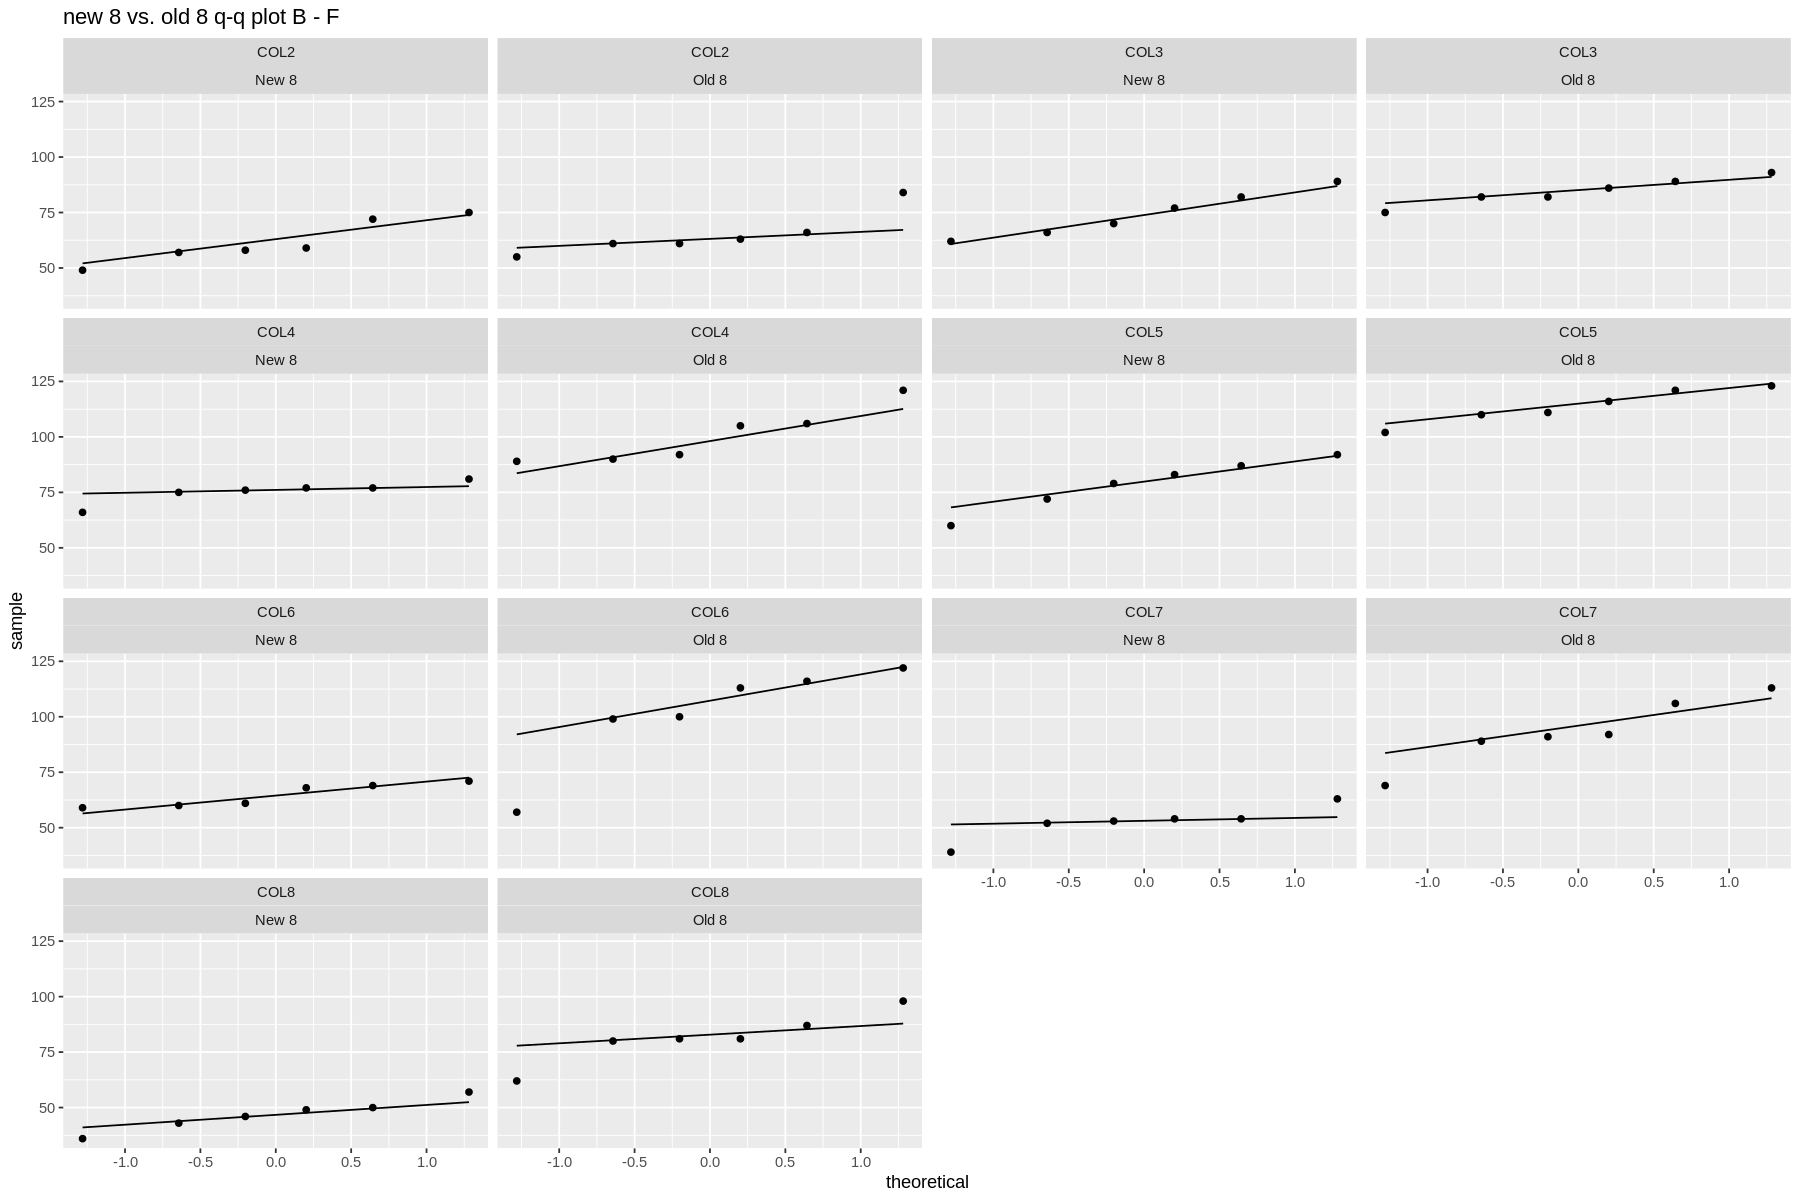

In [926]:
p_qq_si

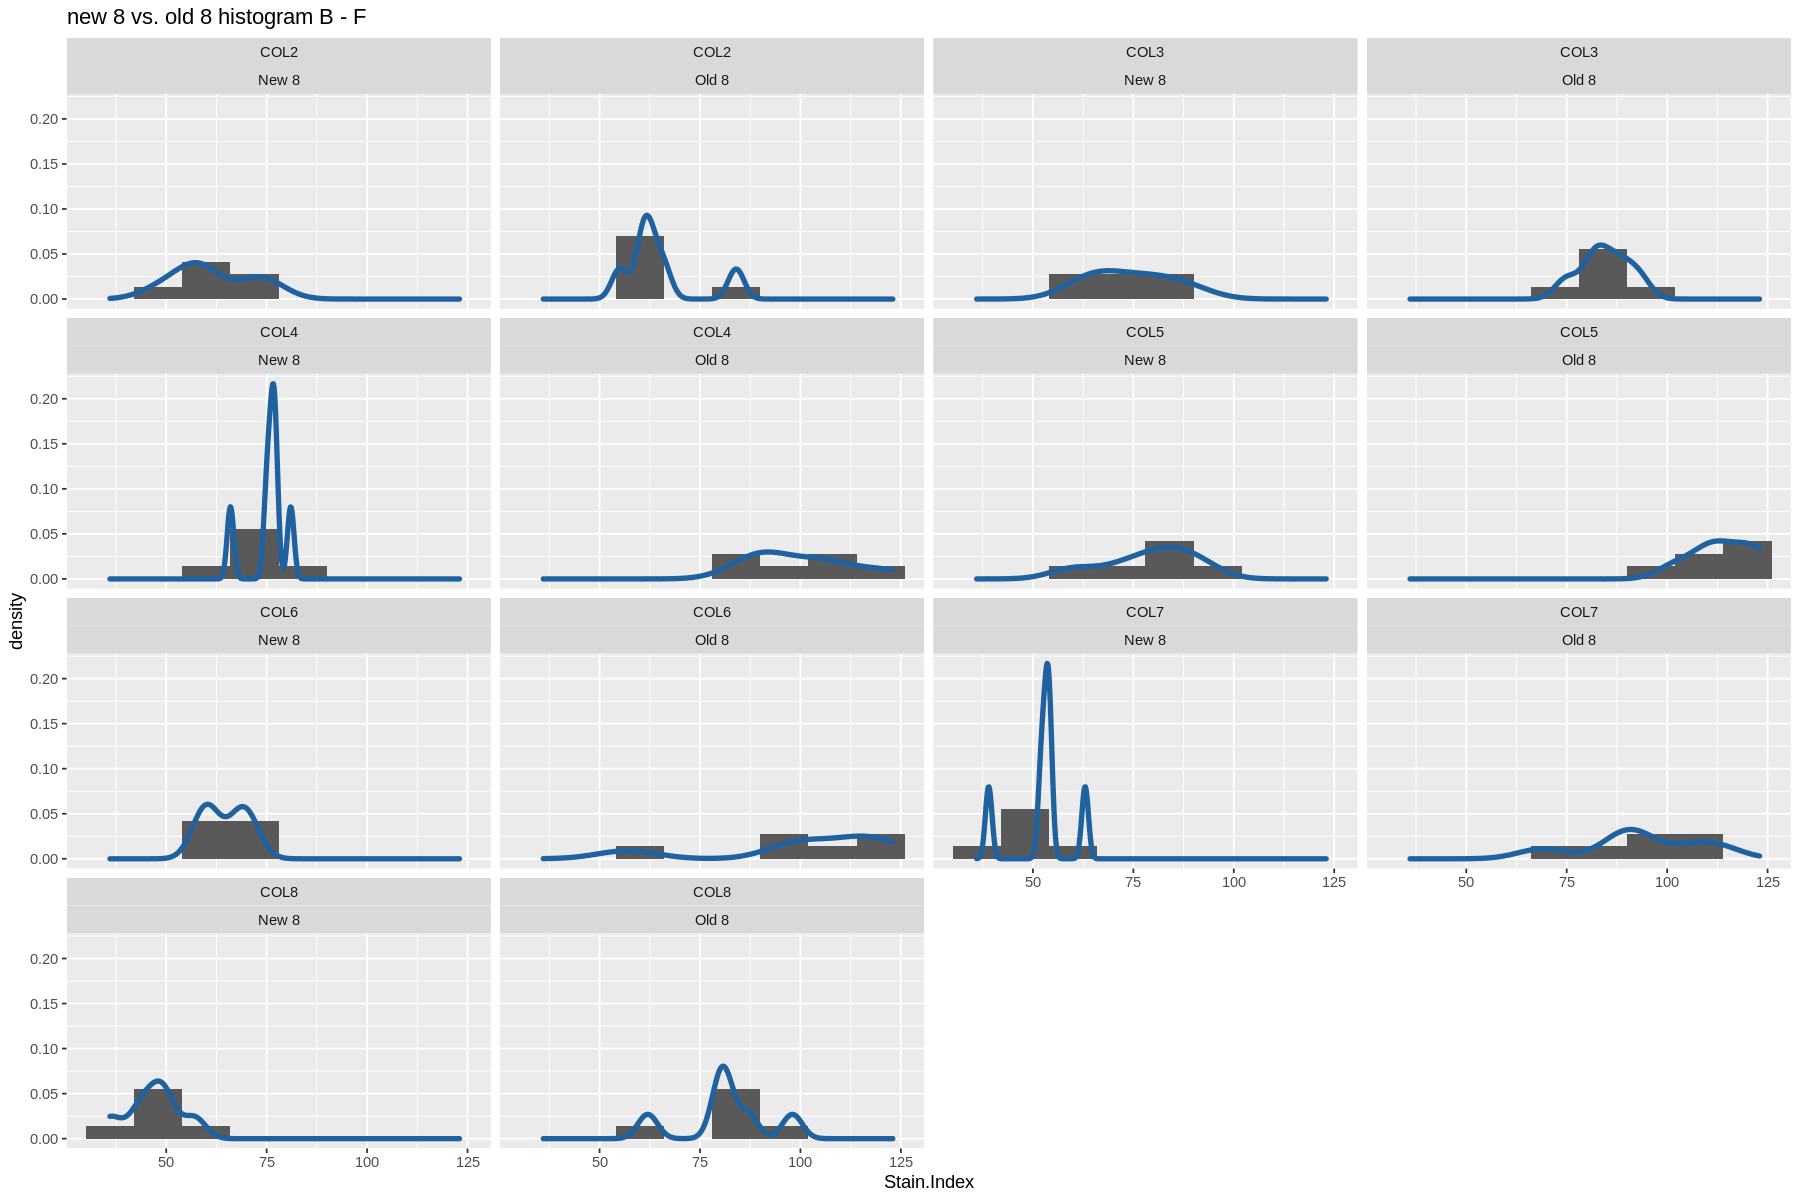

In [927]:
p_hst_si

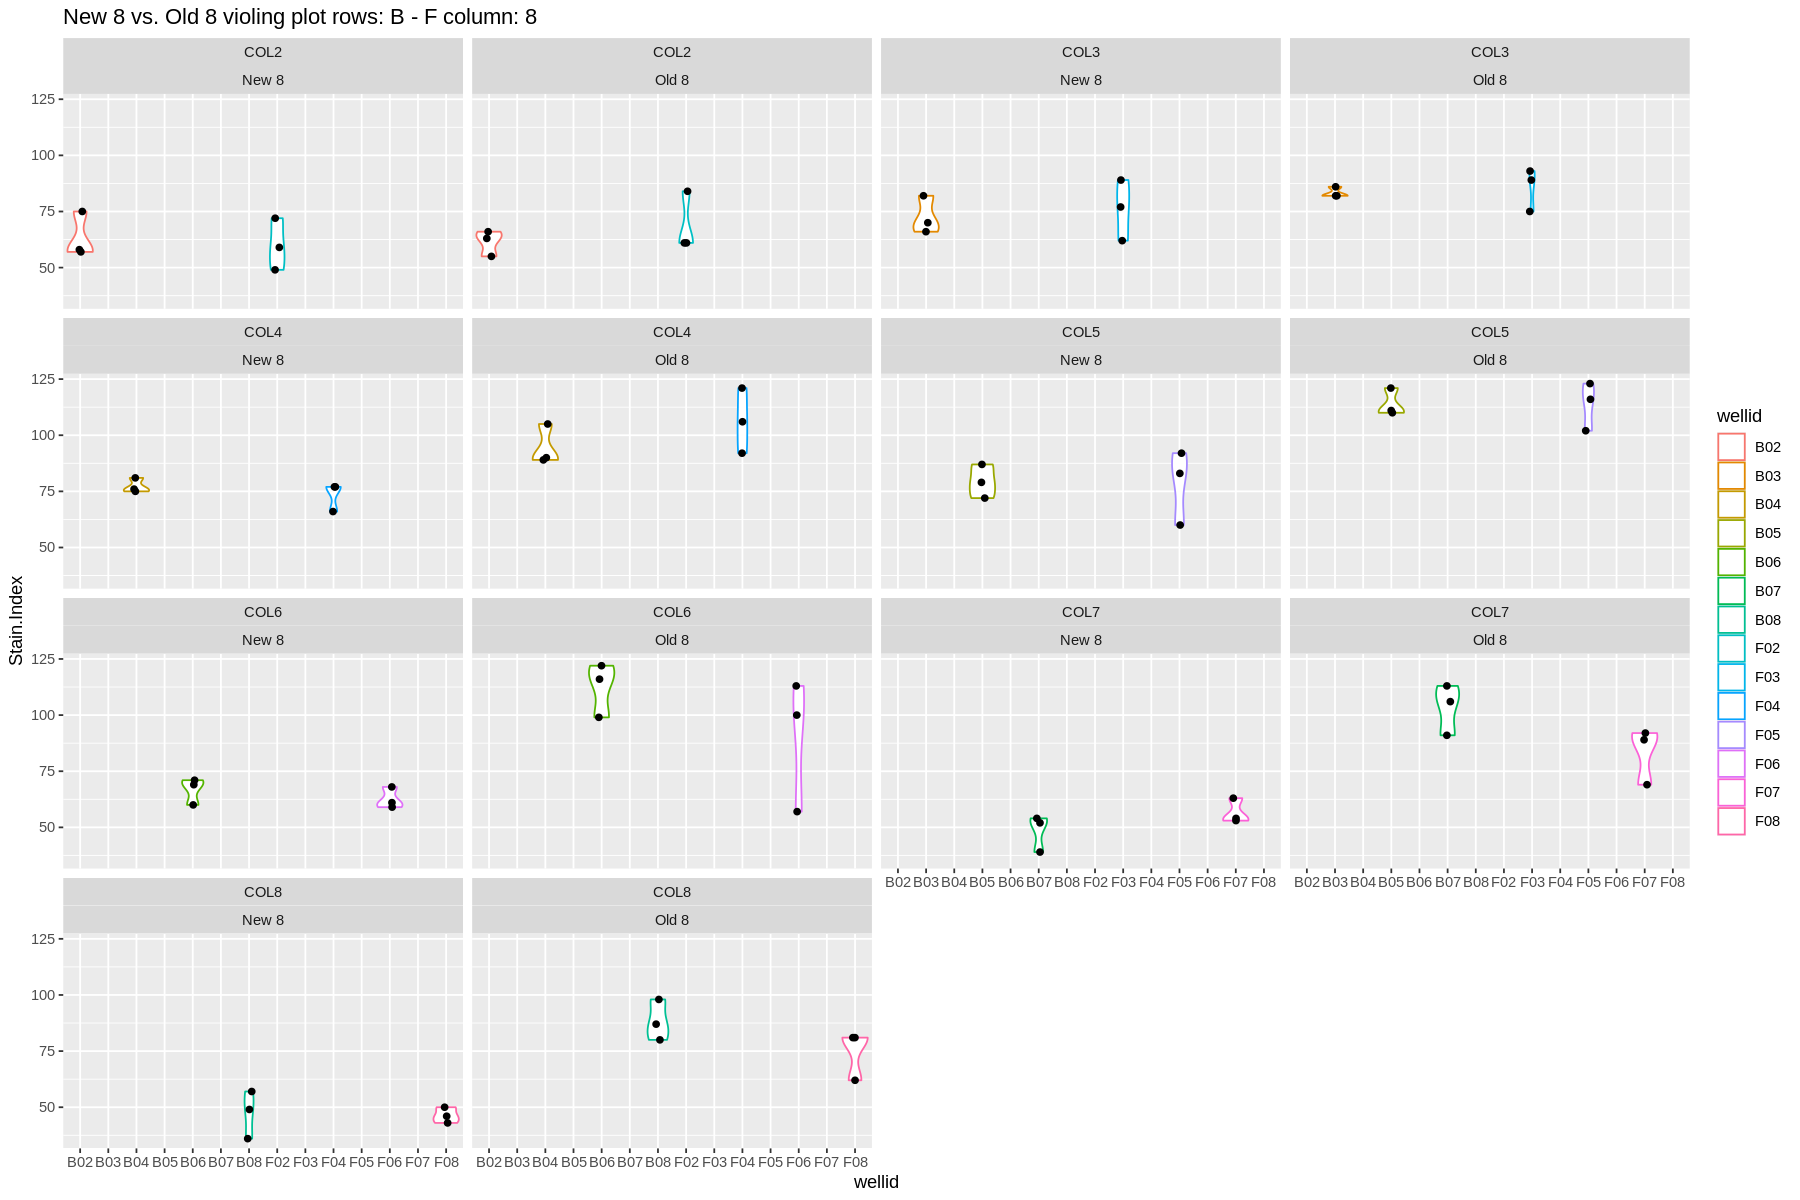

In [939]:
p_violin_si

In [940]:
# C-G
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
dft <- list()
for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    dft[[i-1]] <- dfm %>% 
                    filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i)) %>%
                    mutate(group = case_when(
                        as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
                        as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
                        as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
                        as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
                        as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
                        as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
                        as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
                        )
                      )
}

df.t <- do.call(rbind, dft)

p_qq_si <- ggplot(df.t, aes(sample = Stain.Index, group = group)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(group~ method) +
                ggtitle(paste("new 8 vs. old 8 q-q plot", pat1, "-", pat2))

p_hst_si <- ggplot(data = df.t, aes(group = group, x = Stain.Index)) +
    geom_histogram(aes(y = ..density..), binwidth = 12, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(group~ method) +
    ggtitle(paste("new 8 vs. old 8 histogram", pat1, "-", pat2))

p_violin_si <- ggplot(df.t, aes(wellid, Stain.Index)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 violing plot rows:", pat1, "-", pat2, "column:", i) ) +
    facet_wrap(group~ method)

[1] "C / G : 2"
[1] "C / G : 3"
[1] "C / G : 4"
[1] "C / G : 5"
[1] "C / G : 6"
[1] "C / G : 7"
[1] "C / G : 8"


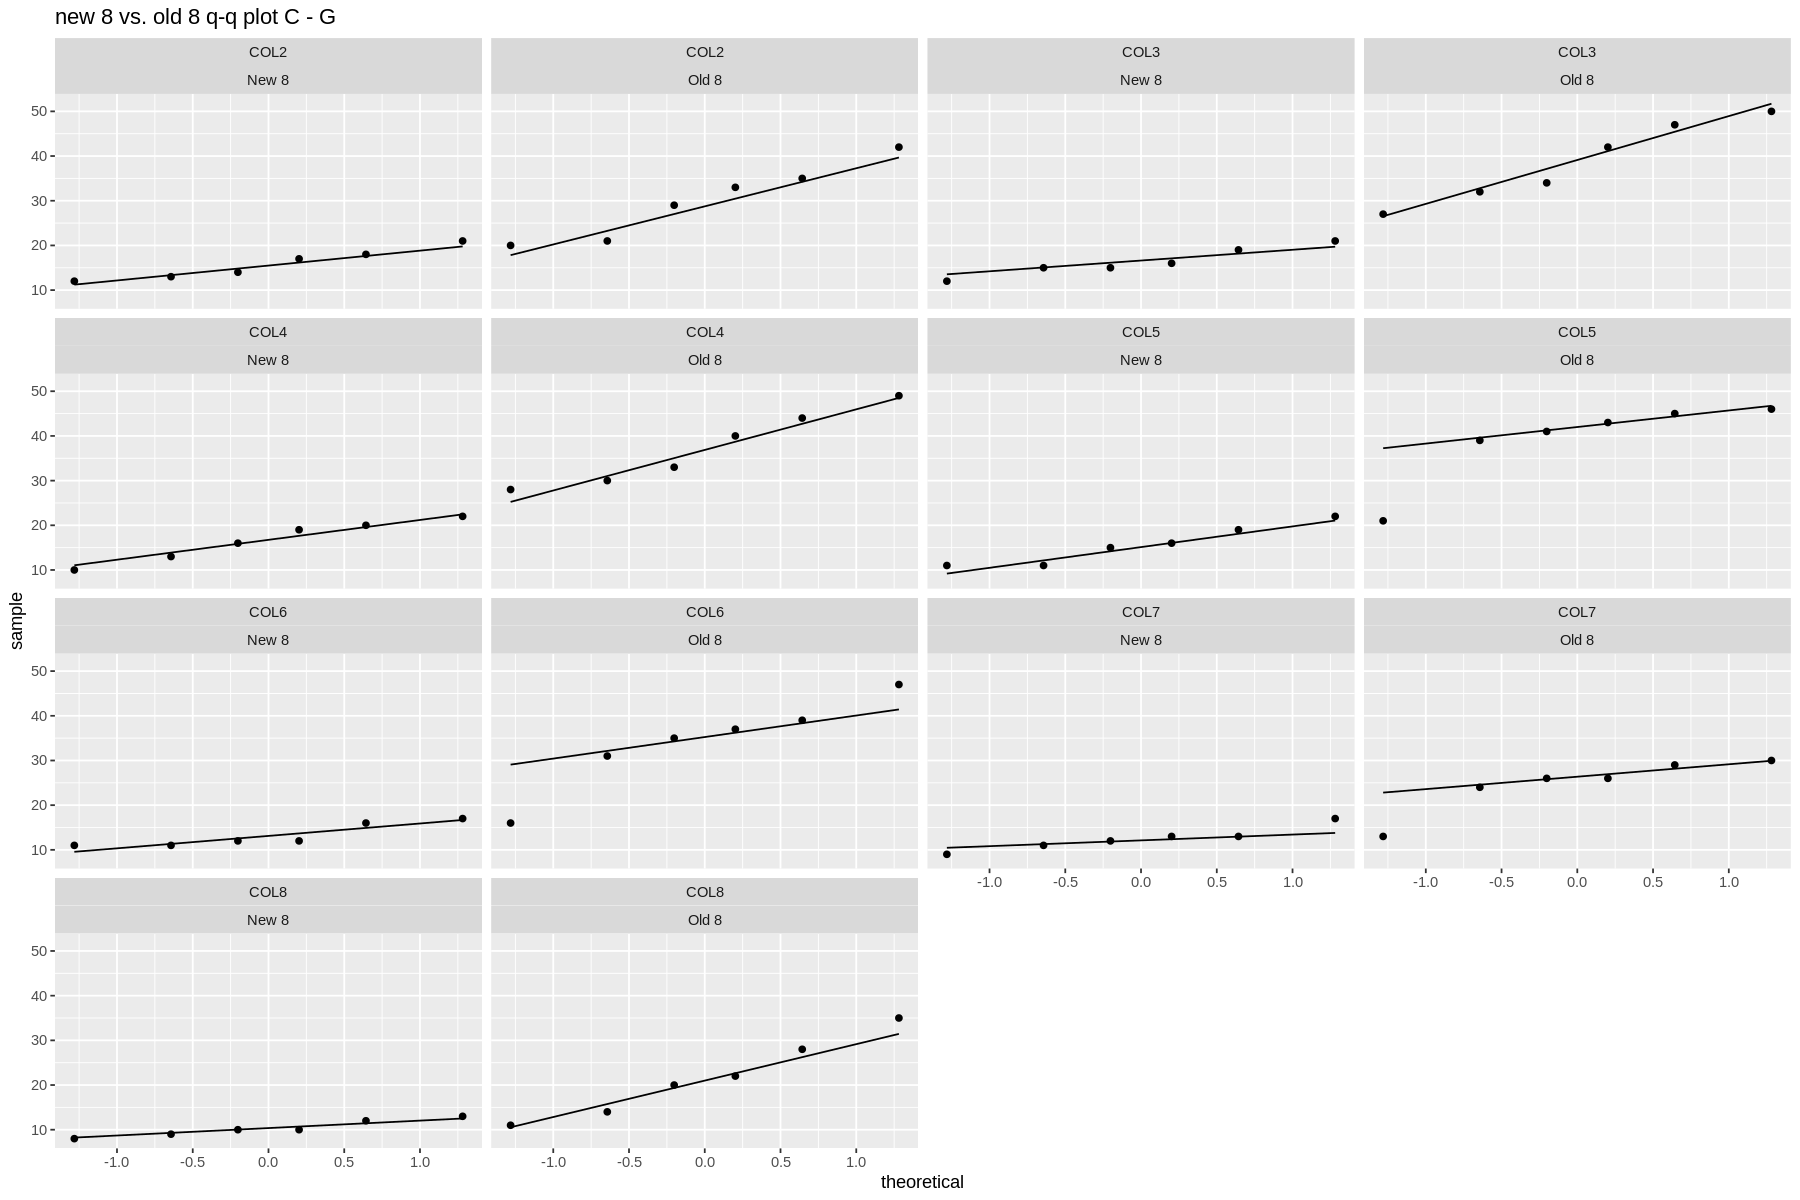

In [914]:
p_qq_si

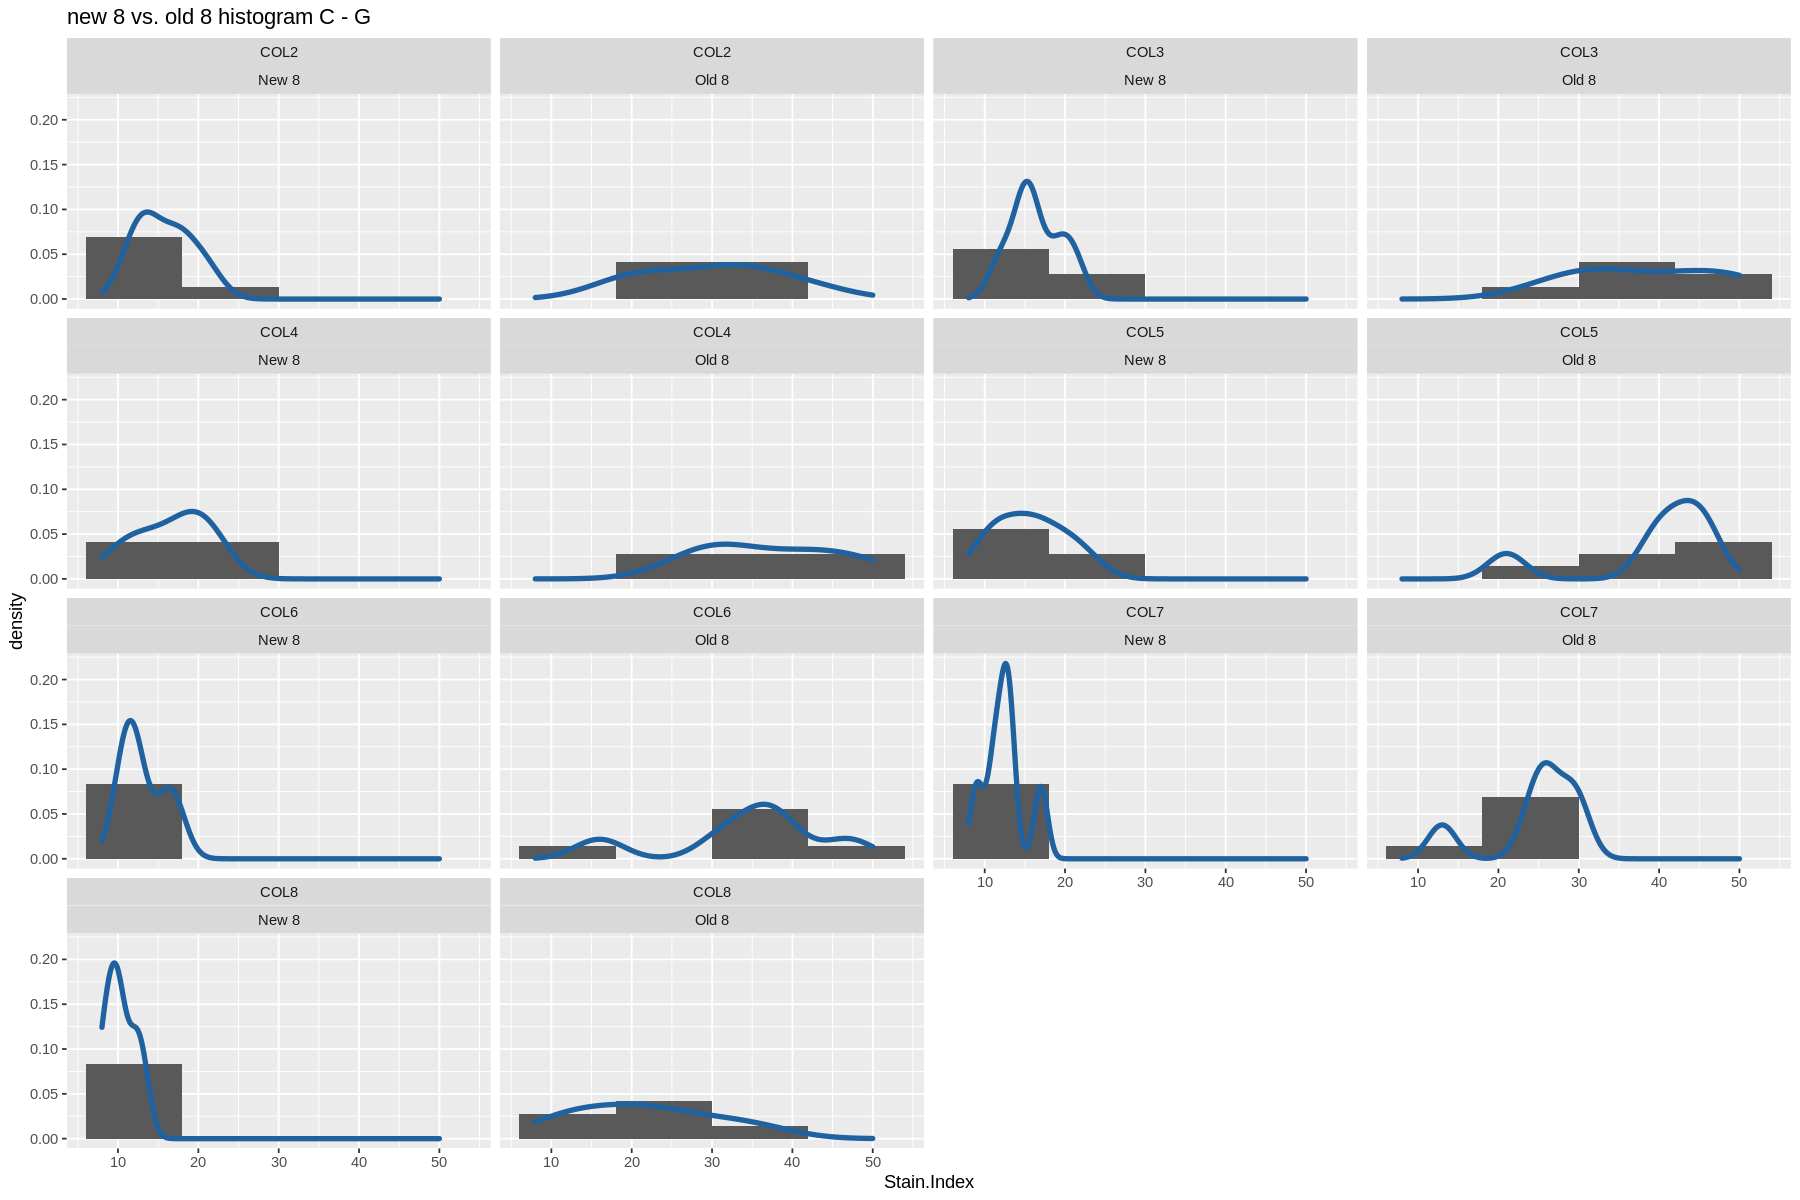

In [915]:
p_hst_si

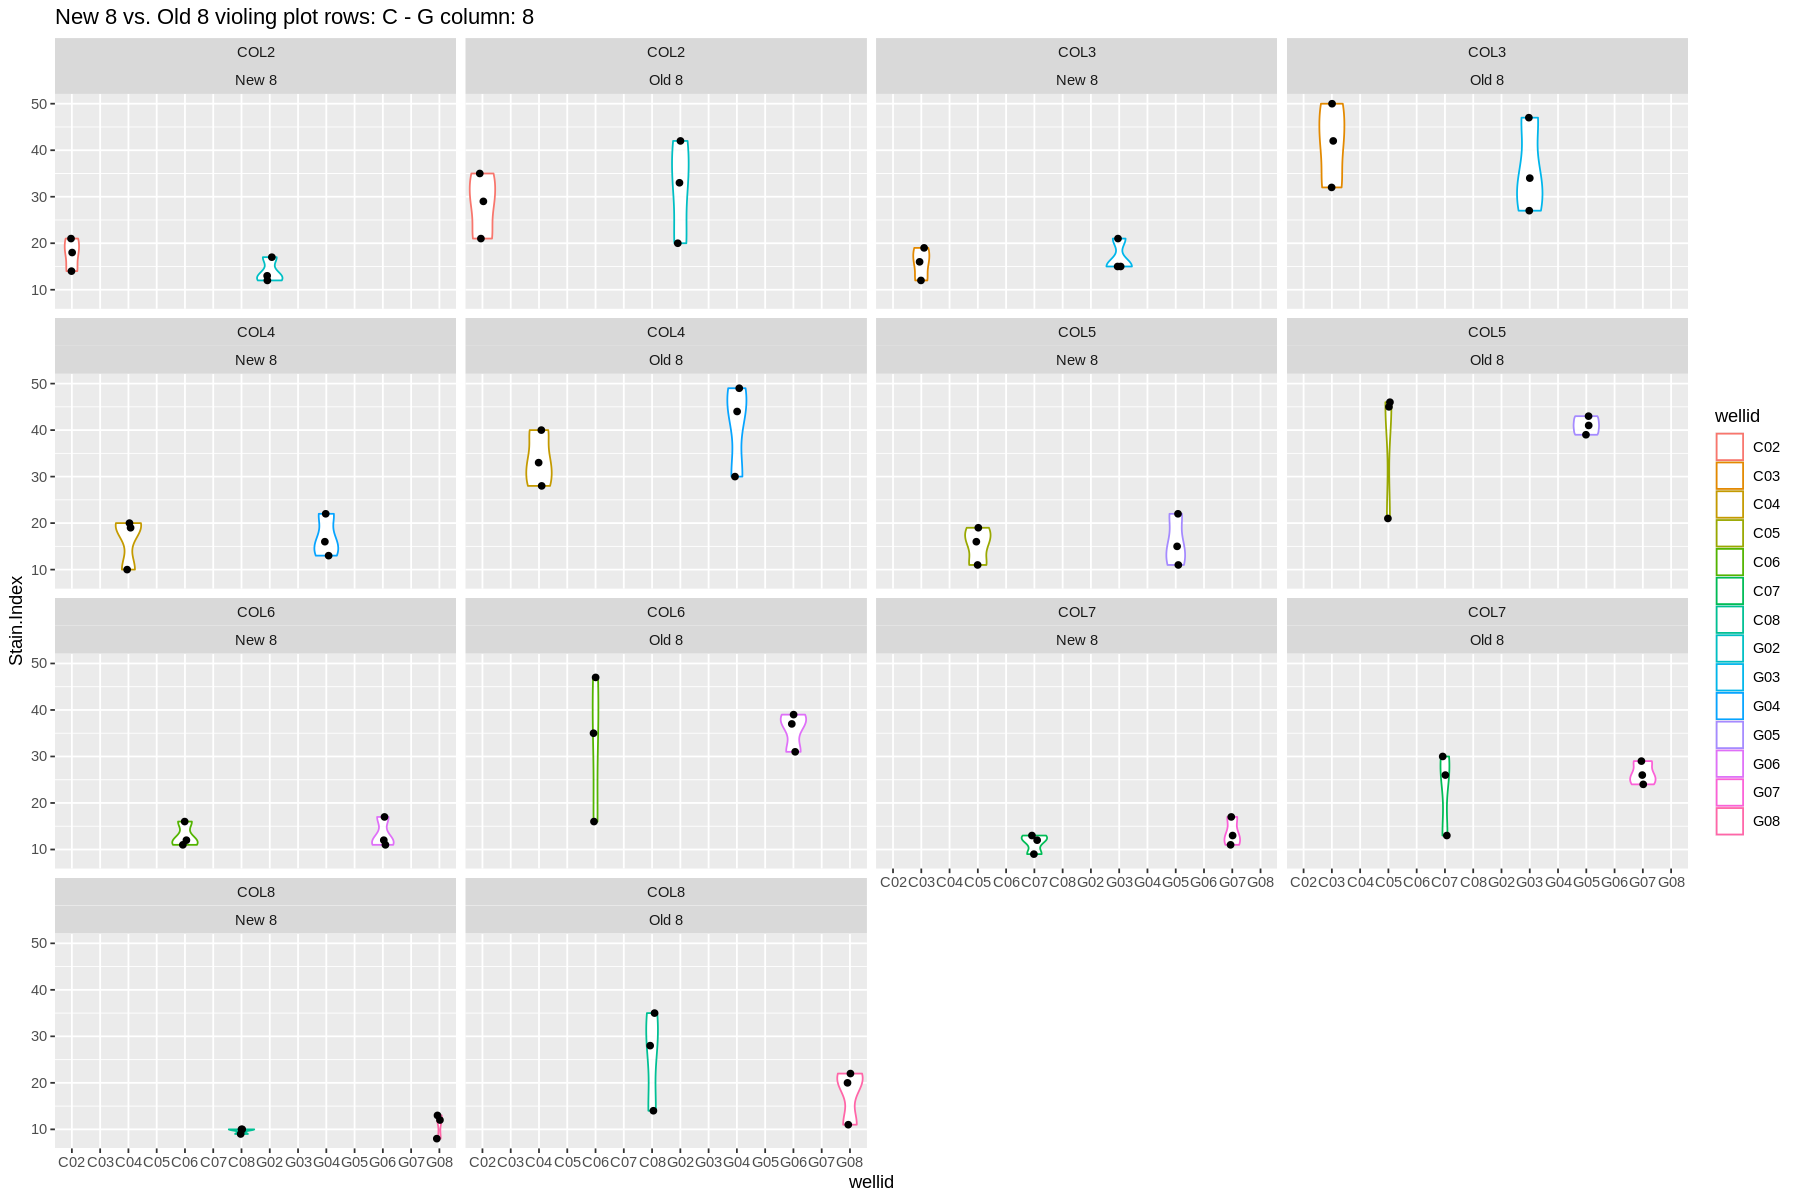

In [941]:
p_violin_si

In [942]:
# D-H
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
dft <- list()
for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    dft[[i-1]] <- dfm %>% 
                    filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i)) %>%
                    mutate(group = case_when(
                        as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
                        as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
                        as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
                        as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
                        as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
                        as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
                        as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
                        )
                      )
}

df.t <- do.call(rbind, dft)

p_qq_si <- ggplot(df.t, aes(sample = Stain.Index, group = group)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(group~ method) +
                ggtitle(paste("new 8 vs. old 8 q-q plot", pat1, "-", pat2))

p_hst_si <- ggplot(data = df.t, aes(group = group, x = Stain.Index)) +
    geom_histogram(aes(y = ..density..), binwidth = 12, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(group~ method) +
    ggtitle(paste("new 8 vs. old 8 histogram", pat1, "-", pat2))

p_violin_si <- ggplot(df.t, aes(wellid, Stain.Index)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 violing plot rows:", pat1, "-", pat2, "column:", i) ) +
    facet_wrap(group~ method)

[1] "D / H : 2"
[1] "D / H : 3"
[1] "D / H : 4"
[1] "D / H : 5"
[1] "D / H : 6"
[1] "D / H : 7"
[1] "D / H : 8"


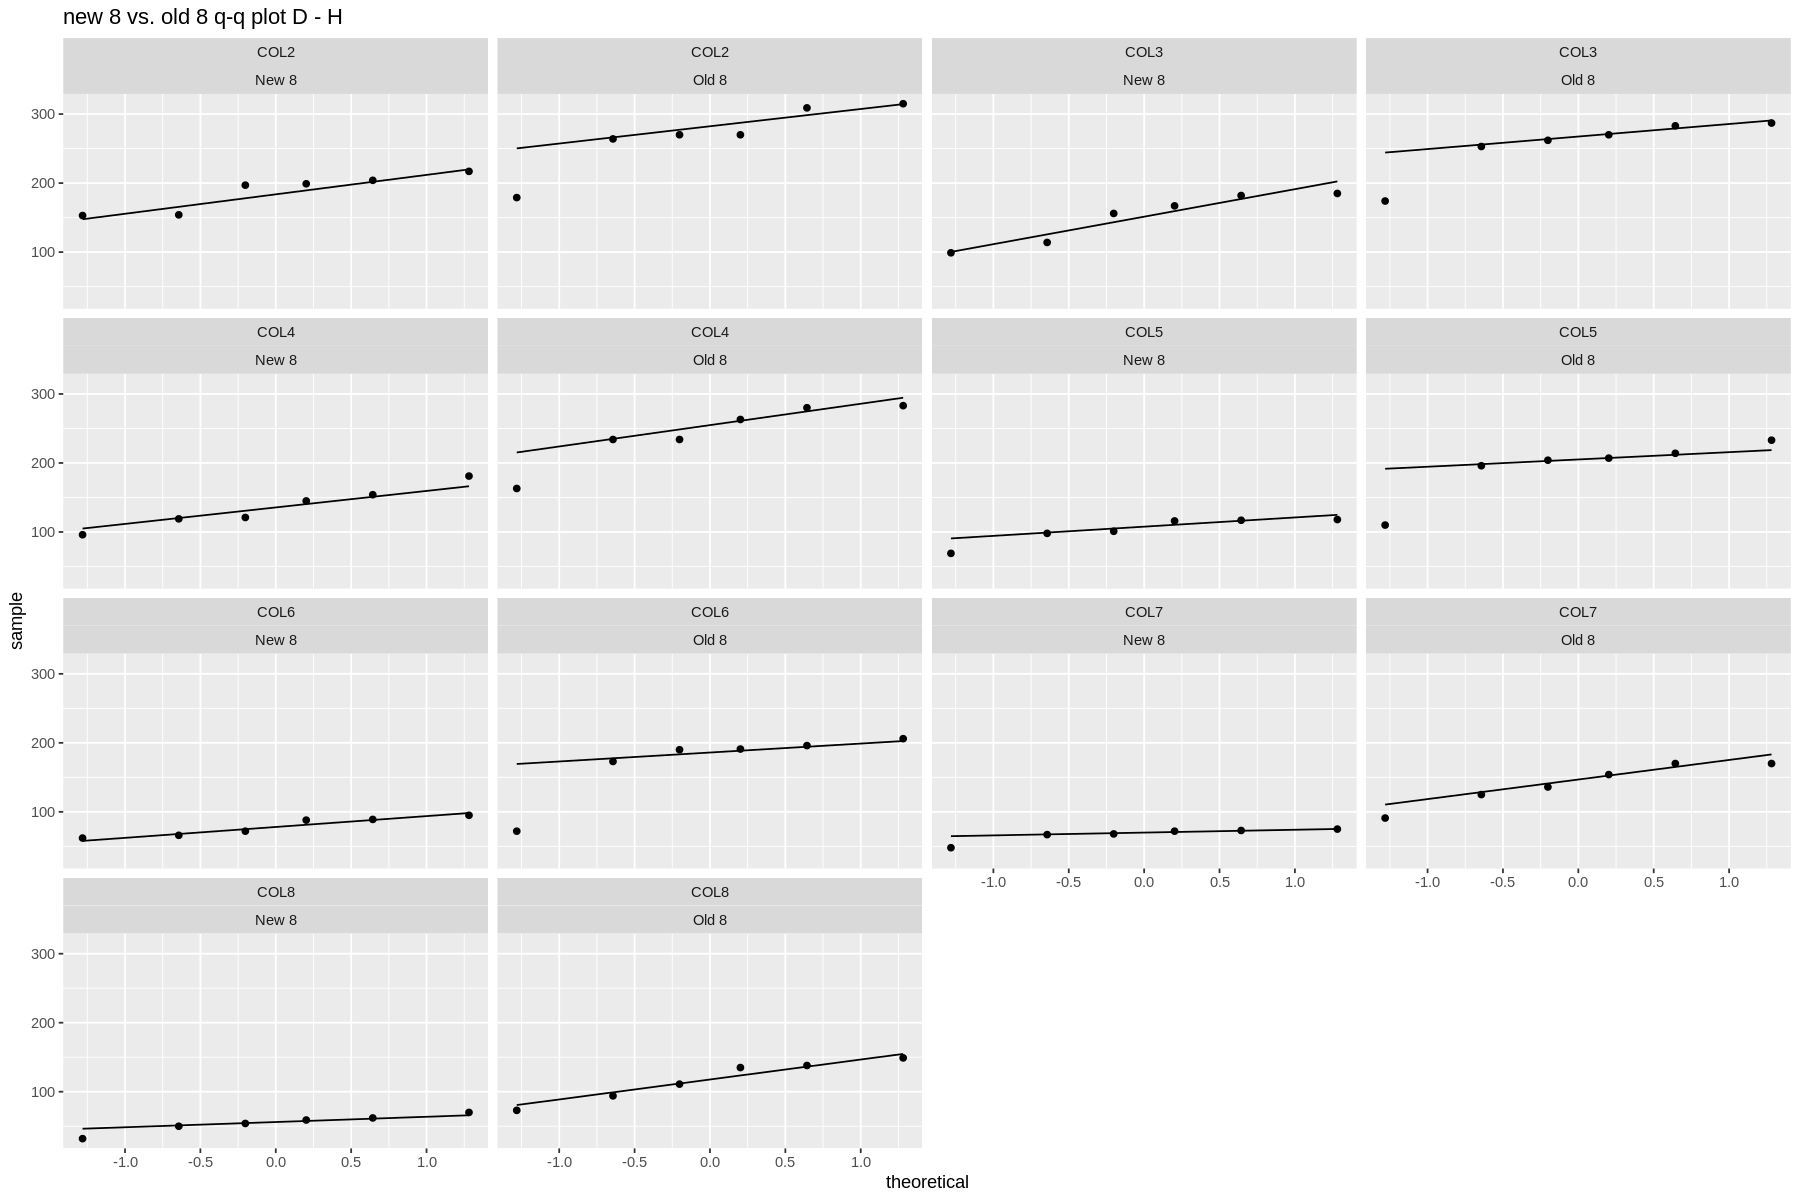

In [943]:
p_qq_si

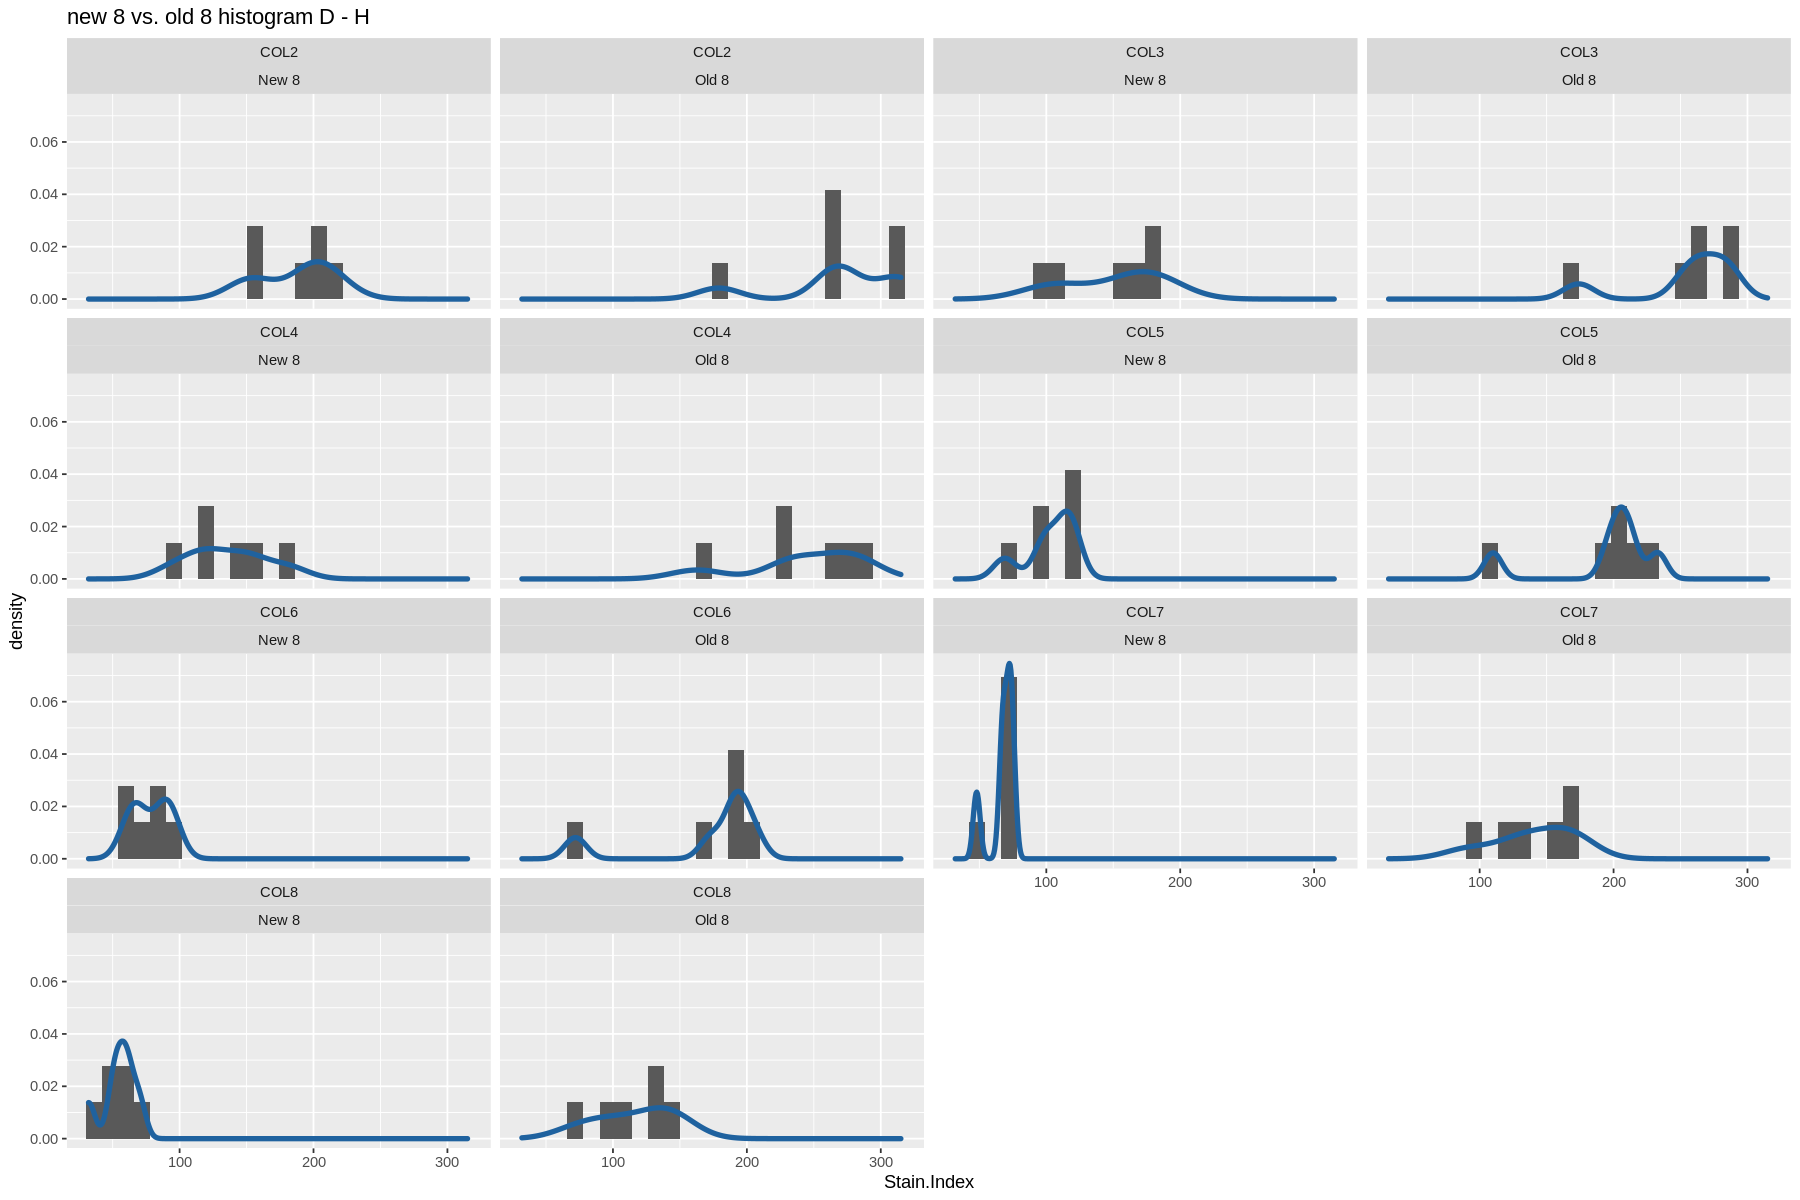

In [944]:
p_hst_si

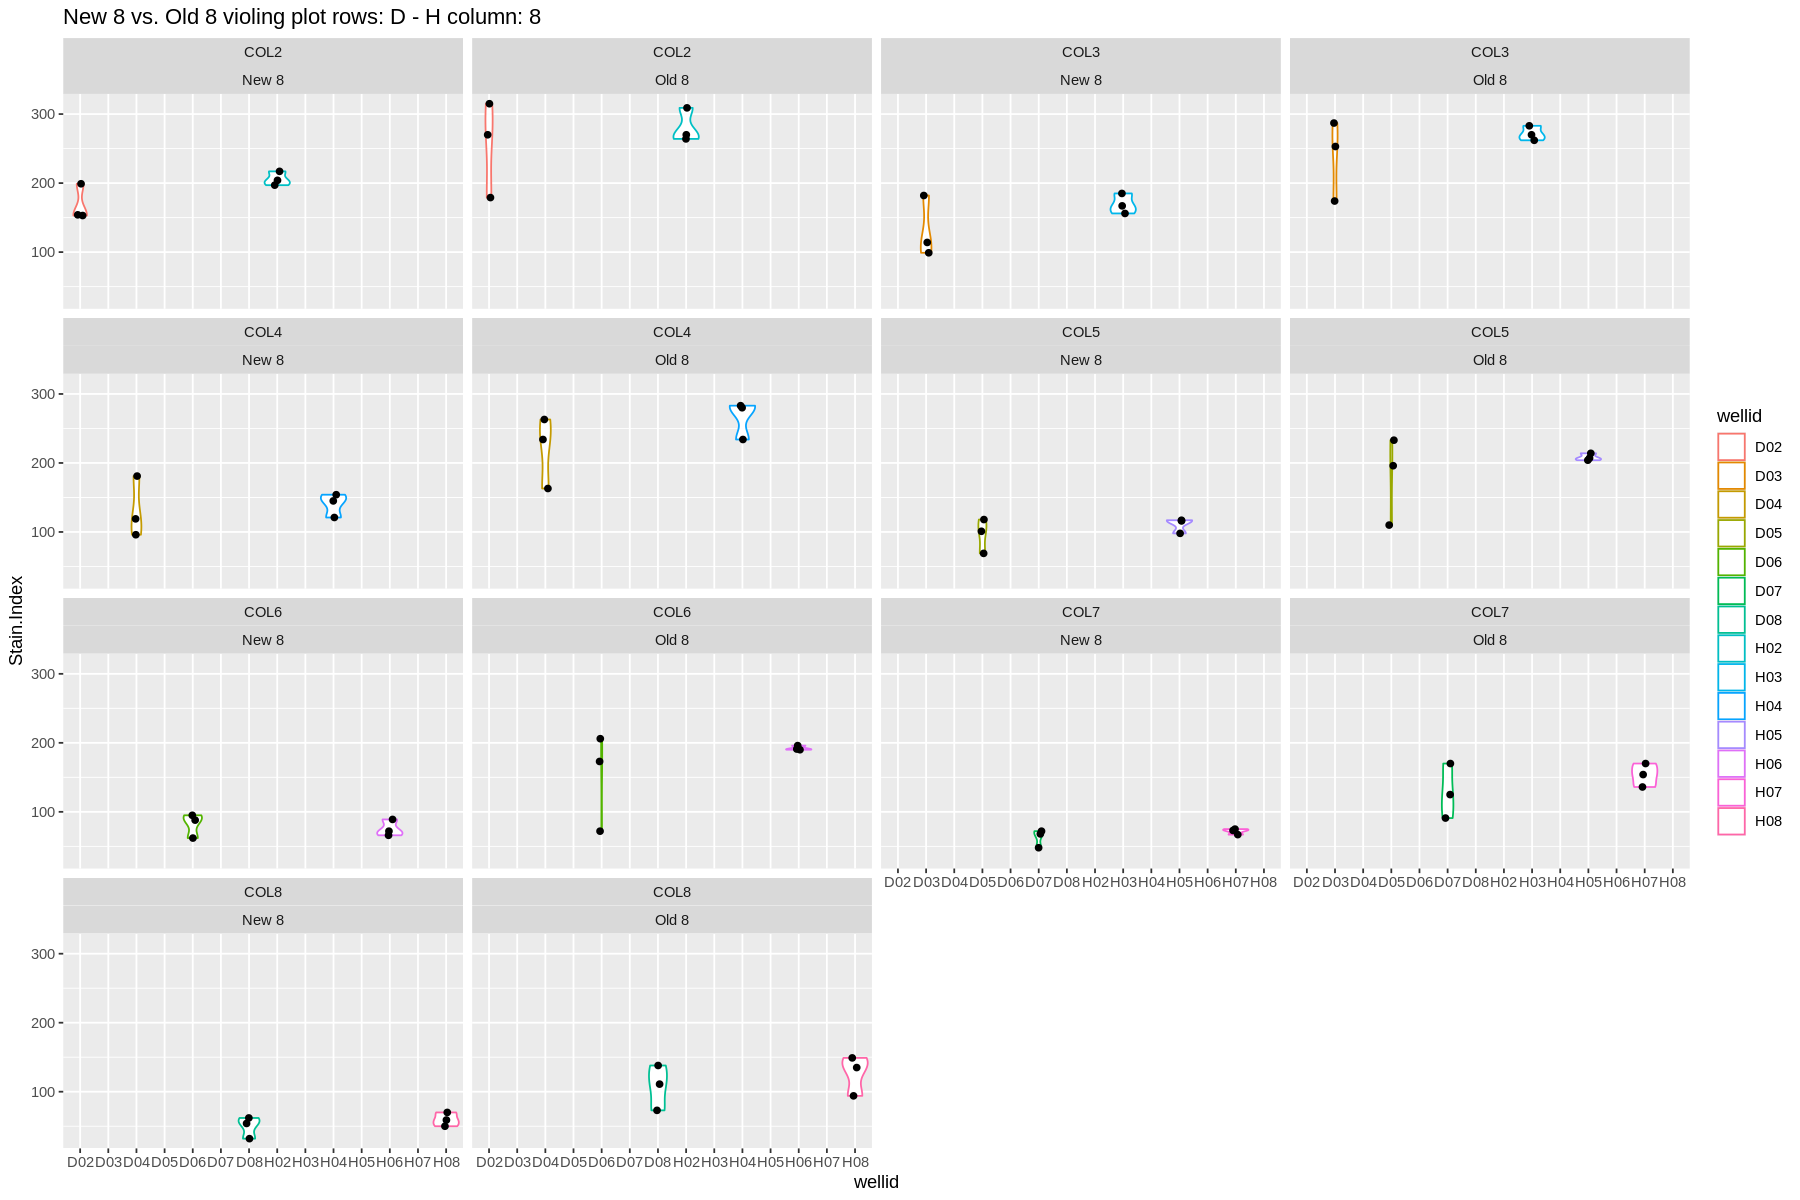

In [945]:
p_violin_si
#ggsave(filename = "violin_4rows_new8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

In [807]:
save_gg <- function(p, ncol, filename) {
    pp <- arrangeGrob(grobs = p, ncol=ncol)
    ggsave(filename = paste0(filename, ".png"), plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
}

#### Violin plots
-  It is similar to a box plot, with the addition of a rotated kernel density plot on each side

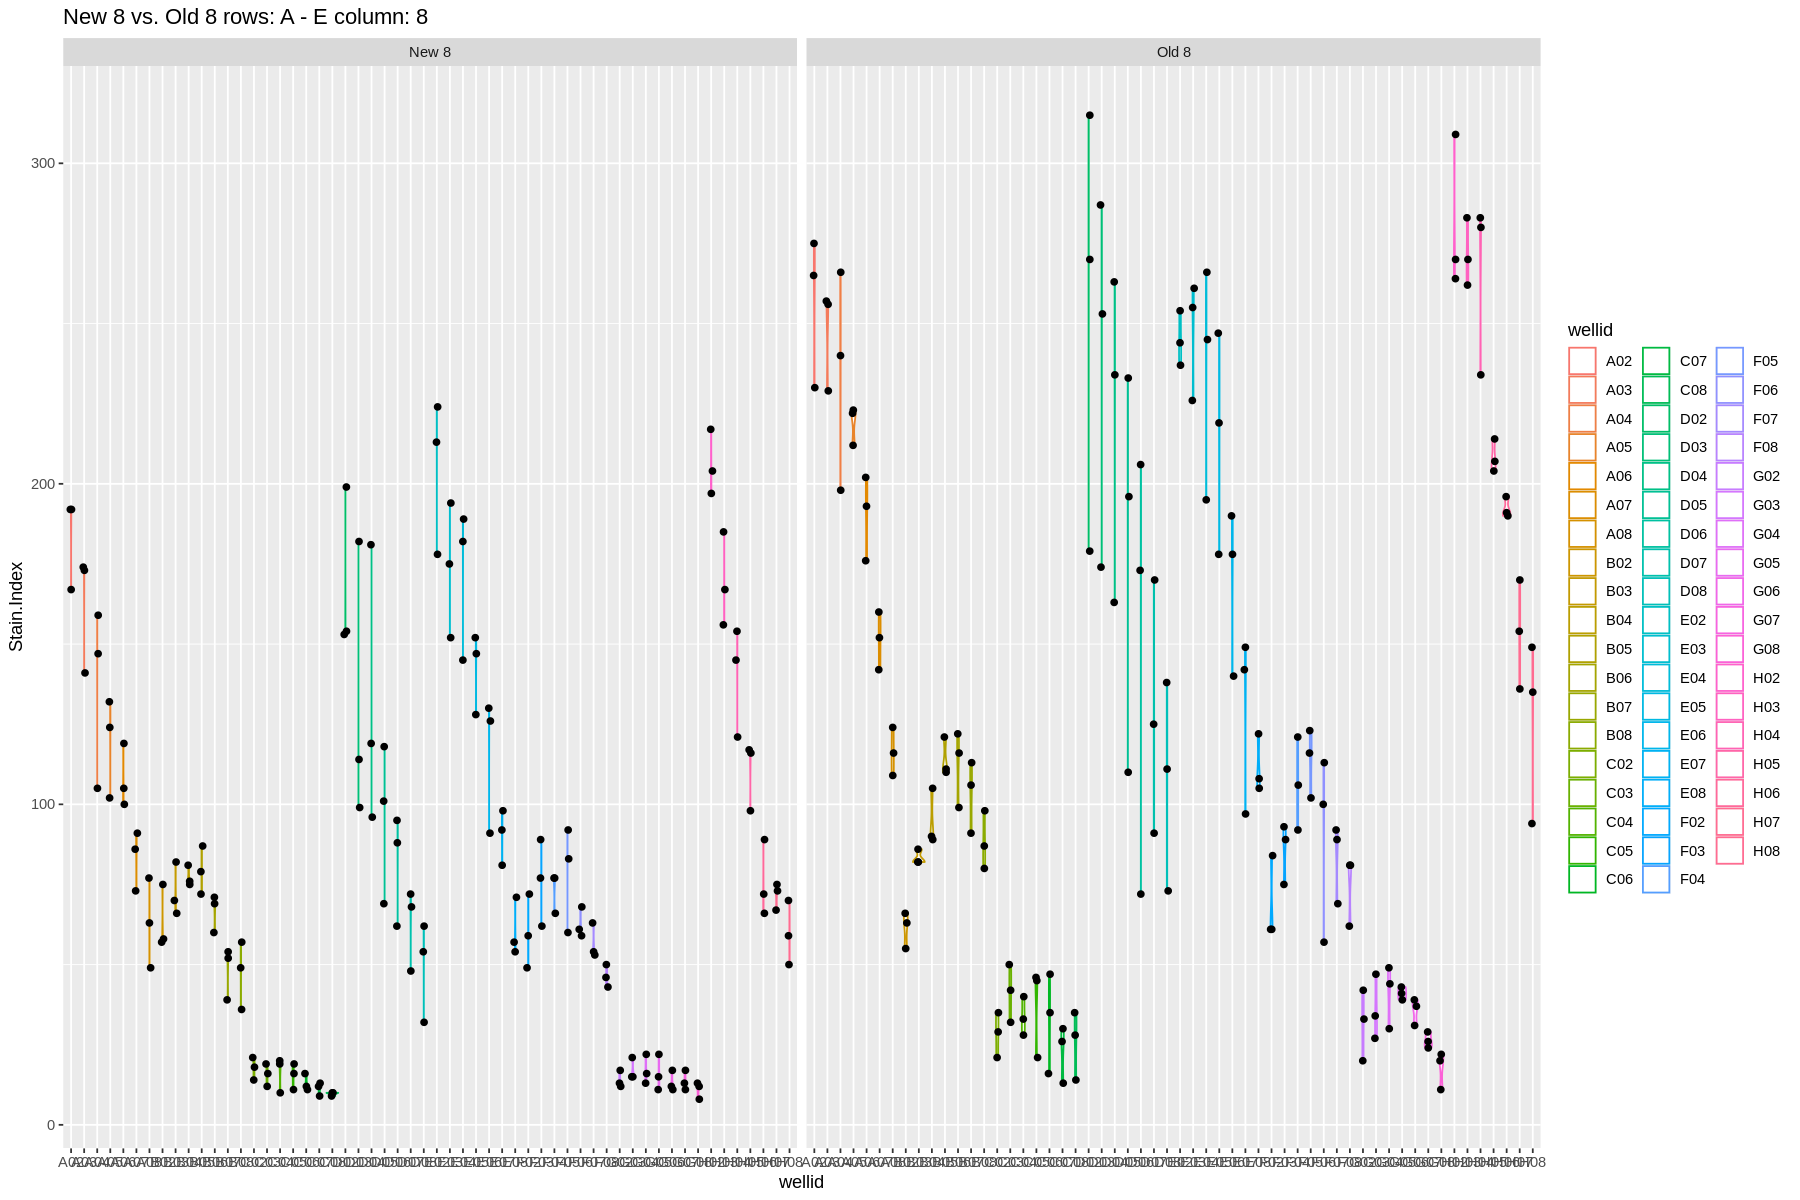

In [878]:
ggplot(dfm, aes(wellid, Stain.Index)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 A-H rows") ) +
    facet_wrap(~ method)
#ggsave(filename = "violin_4rows_new8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

In [11]:
dff <- dfm %>% 
    mutate(group = case_when(
       as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
       as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
       as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
       as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
       as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
       as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
       as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
        ),
           row = case_when(
       substr(wellid, 1,1) == "A" ~ "A-E",
       substr(wellid, 1,1) == "B" ~ "B-F",
       substr(wellid, 1,1) == "C" ~ "C-G",
       substr(wellid, 1,1) == "D" ~ "D-H",
       substr(wellid, 1,1) == "E" ~ "A-E",
       substr(wellid, 1,1) == "F" ~ "B-F",
       substr(wellid, 1,1) == "G" ~ "C-G",
       substr(wellid, 1,1) == "H" ~ "D-H"
       ),
           subgroup = case_when(
       row == "A-E" & group == "COL2" ~ "A2-E2",
       row == "A-E" & group == "COL3" ~ "A3-E3",
       row == "A-E" & group == "COL4" ~ "A4-E4",
       row == "A-E" & group == "COL5" ~ "A5-E5",
       row == "A-E" & group == "COL6" ~ "A6-E6",
       row == "A-E" & group == "COL7" ~ "A7-E7",
       row == "A-E" & group == "COL8" ~ "A8-E8",
       row == "B-F" & group == "COL2" ~ "B2-F2",
       row == "B-F" & group == "COL3" ~ "B3-F3",
       row == "B-F" & group == "COL4" ~ "B4-F4",
       row == "B-F" & group == "COL5" ~ "B5-F5",
       row == "B-F" & group == "COL6" ~ "B6-F6",
       row == "B-F" & group == "COL7" ~ "B7-F7",
       row == "B-F" & group == "COL8" ~ "B8-F8",
       row == "C-G" & group == "COL2" ~ "C2-G2",
       row == "C-G" & group == "COL3" ~ "C3-G3",
       row == "C-G" & group == "COL4" ~ "C4-G4",
       row == "C-G" & group == "COL5" ~ "C5-G5",
       row == "C-G" & group == "COL6" ~ "C6-G6",
       row == "C-G" & group == "COL7" ~ "C7-G7",
       row == "C-G" & group == "COL8" ~ "C8-G8",
       row == "D-H" & group == "COL2" ~ "D2-H2",
       row == "D-H" & group == "COL3" ~ "D3-H3",
       row == "D-H" & group == "COL4" ~ "D4-H4",
       row == "D-H" & group == "COL5" ~ "D5-H5",
       row == "D-H" & group == "COL6" ~ "D6-H6",
       row == "D-H" & group == "COL7" ~ "D7-H7",
       row == "D-H" & group == "COL8" ~ "D8-H8"
           )
      )

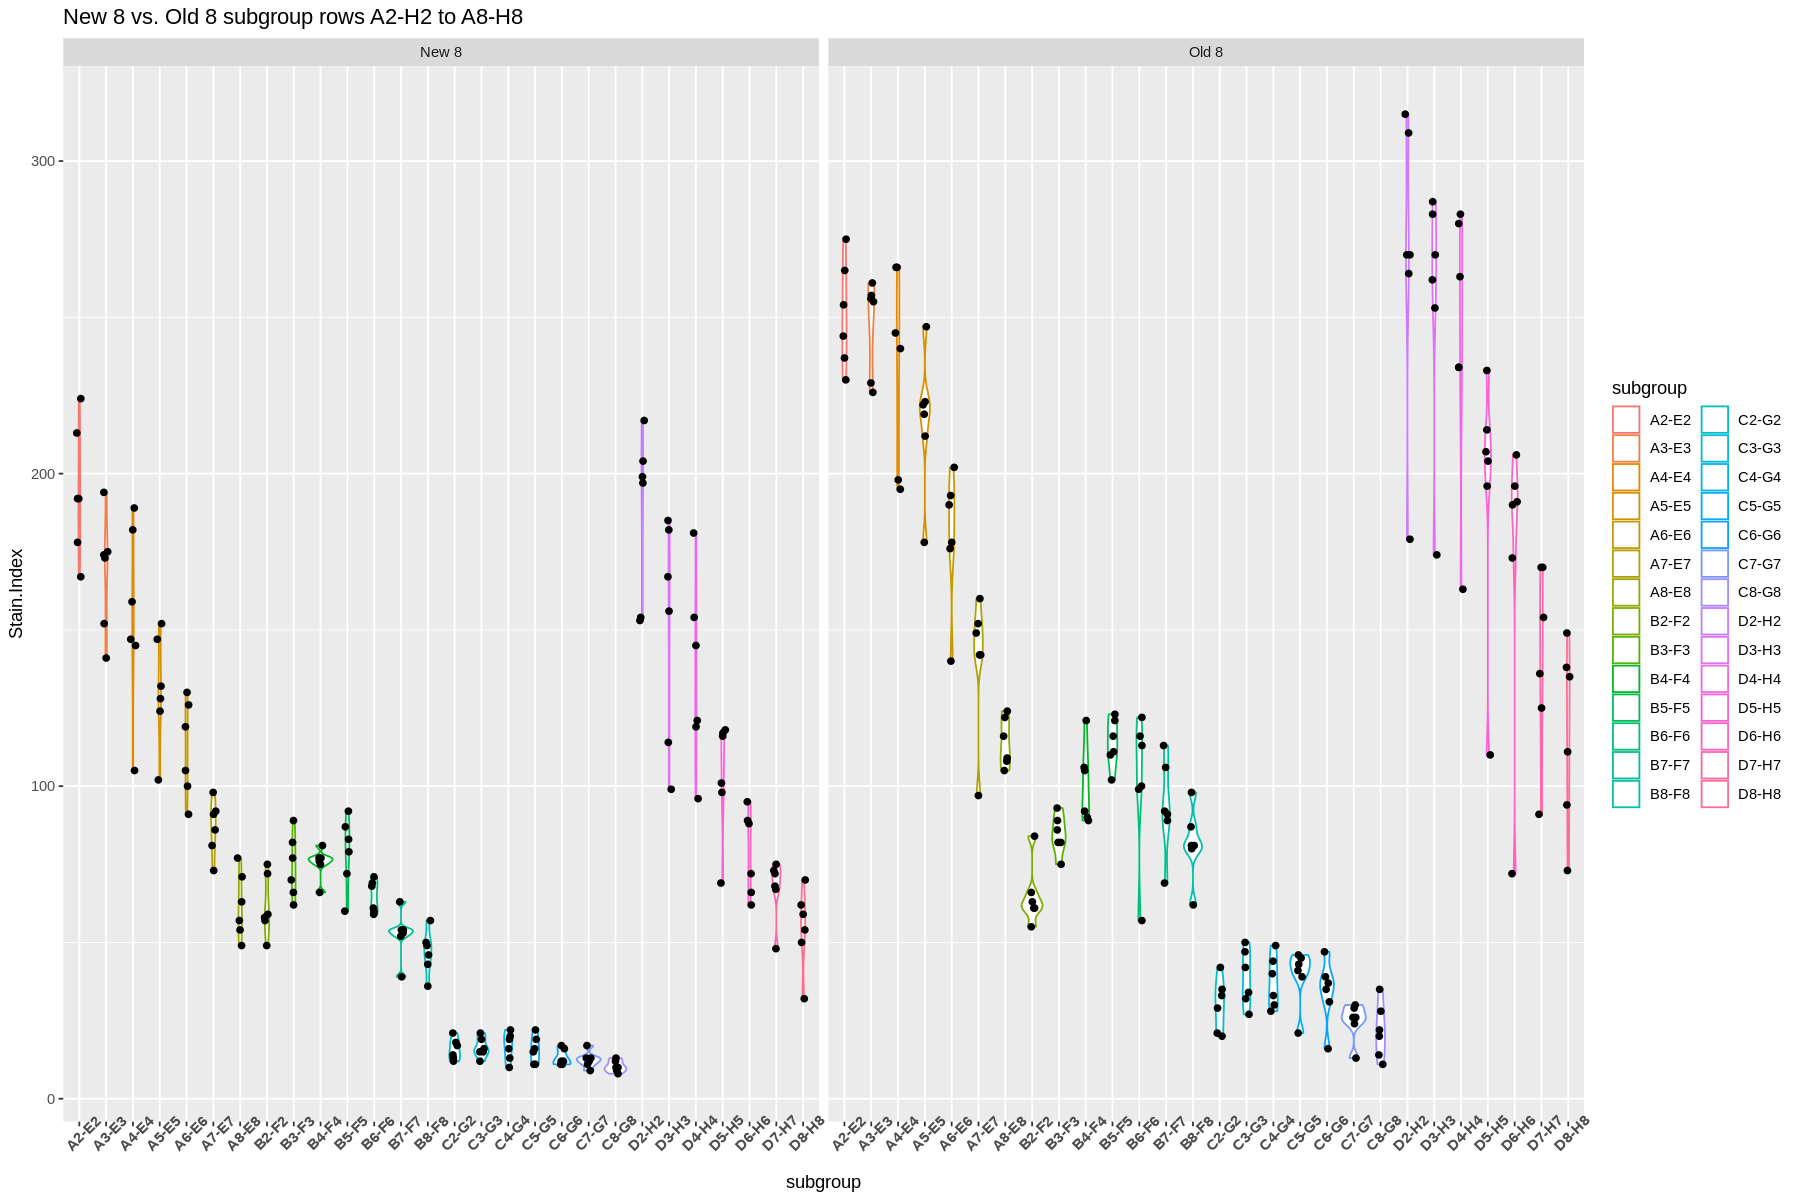

In [32]:
ggplot(dff, aes(subgroup, Stain.Index,)) + 
    geom_violin(aes(colour = subgroup)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 subgroup rows A2-H2 to A8-H8") ) +
    facet_wrap( ~ method) + 
    theme(axis.text.x = element_text(face = "bold", 
                           size = 8.75, angle = 45)) 

### Find Outliers using Tietjen Moore Test
- detect multiple outliers in a univariate data set that follows an approximately normal distribution
- If there are no outliers in the data, the test statistic is close to 1. If there are outliers in the data, the test statistic will be closer to zero

In [37]:
# A-E new 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("A", i, "-E", i) & method == "New 8") %>% select(Stain.Index) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0.2772559

$Talpha
        5% 
0.03328881 

$T
[1] 0.2061176

$Talpha
        5% 
0.03190116 

$T
[1] 0.189931

$Talpha
        5% 
0.03336521 

$T
[1] 0.189594

$Talpha
        5% 
0.03392205 

$T
[1] 0.3633089

$Talpha
        5% 
0.03250674 

$T
[1] 0.195019

$Talpha
        5% 
0.03264202 

$T
[1] 0.2987607

$Talpha
        5% 
0.03214377 



In [38]:
# B-F new 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("B", i, "-F", i) & method == "New 8") %>% select(Stain.Index) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0.3057456

$Talpha
       5% 
0.0336702 

$T
[1] 0.2929987

$Talpha
        5% 
0.03173806 

$T
[1] 0.02194149

$Talpha
        5% 
0.03148432 

$T
[1] 0.1863142

$Talpha
        5% 
0.03203924 

$T
[1] 0.473301

$Talpha
        5% 
0.03152042 

$T
[1] 0.009243697

$Talpha
        5% 
0.03176698 

$T
[1] 0.1196013

$Talpha
       5% 
0.0322873 



In [39]:
# C-G new 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("C", i, "-G", i) & method == "New 8") %>% select(Stain.Index) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0.2889518

$Talpha
        5% 
0.03248224 

$T
[1] 0.2094156

$Talpha
        5% 
0.03218773 

$T
[1] 0.2903226

$Talpha
       5% 
0.0342524 

$T
[1] 0.3435315

$Talpha
        5% 
0.03331038 

$T
[1] 0.02870813

$Talpha
       5% 
0.0347575 

$T
[1] 0.07746479

$Talpha
        5% 
0.03187379 

$T
[1] 0.2740385

$Talpha
       5% 
0.0318314 



In [40]:
# D-H new 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("D", i, "-H", i) & method == "New 8") %>% select(Stain.Index) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0.06601251

$Talpha
        5% 
0.03291994 

$T
[1] 0.08485973

$Talpha
        5% 
0.03355819 

$T
[1] 0.2008693

$Talpha
        5% 
0.03056965 

$T
[1] 0.1656494

$Talpha
        5% 
0.03337362 

$T
[1] 0.4227032

$Talpha
       5% 
0.0328016 

$T
[1] 0.05340637

$Talpha
       5% 
0.0323329 

$T
[1] 0.1004742

$Talpha
        5% 
0.03426096 



In [41]:
# A-E old 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("A", i, "-E", i) & method == "Old 8") %>% select(Stain.Index) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0.3040564

$Talpha
        5% 
0.03480959 

$T
[1] 0.01721515

$Talpha
        5% 
0.03391167 

$T
[1] 0.1125897

$Talpha
        5% 
0.03214587 

$T
[1] 0.02947229

$Talpha
        5% 
0.03314347 

$T
[1] 0.09134649

$Talpha
        5% 
0.03102019 

$T
[1] 0.03093095

$Talpha
        5% 
0.03293298 

$T
[1] 0.4153226

$Talpha
        5% 
0.03217253 



In [42]:
# B-F old 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("B", i, "-F", i) & method == "Old 8") %>% select(Stain.Index) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0.03363454

$Talpha
        5% 
0.03277557 

$T
[1] 0.1759494

$Talpha
        5% 
0.03258557 

$T
[1] 0.2708466

$Talpha
        5% 
0.03330983 

$T
[1] 0.2542653

$Talpha
       5% 
0.0321681 

$T
[1] 0.08361103

$Talpha
        5% 
0.03242694 

$T
[1] 0.1553204

$Talpha
        5% 
0.03373327 

$T
[1] 0.04485777

$Talpha
        5% 
0.03423648 



In [43]:
# C-G old 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("C", i, "-G", i) & method == "Old 8") %>% select(Stain.Index) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0.3194444

$Talpha
        5% 
0.03293988 

$T
[1] 0.3567666

$Talpha
       5% 
0.0342662 

$T
[1] 0.3534069

$Talpha
        5% 
0.03251567 

$T
[1] 0.04663817

$Talpha
        5% 
0.03183377 

$T
[1] 0.06519714

$Talpha
        5% 
0.03117837 

$T
[1] 0.0680605

$Talpha
        5% 
0.03267767 

$T
[1] 0.2542373

$Talpha
        5% 
0.03564459 



In [44]:
# D-H Old  
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("D", i, "-H", i) & method == "Old 8") %>% select(Stain.Index) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0.1085567

$Talpha
        5% 
0.03471023 

$T
[1] 0.05620555

$Talpha
        5% 
0.03337469 

$T
[1] 0.1561551

$Talpha
        5% 
0.03245081 

$T
[1] 0.01802703

$Talpha
       5% 
0.0329949 

$T
[1] 0.02424421

$Talpha
        5% 
0.03190384 

$T
[1] 0.2549115

$Talpha
        5% 
0.03469555 

$T
[1] 0.3042431

$Talpha
        5% 
0.03263693 



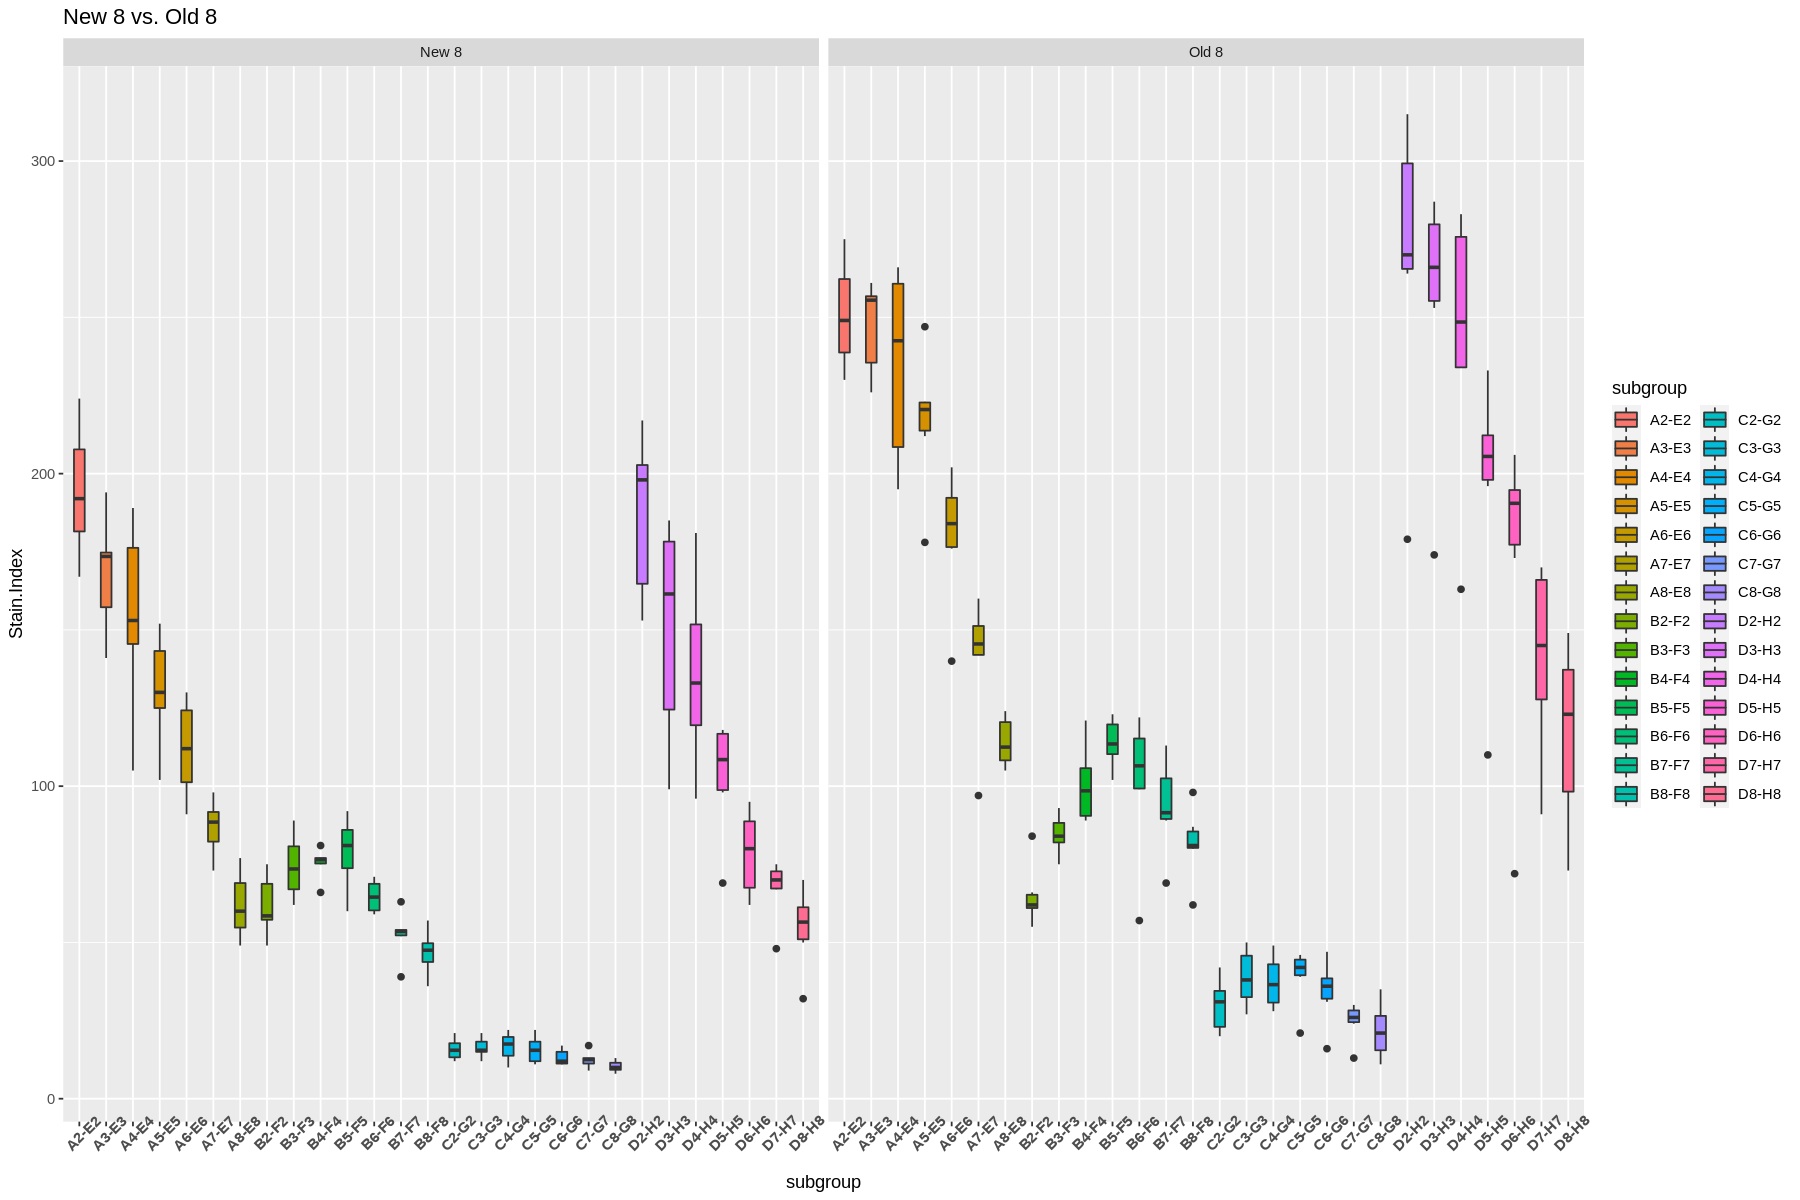

In [47]:
ggplot(dff, aes(subgroup, Stain.Index, fill=subgroup)) +
    geom_boxplot(width = 0.4) + 
#    stat_summary(geom="text", fun=quantile,
#           aes(label=sprintf("%1.1f", ..y..), color=subgroup),
#           position=position_nudge(x=0.4), size=3.25) +
    ggtitle("New 8 vs. Old 8") + 
    facet_wrap( ~ method) +
    theme(axis.text.x = element_text(face = "bold", 
                           size = 8.75, angle = 45)) 
#ggsave(filename = "boxplt_new8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

In [12]:
# linear regression 
dfn <- dff %>% filter(method == "New 8")
dfo <- dff %>% filter(method == "Old 8")
dfm <- inner_join(x = dfn, y = dfo, by = "wellid")
reg <- lm(Stain.Index.y~Stain.Index.x,data=dfm) 
dfm <- dfm %>% mutate(regline = reg[[1]][2]*Stain.Index.x + reg[[1]][1])
summary(reg)


Call:
lm(formula = Stain.Index.y ~ Stain.Index.x, data = dfm)

Residuals:
     Min       1Q   Median       3Q      Max 
-110.347  -20.967   -4.255   18.490  131.627 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   22.74000    2.75572   8.252 1.38e-15 ***
Stain.Index.x  1.33973    0.02812  47.647  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 35.73 on 502 degrees of freedom
Multiple R-squared:  0.8189,	Adjusted R-squared:  0.8186 
F-statistic:  2270 on 1 and 502 DF,  p-value: < 2.2e-16


In [13]:
head(dfm)

Stain.Index.x Sample..x               wellid plate.x method.x group.x row.x
1 167           Specimen_001_A2_A02.fcs A02    plate 1 New 8    COL2    A-E  
2 167           Specimen_001_A2_A02.fcs A02    plate 1 New 8    COL2    A-E  
3 167           Specimen_001_A2_A02.fcs A02    plate 1 New 8    COL2    A-E  
4 141           Specimen_001_A3_A03.fcs A03    plate 1 New 8    COL3    A-E  
5 141           Specimen_001_A3_A03.fcs A03    plate 1 New 8    COL3    A-E  
6 141           Specimen_001_A3_A03.fcs A03    plate 1 New 8    COL3    A-E  
  subgroup.x Stain.Index.y Sample..y               plate.y method.y group.y
1 A2-E2      275           Specimen_001_A2_A02.fcs plate 1 Old 8    COL2   
2 A2-E2      265           Specimen_001_A2_A02.fcs plate 2 Old 8    COL2   
3 A2-E2      230           Specimen_001_A2_A02.fcs plate 3 Old 8    COL2   
4 A3-E3      257           Specimen_001_A3_A03.fcs plate 1 Old 8    COL3   
5 A3-E3      256           Specimen_001_A3_A03.fcs plate 2 Old 8    COL3   
6 A3-E3      229           Specimen_001_A3_A03.fcs plate 3 Old 8    COL3   
  row.y subgroup.y regline 
1 A-E   A2-E2      246.4753
2 A-E   A2-E2      246.4753
3 A-E   A2-E2      246.4753
4 A-E   A3-E3      211.6422
5 A-E   A3-E3      211.6422
6 A-E   A3-E3      211.6422

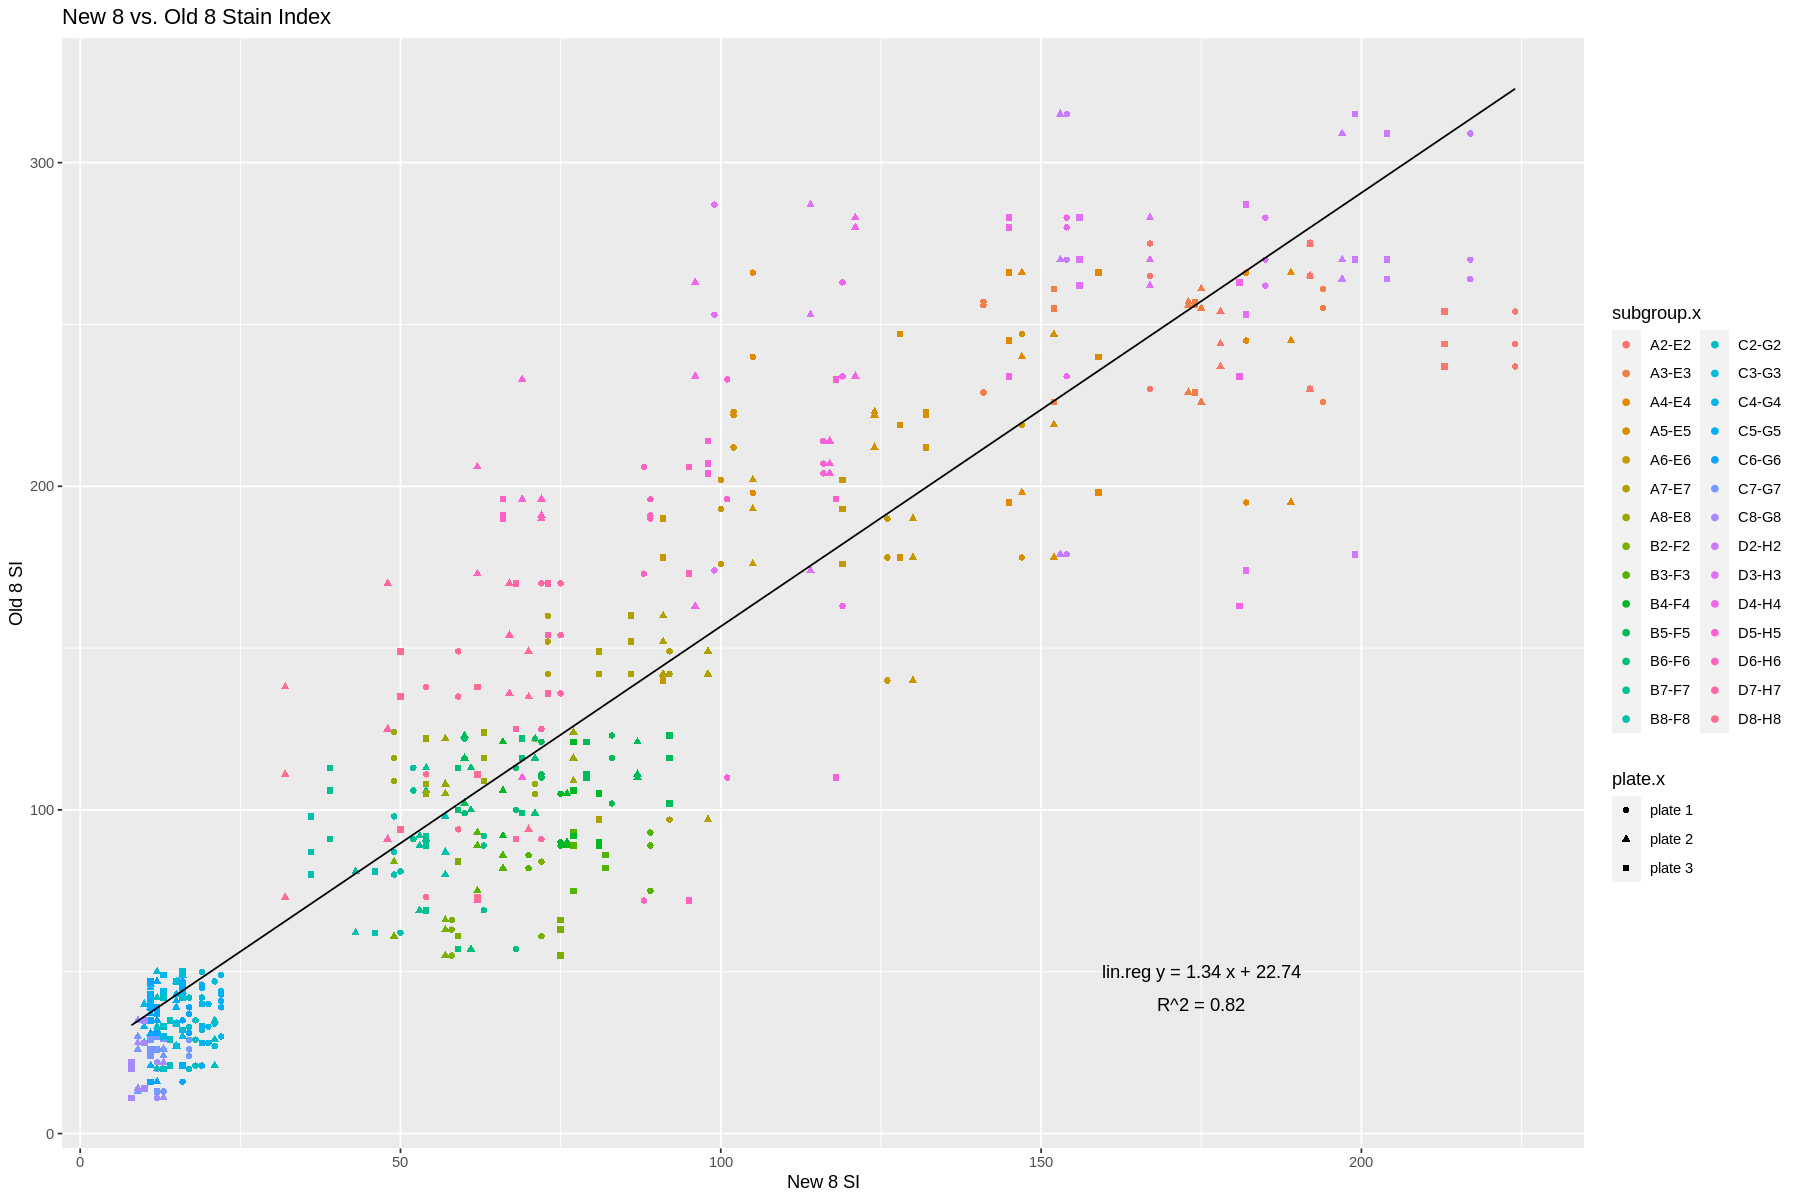

In [86]:
ggplot(dfm) + 
    geom_point(aes(x = Stain.Index.x, 
                   y = Stain.Index.y, 
                   color=subgroup.x, 
                   shape = plate.x)) + 
    geom_line(aes(x = Stain.Index.x, 
                  y = regline)) + 
    ggtitle("New 8 vs. Old 8 Stain Index") + 
    xlab("New 8 SI") + 
    ylab("Old 8 SI") + 
    annotate("text", 
             x = 175, 
             y = 50, 
             label = paste("lin.reg y =", round(reg[[1]][2],2), "x +", 
                           round(reg[[1]][1],2))) + 
    annotate("text",
             x = 175,
             y = 40,
             label = paste("R^2 =", round(summary(reg)$`r.squared`, 2)))


### XmR charts to show data series

In [14]:
row_pair_ls <- list()
for (i in seq(4)) {
    row_pair_ls[[i]] <- c(wellIDs[, rows[[i]][1]], wellIDs[, rows[[i]][2]])
}
row_pair_ls <- unlist(row_pair_ls)
row_pair_ls

ERROR: Error in eval(expr, envir, enclos): object 'wellIDs' not found


In [117]:
head(dff)

Stain.Index Sample.                 wellid plate   method group row subgroup
1 167         Specimen_001_A2_A02.fcs A02    plate 1 New 8  COL2  A-E A2-E2   
2 141         Specimen_001_A3_A03.fcs A03    plate 1 New 8  COL3  A-E A3-E3   
3 105         Specimen_001_A4_A04.fcs A04    plate 1 New 8  COL4  A-E A4-E4   
4 102         Specimen_001_A5_A05.fcs A05    plate 1 New 8  COL5  A-E A5-E5   
5 100         Specimen_001_A6_A06.fcs A06    plate 1 New 8  COL6  A-E A6-E6   
6  73         Specimen_001_A7_A07.fcs A07    plate 1 New 8  COL7  A-E A7-E7

In [15]:
options(repr.plot.width=25, repr.plot.height=15)

In [30]:
dff %>% filter(method == "New 8")

Stain.Index Sample.                 wellid plate   method group row
1   167         Specimen_001_A2_A02.fcs A02    plate 1 New 8  COL2  A-E
2   141         Specimen_001_A3_A03.fcs A03    plate 1 New 8  COL3  A-E
3   105         Specimen_001_A4_A04.fcs A04    plate 1 New 8  COL4  A-E
4   102         Specimen_001_A5_A05.fcs A05    plate 1 New 8  COL5  A-E
5   100         Specimen_001_A6_A06.fcs A06    plate 1 New 8  COL6  A-E
6    73         Specimen_001_A7_A07.fcs A07    plate 1 New 8  COL7  A-E
7    49         Specimen_001_A8_A08.fcs A08    plate 1 New 8  COL8  A-E
8    58         Specimen_001_B2_B02.fcs B02    plate 1 New 8  COL2  B-F
9    70         Specimen_001_B3_B03.fcs B03    plate 1 New 8  COL3  B-F
10   75         Specimen_001_B4_B04.fcs B04    plate 1 New 8  COL4  B-F
11   72         Specimen_001_B5_B05.fcs B05    plate 1 New 8  COL5  B-F
12   60         Specimen_001_B6_B06.fcs B06    plate 1 New 8  COL6  B-F
13   52         Specimen_001_B7_B07.fcs B07    plate 1 New 8  COL7  B-F
14   49         Specimen_001_B8_B08.fcs B08    plate 1 New 8  COL8  B-F
15   18         Specimen_001_C2_C02.fcs C02    plate 1 New 8  COL2  C-G
16   19         Specimen_001_C3_C03.fcs C03    plate 1 New 8  COL3  C-G
17   20         Specimen_001_C4_C04.fcs C04    plate 1 New 8  COL4  C-G
18   19         Specimen_001_C5_C05.fcs C05    plate 1 New 8  COL5  C-G
19   16         Specimen_001_C6_C06.fcs C06    plate 1 New 8  COL6  C-G
20   13         Specimen_001_C7_C07.fcs C07    plate 1 New 8  COL7  C-G
21   10         Specimen_001_C8_C08.fcs C08    plate 1 New 8  COL8  C-G
22  154         Specimen_001_D2_D02.fcs D02    plate 1 New 8  COL2  D-H
23   99         Specimen_001_D3_D03.fcs D03    plate 1 New 8  COL3  D-H
24  119         Specimen_001_D4_D04.fcs D04    plate 1 New 8  COL4  D-H
25  101         Specimen_001_D5_D05.fcs D05    plate 1 New 8  COL5  D-H
26   88         Specimen_001_D6_D06.fcs D06    plate 1 New 8  COL6  D-H
27   72         Specimen_001_D7_D07.fcs D07    plate 1 New 8  COL7  D-H
28   54         Specimen_001_D8_D08.fcs D08    plate 1 New 8  COL8  D-H
29  224         Specimen_001_E2_E02.fcs E02    plate 1 New 8  COL2  A-E
30  194         Specimen_001_E3_E03.fcs E03    plate 1 New 8  COL3  A-E
⋮   ⋮           ⋮                       ⋮      ⋮       ⋮      ⋮     ⋮  
139  68         Specimen_001_D7_D07.fcs D07    plate 3 New 8  COL7  D-H
140  62         Specimen_001_D8_D08.fcs D08    plate 3 New 8  COL8  D-H
141 213         Specimen_001_E2_E02.fcs E02    plate 3 New 8  COL2  A-E
142 152         Specimen_001_E3_E03.fcs E03    plate 3 New 8  COL3  A-E
143 145         Specimen_001_E4_E04.fcs E04    plate 3 New 8  COL4  A-E
144 128         Specimen_001_E5_E05.fcs E05    plate 3 New 8  COL5  A-E
145  91         Specimen_001_E6_E06.fcs E06    plate 3 New 8  COL6  A-E
146  81         Specimen_001_E7_E07.fcs E07    plate 3 New 8  COL7  A-E
147  54         Specimen_001_E8_E08.fcs E08    plate 3 New 8  COL8  A-E
148  59         Specimen_001_F2_F02.fcs F02    plate 3 New 8  COL2  B-F
149  77         Specimen_001_F3_F03.fcs F03    plate 3 New 8  COL3  B-F
150  77         Specimen_001_F4_F04.fcs F04    plate 3 New 8  COL4  B-F
151  92         Specimen_001_F5_F05.fcs F05    plate 3 New 8  COL5  B-F
152  59         Specimen_001_F6_F06.fcs F06    plate 3 New 8  COL6  B-F
153  54         Specimen_001_F7_F07.fcs F07    plate 3 New 8  COL7  B-F
154  46         Specimen_001_F8_F08.fcs F08    plate 3 New 8  COL8  B-F
155  13         Specimen_001_G2_G02.fcs G02    plate 3 New 8  COL2  C-G
156  15         Specimen_001_G3_G03.fcs G03    plate 3 New 8  COL3  C-G
157  13         Specimen_001_G4_G04.fcs G04    plate 3 New 8  COL4  C-G
158  11         Specimen_001_G5_G05.fcs G05    plate 3 New 8  COL5  C-G
159  12         Specimen_001_G6_G06.fcs G06    plate 3 New 8  COL6  C-G
160  11         Specimen_001_G7_G07.fcs G07    plate 3 New 8  COL7  C-G
161   8         Specimen_001_G8_G08.fcs G08    plate 3 New 8  COL8  C-G
162 204         Specimen_001_H2_H02.fcs H02 

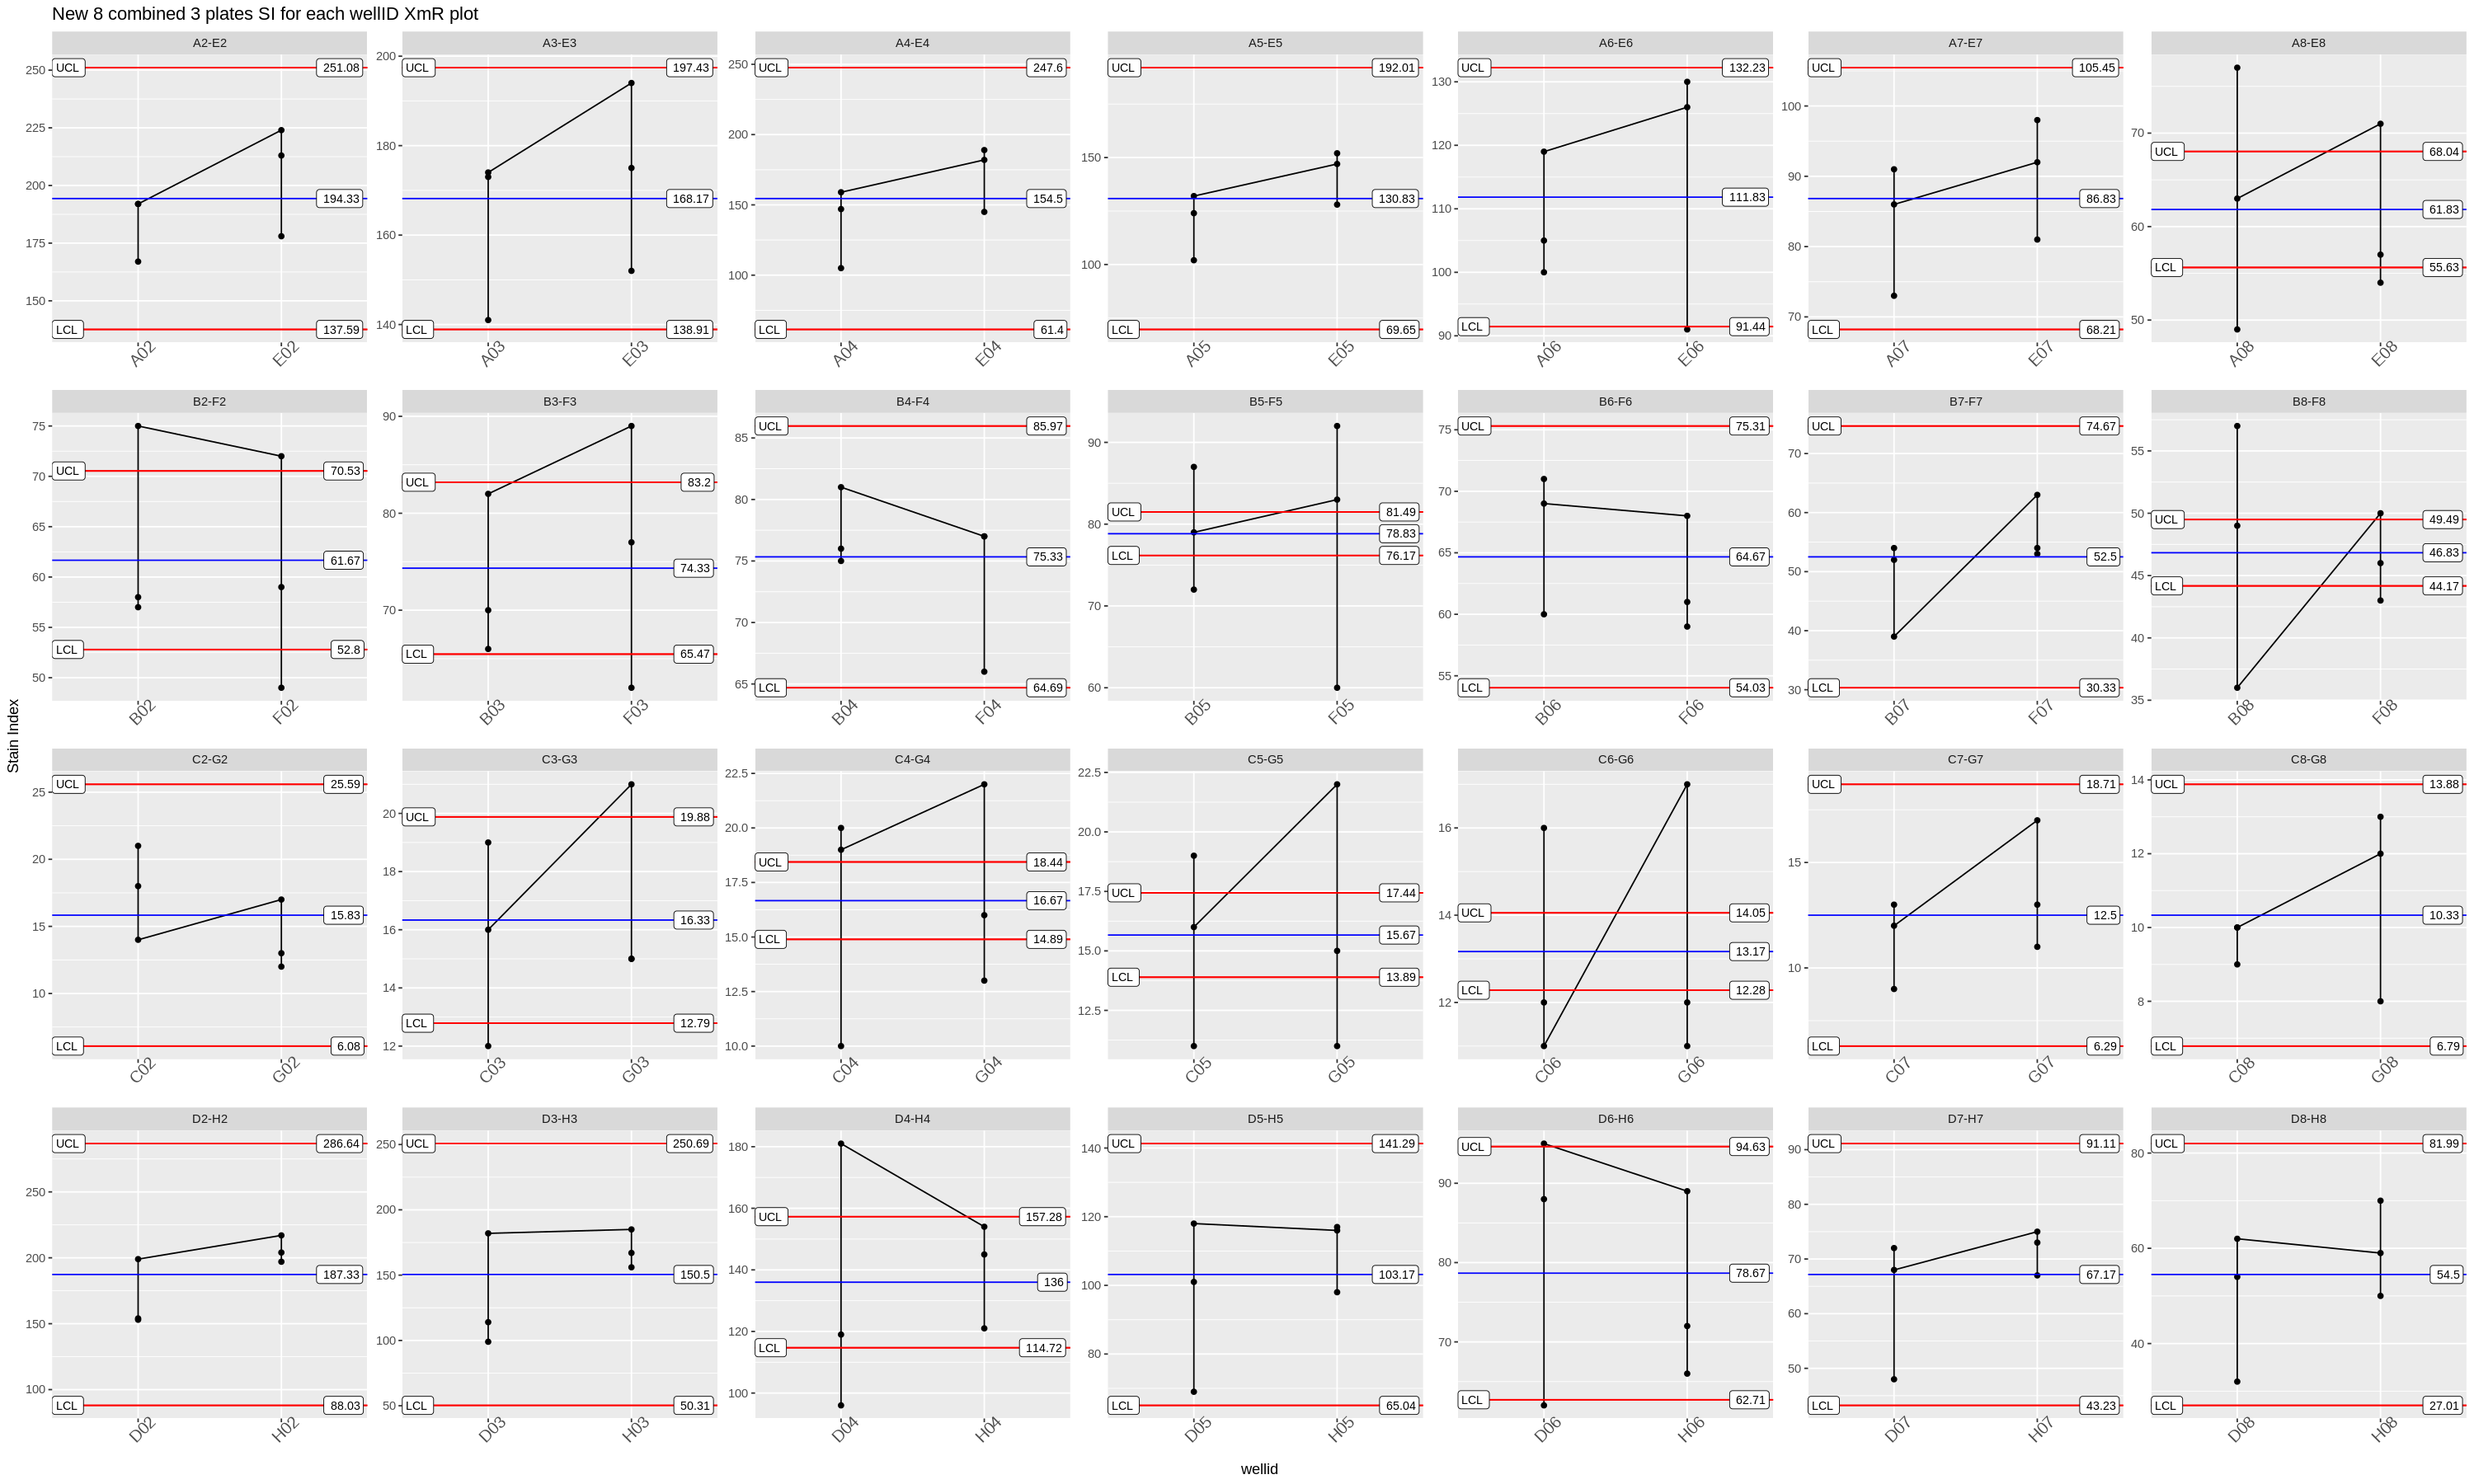

In [25]:
df.t <- dff %>% filter(method == "New 8")
ggplot(df.t, aes(x=wellid, y=Stain.Index, group = group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("Stain Index") +
  #scale_x_discrete(breaks=1:16,
  #                 labels=labels) + 
  facet_wrap(~ subgroup, ncol = 7, scales = "free") + 
  ggtitle("New 8 combined 3 plates SI for each wellID XmR plot") +
  theme(axis.text.x = element_text(size = 12, angle = 45))

#ggsave(filename = "XmR_old8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

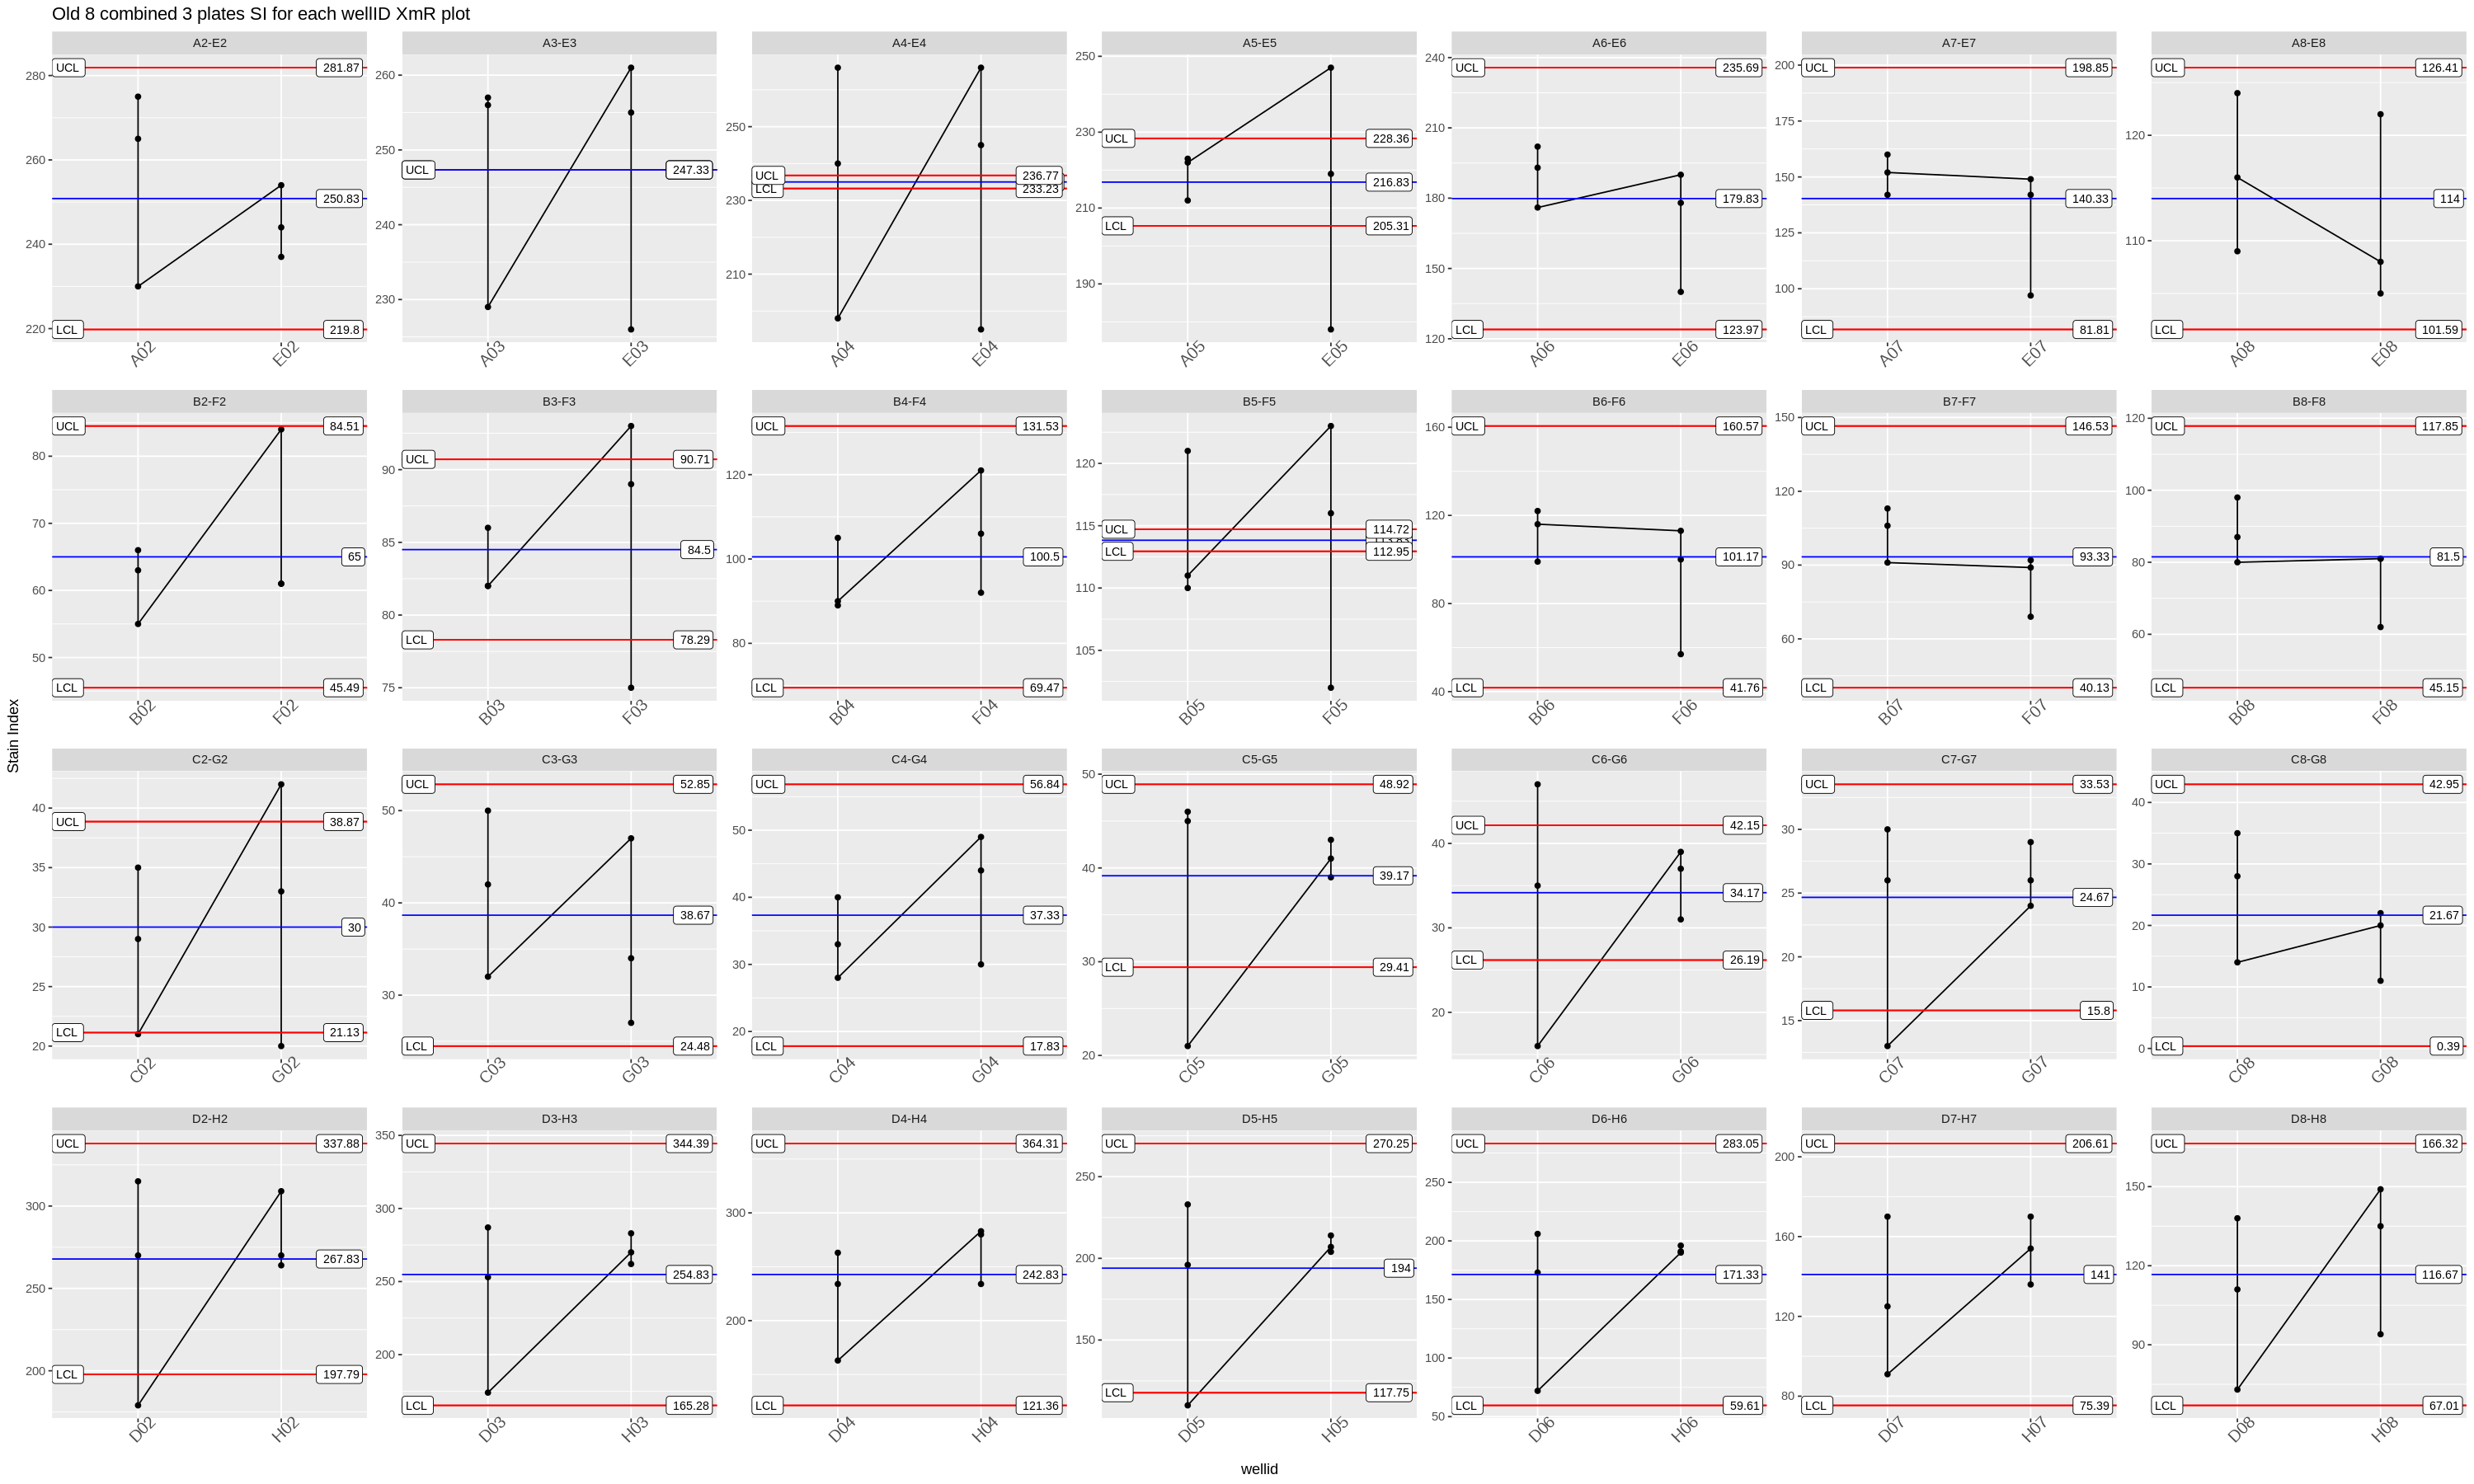

In [24]:
df.t <- dff %>% filter(method == "Old 8")
ggplot(df.t, aes(x=wellid, y=Stain.Index, group = group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("Stain Index") +
  #scale_x_discrete(expand =  expansion(mult = .04)) + 
  facet_wrap(~ subgroup, ncol = 7, scales = "free") + 
  ggtitle("Old 8 combined 3 plates SI for each wellID XmR plot") +
  theme(axis.text.x = element_text(size = 12, angle = 45))

#ggsave(filename = "XmR_old8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

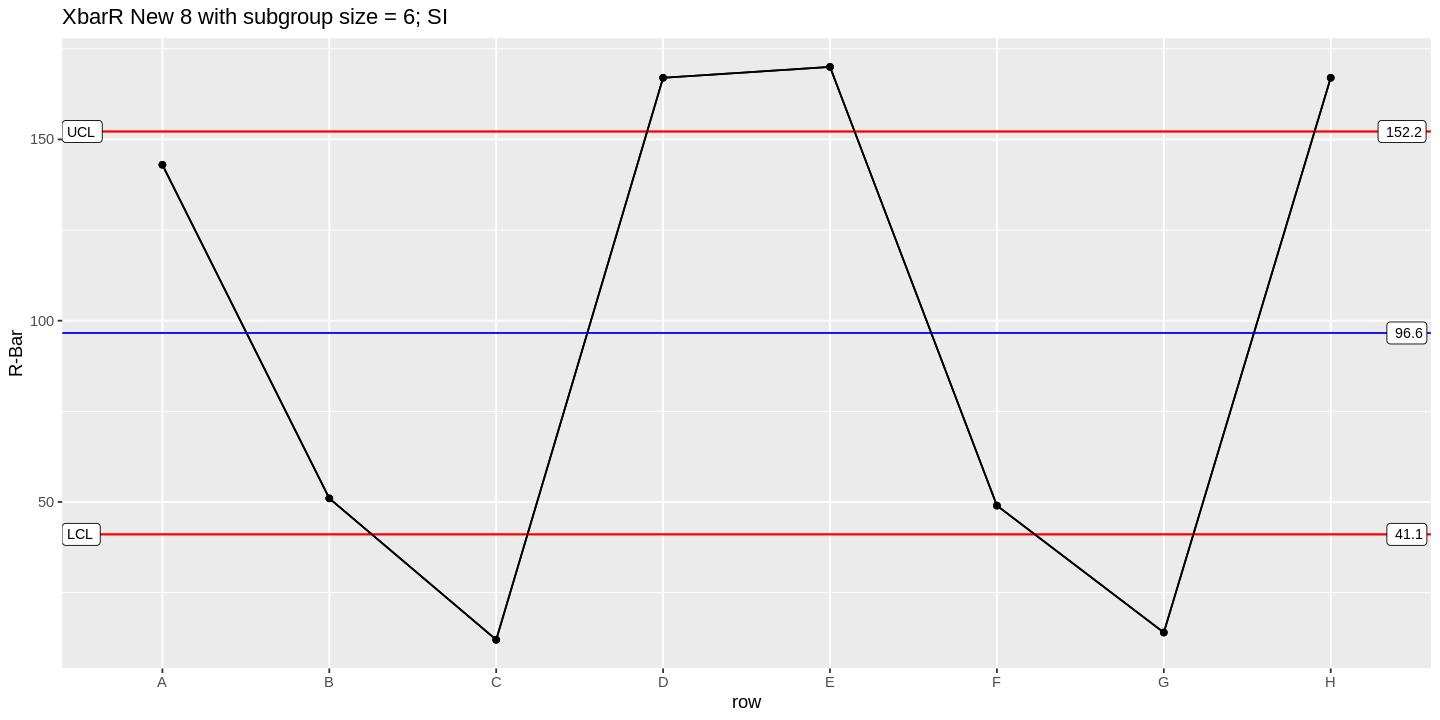

In [184]:
suppressWarnings(ggplot(dff.new8.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR New 8 with subgroup size = 6; SI"))

# Conclusion

- Seems as though the experiment is not setup for statistically convincing data
- May be inherent to flow cytometry experiments
- Or could design a new experiment:
    - Run 1 plate at a time, 2x for 8 channel and 96 core head
    - After each plate finishes, immediately wash and start on flow cytometer (use 2x cytometers; this will help even out inherent variances that can be pooled)
    - Perhaps use a real cell counter and count cells of a plate to compare against the X20
    - Append to current dataset cell count with n=3 prior to washing